## Introduction

In New York City, the pressing challenge of housing affordability has been brought into sharp distinction by the widening gap between housing costs and income growth, a trend that has escalated over the years. This disparity has rendered affordable housing development not just a policy priority but a critical necessity for maintaining the city's economic diversity and vitality. The harsh truth is that nearly all low-income New Yorkers are now rent-burdened, dedicating a significant portion of their income to housing costs. This issue is compounded by a historic low vacancy rate of 1.4% in 2023, down from 4.54% in previous years, indicating a severe scarcity of available rental units, particularly acute in lower rent categories where the net rental vacancy rate for units renting for under $2,400 is below 1%.  

This research is grounded in the urgent need for data-driven insights to navigate New York City's housing crisis, striving to make affordable housing more accessible and aligned with the needs of its most vulnerable residents. Through this analysis, we aim to provide a comprehensive understanding of the city's affordable housing landscape, identifying Affordable Housing Production to make new policies to maintain the city's economic diversity and vitality.

## Data to be Used 

* The Department of Housing Preservation and Development (HPD) reports on projects, buildings, and units that began after January 1, 2014, and are counted towards either the Housing New York plan (1/1/2014 – 12/31/2021) or the Housing Our Neighbors: A Blueprint for Housing & Homelessness plan (1/1/2022 – present).

#### CSV Format
* We plan to use the data for Housing New York plan 1/1/2014 – 12/31/2021 in CSV format available under the link https://data.cityofnewyork.us/Housing-Development/Affordable-Housing-Production-by-Project/hq68-rnsi/about_data

#### Web API
* The data for Housing Our Neighbors: A Blueprint for Housing & Homelessness plan (1/1/2022 – present) can be collected using Web API from the link https://data.cityofnewyork.us/resource/hq68-rnsi.json?$query=SELECT%0A%20%20%60project_id%60%2C%0A%20%20%60project_name%60%2C%0A%20%20%60program_group%60%2C%0A%20%20%60project_start_date%60%2C%0A%20%20%60project_completion_date%60%2C%0A%20%20%60extended_affordability_status%60%2C%0A%20%20%60prevailing_wage_status%60%2C%0A%20%20%60planned_tax_benefit%60%2C%0A%20%20%60extremely_low_income_units%60%2C%0A%20%20%60very_low_income%60%2C%0A%20%20%60low_income_units%60%2C%0A%20%20%60moderate_income%60%2C%0A%20%20%60middle_income%60%2C%0A%20%20%60other%60%2C%0A%20%20%60counted_rental_units%60%2C%0A%20%20%60counted_homeownership_units%60%2C%0A%20%20%60all_counted_units%60%2C%0A%20%20%60total_units%60%2C%0A%20%20%60senior_units%60%0AWHERE%0A%20%20%60project_start_date%60%0A%20%20%20%20BETWEEN%20%222022-01-01T23%3A46%3A31%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222024-03-26T23%3A46%3A31%22%20%3A%3A%20floating_timestamp


In [339]:
# importing the libraries 
# importing numpy for numerical operations
import numpy as np
# pandas for data manipulation
import pandas as pd
# matplotlin.pyplot for interactive visualizations
import matplotlib.pyplot as plt
# seaborn for visualisation on the basis of matplotlib
import seaborn as sns
# warnings for supressing warnings
import warnings
warnings.filterwarnings('ignore')
# postgreSQL adapter to connect jupyter to postgreSQL
import psycopg2
from psycopg2 import sql
# for database manipulation
import sqlalchemy
# importing date to handle data and time
from datetime import date
#MinMaxScaler and LinearRegression for model prediction
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import statsmodels.api as sm

## Importing the CSV file from Github

In [3]:
#importing csv file
df_csv = pd.read_csv("https://raw.githubusercontent.com/NNikhil89/DAMFinalProject/main/Affordable_Housing_Production_by_Project_20240427.csv")

In [4]:
#printing the top rows of dataframe 
df_csv.head()

Project ID  Project Name                 Program Group Project Start Date  \
0       55759  CONFIDENTIAL  Homeowner Assistance Program         01/03/2014   
1       55647  CONFIDENTIAL  Homeowner Assistance Program         01/07/2014   
2       55773  CONFIDENTIAL  Homeowner Assistance Program         01/10/2014   
3       57341  CONFIDENTIAL  Homeowner Assistance Program         01/10/2014   
4       55697  CONFIDENTIAL  Homeowner Assistance Program         01/14/2014   

  Project Completion Date Extended Affordability Only Prevailing Wage Status  \
0              01/03/2014                          No    Non Prevailing Wage   
1              01/07/2014                          No    Non Prevailing Wage   
2              01/10/2014                          No    Non Prevailing Wage   
3              01/10/2014                          No    Non Prevailing Wage   
4              01/14/2014                          No    Non Prevailing Wage   

  Planned Tax Benefit  Extremely Low Income Units  Very Low Income Units  \
0                 NaN                           0                      0   
1                 NaN                           0                      0   
2                 NaN                           0                      0   
3                 NaN                           0                      0   
4                 NaN                           0                      0   

   Low Income Units  Moderate Income Units  Middle Income Units  \
0                 0                      0                    1   
1                 0                      0                    1   
2                 0                      0                    1   
3                 1                      0                    0   
4                 0                      0                    1   

   Other Income Units  Counted Rental Units  Counted Homeownership Units  \
0                   0                     0                            1   
1                   0                     0                            1   
2                   0                     0                            1   
3                   0                     0                            1   
4                   0                     0                            1   

   All Counted Units  Total Units  Senior Units  
0                  1            1             0  
1                  1            1             0  
2                  1            1             0  
3                  1            1             0  
4                  1            1             0

### Description of Columns
* Project ID: The Project ID is a unique numeric identifier assigned to each project by HPD.
* Project Name: The Project Name is the name assigned to the project by HPD.
* Project Start Date: The Project Start Date is the date of the project loan or agreement closing.
* Project Completion Date: The Project Completion Date is the date that the last building in the project was completed. If the project has not yet completed, then the field is blank. 
* Extended Affordability Only: The Extended Affordability Only field indicates whether the project is considered to be Extended Affordability. An extended affordability project involves no construction, but secures an extended or new regulatory agreement. All extended affordability projects have a ‘reporting construction type’ of ‘preservation.’
* Prevailing Wage Status: The Prevailing Wage Status field indicates whether the project is subject to prevailing wage requirements, such as Davis Bacon.
* Planned Tax Benefit: The Planned Tax Benefit field indicates the type of tax benefit that is anticipated for the project at the time of the project start.
* Extremely Low Income Units: Extremely Low Income Units are units with rents that are affordable to households earning 0 to 30% of the area median income (AMI).
* Very Low Income Units: Very Low Income Units are units with rents that are affordable to households earning 31 to 50% of the area median income (AMI).
* Low Income Units: Low Income Units are units with rents that are affordable to households earning 51 to 80% of the area median income (AMI).
* Moderate Income Units: Moderate Income Units are units with rents that are affordable to households earning 81 to 120% of the area median income (AMI).
* Middle Income Units: Middle Income Units are units with rents that are affordable to households earning 121 to 165% of the area median income (AMI).
* Other Income Units: Other Units are units reserved for building superintendents.
* Counted Rental Units: Counted Rental Units are the units in the building, counted toward the Housing New York plan, where assistance has been provided to landlords in exchange for a requirement for affordable units.
* Counted Homeownership Units: Counted Homeownership Units are the units in the building, counted toward the Housing New York Plan, where assistance has been provided directly to homeowners.
* All Counted Units: The Counted Units field indicates the total number of affordable units, counted towards the Housing New York plan, that are in the building
* Total Units: The Total Units field indicates the total number of units, affordable and market rate, in each building.
* Senior Units: Senior Units are units that are created or preserved for senior households.Senior Units are a subset of the Counted Units in a building.

### DataTypes of columns

In [354]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148 entries, 0 to 3147
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Project ID              3148 non-null   int64 
 1   Project Name            3148 non-null   object
 2   Program Group           3148 non-null   object
 3   Start Date              3148 non-null   object
 4   Completion Date         2813 non-null   object
 5   Extended Affordability  3148 non-null   object
 6   Prevailing Wage Status  3148 non-null   object
 7   Tax Benefit             1948 non-null   object
 8   Ext Low Income Units    3148 non-null   int64 
 9   Very Low Income Units   3148 non-null   int64 
 10  Low Income Units        3148 non-null   int64 
 11  Moderate Income Units   3148 non-null   int64 
 12  Middle Income Units     3148 non-null   int64 
 13  Other Income Units      3148 non-null   int64 
 14  Total Rental Units      3148 non-null   int64 
 15  Home

#### Categorizing Columns to different Categorical and Numerical columns

* Project ID: Numerical Discrete 
* Project Name: Categorical Nominal 
* Project Start Date: DateTime 
* Project Completion Date: DateTime
* Extended Affordability Only: Categorical Nominal
* Prevailing Wage Status: Categorical Nominal
* Planned Tax Benefit: Categorical Nominal
* Extremely Low Income Units: Numerical Discrete
* Very Low Income Units: Numerical Discrete
* Low Income Units: Numerical Discrete
* Moderate Income Units: Numerical Discrete 
* Middle Income Units: Numerical Discrete 
* Other Income Units: Numerical Discrete 
* Counted Rental Units: Numerical Discrete 
* Counted Homeownership Units: Numerical Discrete
* All Counted Units: Numerical Discrete 
* Total Units: Numerical Discrete 
* Senior Units: Numerical Discrete

#### Renaming DataFrame Columns

In [5]:
df_csv.columns = ["Project ID", "Project Name", "Program Group", "Start Date", "Completion Date", "Extended Affordability",
                  "Prevailing Wage Status", "Tax Benefit", "Ext Low Income Units", "Very Low Income Units", "Low Income Units", 
                  "Moderate Income Units", "Middle Income Units","Other Income Units", "Total Rental Units", 
                  "HomeOwnership Units", "All Units", "Total Units", "Senior Units"]

In [6]:
df_csv.head()

Project ID  Project Name                 Program Group  Start Date  \
0       55759  CONFIDENTIAL  Homeowner Assistance Program  01/03/2014   
1       55647  CONFIDENTIAL  Homeowner Assistance Program  01/07/2014   
2       55773  CONFIDENTIAL  Homeowner Assistance Program  01/10/2014   
3       57341  CONFIDENTIAL  Homeowner Assistance Program  01/10/2014   
4       55697  CONFIDENTIAL  Homeowner Assistance Program  01/14/2014   

  Completion Date Extended Affordability Prevailing Wage Status Tax Benefit  \
0      01/03/2014                     No    Non Prevailing Wage         NaN   
1      01/07/2014                     No    Non Prevailing Wage         NaN   
2      01/10/2014                     No    Non Prevailing Wage         NaN   
3      01/10/2014                     No    Non Prevailing Wage         NaN   
4      01/14/2014                     No    Non Prevailing Wage         NaN   

   Ext Low Income Units  Very Low Income Units  Low Income Units  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 1   
4                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

### Loading Data from WebAPI

#### Loading data from New York City open data API for 2022

In [8]:
df_2022 = pd.read_json('https://data.cityofnewyork.us/resource/hq68-rnsi.json?$query=SELECT%0A%20%20%60project_id%60%2C%0A%20%20%60project_name%60%2C%0A%20%20%60program_group%60%2C%0A%20%20%60project_start_date%60%2C%0A%20%20%60project_completion_date%60%2C%0A%20%20%60extended_affordability_status%60%2C%0A%20%20%60prevailing_wage_status%60%2C%0A%20%20%60planned_tax_benefit%60%2C%0A%20%20%60extremely_low_income_units%60%2C%0A%20%20%60very_low_income%60%2C%0A%20%20%60low_income_units%60%2C%0A%20%20%60moderate_income%60%2C%0A%20%20%60middle_income%60%2C%0A%20%20%60other%60%2C%0A%20%20%60counted_rental_units%60%2C%0A%20%20%60counted_homeownership_units%60%2C%0A%20%20%60all_counted_units%60%2C%0A%20%20%60total_units%60%2C%0A%20%20%60senior_units%60%0AWHERE%0A%20%20%60project_start_date%60%0A%20%20%20%20BETWEEN%20%222022-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222022-12-31T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0AORDER%20BY%20%60project_start_date%60%20ASC%20NULL%20LAST')
df_2022.head()

project_id                     project_name  \
0       72205               791 STERLING PLACE   
1       72299        100 LENOX ROAD APARTMENTS   
2       72499  485 EAST 28TH STREET APARTMENTS   
3       73791            810 EAST 165TH STREET   
4       72301              2524 ALBEMARLE ROAD   

                    program_group       project_start_date  \
0  Multifamily Incentives Program  2022-01-05T00:00:00.000   
1  Multifamily Incentives Program  2022-01-06T00:00:00.000   
2  Multifamily Incentives Program  2022-01-06T00:00:00.000   
3  Multifamily Incentives Program  2022-01-06T00:00:00.000   
4  Multifamily Incentives Program  2022-01-12T00:00:00.000   

  extended_affordability_status prevailing_wage_status planned_tax_benefit  \
0                            No    Non Prevailing Wage                421a   
1                            No    Non Prevailing Wage                421a   
2                            No    Non Prevailing Wage                421a   
3                            No    Non Prevailing Wage                421a   
4                            No    Non Prevailing Wage                421a   

   extremely_low_income_units  very_low_income  low_income_units  \
0                           0                0                 0   
1                           0                0                 0   
2                           0                0                 0   
3                           0                0                 0   
4                           0                0                 0   

   moderate_income  middle_income  other  counted_rental_units  \
0                0              5      0                     5   
1                0             29      0                    29   
2                0              6      0                     6   
3                0              2      0                     2   
4                0              2      0                     2   

   counted_homeownership_units  all_counted_units  total_units  senior_units  \
0                            0                  5           15             0   
1                            0                 29           95             0   
2                            0                  6           17             0   
3                            0                  2            6             0   
4                            0                  2            6             0   

   project_completion_date  
0                      NaN  
1  2023-02-03T00:00:00.000  
2  2023-12-14T00:00:00.000  
3                      NaN  
4  2022-11-07T00:00:00.000

In [9]:
df_2022.shape

(547, 19)

#### Loading data from New York City open data API for 2023

In [10]:
df_2023 = pd.read_json('https://data.cityofnewyork.us/resource/hq68-rnsi.json?$query=SELECT%0A%20%20%60project_id%60%2C%0A%20%20%60project_name%60%2C%0A%20%20%60program_group%60%2C%0A%20%20%60project_start_date%60%2C%0A%20%20%60project_completion_date%60%2C%0A%20%20%60extended_affordability_status%60%2C%0A%20%20%60prevailing_wage_status%60%2C%0A%20%20%60planned_tax_benefit%60%2C%0A%20%20%60extremely_low_income_units%60%2C%0A%20%20%60very_low_income%60%2C%0A%20%20%60low_income_units%60%2C%0A%20%20%60moderate_income%60%2C%0A%20%20%60middle_income%60%2C%0A%20%20%60other%60%2C%0A%20%20%60counted_rental_units%60%2C%0A%20%20%60counted_homeownership_units%60%2C%0A%20%20%60all_counted_units%60%2C%0A%20%20%60total_units%60%2C%0A%20%20%60senior_units%60%0AWHERE%0A%20%20%60project_start_date%60%0A%20%20%20%20BETWEEN%20%222023-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222023-12-31T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0AORDER%20BY%20%60project_start_date%60%20ASC%20NULL%20LAST')
df_2023.head()

project_id            project_name                   program_group  \
0       73753  3327 WHITE PLAINS ROAD  Multifamily Incentives Program   
1       73751         11 LEWIS AVENUE  Multifamily Incentives Program   
2       73745      THE BROOKLYN TOWER  Multifamily Incentives Program   
3       74196    17-11 HANCOCK STREET  Multifamily Incentives Program   
4       73341            CONFIDENTIAL    Homeowner Assistance Program   

        project_start_date extended_affordability_status  \
0  2023-01-03T00:00:00.000                            No   
1  2023-01-04T00:00:00.000                            No   
2  2023-01-05T00:00:00.000                            No   
3  2023-01-05T00:00:00.000                            No   
4  2023-01-06T00:00:00.000                            No   

  prevailing_wage_status planned_tax_benefit  extremely_low_income_units  \
0    Non Prevailing Wage                421a                           0   
1    Non Prevailing Wage                421a                           0   
2    Non Prevailing Wage                421a                           0   
3    Non Prevailing Wage                421a                           0   
4    Non Prevailing Wage                 NaN                           0   

   very_low_income  low_income_units  moderate_income  middle_income  other  \
0                0                 0                0              7      0   
1                0                 0                0              4      0   
2                0                 0                0            120      0   
3                0                 0                0             18      0   
4                0                 1                0              0      0   

   counted_rental_units  counted_homeownership_units  all_counted_units  \
0                     7                            0                  7   
1                     4                            0                  4   
2                   120                            0                120   
3                    18                            0                 18   
4                     0                            1                  1   

   total_units  senior_units  project_completion_date  
0           22             0                      NaN  
1           13             0  2023-07-14T00:00:00.000  
2          398             0                      NaN  
3           60             0  2023-11-02T00:00:00.000  
4            1             0  2023-01-06T00:00:00.000

In [11]:
df_2023.shape

(646, 19)

In [12]:
df_2022.columns

Index(['project_id', 'project_name', 'program_group', 'project_start_date',
       'extended_affordability_status', 'prevailing_wage_status',
       'planned_tax_benefit', 'extremely_low_income_units', 'very_low_income',
       'low_income_units', 'moderate_income', 'middle_income', 'other',
       'counted_rental_units', 'counted_homeownership_units',
       'all_counted_units', 'total_units', 'senior_units',
       'project_completion_date'],
      dtype='object')

#### Renaming Columns of the above DataFrames created from API

In [13]:
df_2022.columns = ["Project ID", "Project Name", "Program Group", "Start Date", "Extended Affordability",
                   "Prevailing Wage Status", "Tax Benefit", "Ext Low Income Units", "Very Low Income Units", 
                   "Low Income Units", "Moderate Income Units","Middle Income Units","Other Income Units", 
                   "Total Rental Units", "HomeOwnership Units", "All Units", "Total Units", "Senior Units", "Completion Date"]

In [14]:
# Assigning df_2022 dataframe columns to df_2023
df_2023.columns = df_2022.columns

#### Reindexing
* Reindexing the columns so that it matches the column order of the dataframe cretaed from CSV file

In [15]:
columnsOrder = ["Project ID", "Project Name", "Program Group", "Start Date", "Completion Date", "Extended Affordability",
                "Prevailing Wage Status", "Tax Benefit", "Ext Low Income Units", "Very Low Income Units", "Low Income Units", 
                "Moderate Income Units", "Middle Income Units","Other Income Units", "Total Rental Units", 
                "HomeOwnership Units", "All Units", "Total Units", "Senior Units"]

In [16]:
df_2022 = df_2022.reindex(columns=columnsOrder)

In [17]:
df_2023 = df_2023.reindex(columns=columnsOrder)

#### Concatenating the Dataframes created from CSV and API

In [18]:
df_combined = pd.concat([df_csv, df_2022, df_2023], axis=0)

In [19]:
df_combined.head()

Project ID  Project Name                 Program Group  Start Date  \
0       55759  CONFIDENTIAL  Homeowner Assistance Program  01/03/2014   
1       55647  CONFIDENTIAL  Homeowner Assistance Program  01/07/2014   
2       55773  CONFIDENTIAL  Homeowner Assistance Program  01/10/2014   
3       57341  CONFIDENTIAL  Homeowner Assistance Program  01/10/2014   
4       55697  CONFIDENTIAL  Homeowner Assistance Program  01/14/2014   

  Completion Date Extended Affordability Prevailing Wage Status Tax Benefit  \
0      01/03/2014                     No    Non Prevailing Wage         NaN   
1      01/07/2014                     No    Non Prevailing Wage         NaN   
2      01/10/2014                     No    Non Prevailing Wage         NaN   
3      01/10/2014                     No    Non Prevailing Wage         NaN   
4      01/14/2014                     No    Non Prevailing Wage         NaN   

   Ext Low Income Units  Very Low Income Units  Low Income Units  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 1   
4                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

In [20]:
df_combined.tail()

Project ID                  Project Name                   Program Group  \
641       74958           1058 UNIVERSITY AVE  Multifamily Incentives Program   
642       74959               39-04 29 STREET  Multifamily Incentives Program   
643       74954           161 MESEROLE AVENUE  Multifamily Incentives Program   
644       74955              5-22 49TH AVENUE  Multifamily Incentives Program   
645       74956  2621 GRAND AVENUE APARTMENTS  Multifamily Incentives Program   

                  Start Date Completion Date Extended Affordability  \
641  2023-12-28T00:00:00.000             NaN                     No   
642  2023-12-28T00:00:00.000             NaN                     No   
643  2023-12-29T00:00:00.000             NaN                     No   
644  2023-12-29T00:00:00.000             NaN                     No   
645  2023-12-29T00:00:00.000             NaN                     No   

    Prevailing Wage Status Tax Benefit  Ext Low Income Units  \
641    Non Prevailing Wage        421a                     0   
642    Non Prevailing Wage        421a                     0   
643    Non Prevailing Wage        421a                     0   
644    Non Prevailing Wage        421a                     0   
645    Non Prevailing Wage        421a                     0   

     Very Low Income Units  Low Income Units  Moderate Income Units  \
641                      0                 0                      0   
642                      0                 0                      0   
643                      0                 0                      0   
644                      0                 0                      0   
645                      0                 0                      0   

     Middle Income Units  Other Income Units  Total Rental Units  \
641                   27                   0                  27   
642                    6                   0                   6   
643                   15                   0                  15   
644                    9                   0                   9   
645                   11                   0                  11   

     HomeOwnership Units  All Units  Total Units  Senior Units  
641                    0         27           27             0  
642                    0          6           20             0  
643                    0         15           29             0  
644                    0          9           29             0  
645                    0         11           34             0

### Data Management using PostgreSQL

#### Creating a fully normalized SQL database schema

CREATE DATABASE "HousingPrediction"
    WITH
    OWNER = postgres
    ENCODING = 'UTF8'
    LC_COLLATE = 'English_India.1252'
    LC_CTYPE = 'English_India.1252'
    LOCALE_PROVIDER = 'libc'
    TABLESPACE = pg_default
    CONNECTION LIMIT = -1
    IS_TEMPLATE = False;



CREATE TABLE IF NOT EXISTS public.housingprojectdetails
(
    "Project ID" integer NOT NULL,
    "Project Name" character varying(255) COLLATE pg_catalog."default" NOT NULL,
    "Program Group" character varying(255) COLLATE pg_catalog."default" NOT NULL,
    "Start Date" character varying(100) COLLATE pg_catalog."default" NOT NULL,
    "Completion Date" character varying(100) COLLATE pg_catalog."default",
    "Extended Affordability" character varying(3) COLLATE pg_catalog."default" NOT NULL,
    "Prevailing Wage Status" character varying(3) COLLATE pg_catalog."default" NOT NULL,
    "Tax Benefit" character varying(100) COLLATE pg_catalog."default",
    CONSTRAINT housingprojectdetails_pkey PRIMARY KEY ("Project ID"),
    CONSTRAINT "FK_ProgramGroup_Id" FOREIGN KEY ("Program Group")
        REFERENCES public.programgroup ("ProgramGroup Id") MATCH SIMPLE
        ON UPDATE NO ACTION
        ON DELETE NO ACTION,
    CONSTRAINT "FK_WageStatus_Code" FOREIGN KEY ("Prevailing Wage Status")
        REFERENCES public.prevailingwagestatus ("WageStatus Code") MATCH SIMPLE
        ON UPDATE NO ACTION
        ON DELETE NO ACTION
)


CREATE TABLE IF NOT EXISTS public.housingunits
(
    "Housing Unit ID" integer NOT NULL primary key,
    "Ext Low Income Units" integer NOT NULL DEFAULT 0,
    "Very Low Income Units" integer NOT NULL DEFAULT 0,
    "Low Income Units" integer NOT NULL DEFAULT 0,
    "Moderate Income Units" integer NOT NULL DEFAULT 0,
    "Middle Income Units" integer NOT NULL DEFAULT 0,
    "Other Income Units" integer NOT NULL DEFAULT 0,
    "Total Rental Units" integer NOT NULL DEFAULT 0,
    "HomeOwnership Units" integer NOT NULL DEFAULT 0,
    "All Units" integer NOT NULL DEFAULT 0,
    "Total Units" integer NOT NULL DEFAULT 0,
    "Senior Units" integer NOT NULL DEFAULT 0,
	"Project ID" integer NOT NULL,
    CONSTRAINT "FK_Project_Id" FOREIGN KEY ("Project ID")
        REFERENCES public.housingprojectdetails ("Project ID") MATCH SIMPLE
        ON UPDATE NO ACTION
        ON DELETE NO ACTION
)


CREATE TABLE IF NOT EXISTS public.prevailingwagestatus
(
    "WageStatus Code" character varying(3) COLLATE pg_catalog."default" NOT NULL,
    "WageStatus" character varying(255) COLLATE pg_catalog."default" NOT NULL,
    CONSTRAINT prevailingwagestatus_pkey PRIMARY KEY ("WageStatus Code")
)

CREATE TABLE IF NOT EXISTS public.programgroup
(
    "ProgramGroup Id" character varying(3) COLLATE pg_catalog."default" NOT NULL,
    "ProgramGroup Name" character varying(255) COLLATE pg_catalog."default" NOT NULL,
    CONSTRAINT programgroup_pkey PRIMARY KEY ("ProgramGroup Id")
)

### ER Diagram

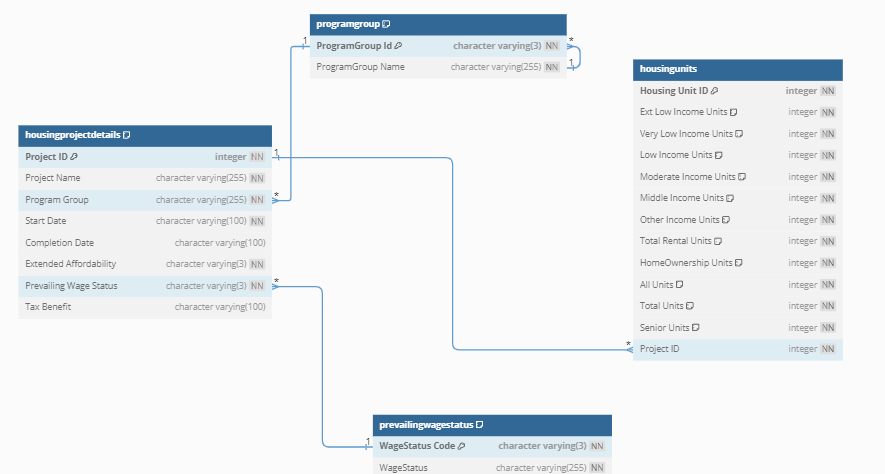

### Importing Data into Postgres Database HousingPrediction
Establishing connection between Python and Postgres

In [27]:
# Connecting to the local PostgreSQL database 'HousingPrediction'
conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")

#### Inserting into programgroup table

In [28]:
# Creating a dictionary to map abbreviations to full names of various housing program groups.
dtProgramGroup = {'MIP':'Multifamily Incentives Program', 'HAP':'Homeowner Assistance Program',
                  'MFP':'Multifamily Finance Program', 'SHP' : 'Small Homes Program'}

In [29]:
# Loop through the dictionary 'dtProgramGroup', extract each key-value pair
for key, value in dtProgramGroup.items():
    lst = [key, value]
    # print the list
    print(lst)

['MIP', 'Multifamily Incentives Program']
['HAP', 'Homeowner Assistance Program']
['MFP', 'Multifamily Finance Program']
['SHP', 'Small Homes Program']


In [30]:
lstPrgmGrpColmnNames = ['ProgramGroup Id', 'ProgramGroup Name']

In [31]:
# Setting the table name 
table_name = 'programgroup'

# Establishing a connection to the local PostgreSQL database 'HousingPrediction' 
conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password"
)
# Creating a cursor object using the connection 
cursor = conn.cursor()

# Iterate through each item in the dictionary 'dtProgramGroup'
for key, value in dtProgramGroup.items():
    # Creating an SQL insertion query 
    # The query inserts data into the 'programgroup' table
    insert_query = sql.SQL('INSERT INTO {} ({}) VALUES ({})').format(
        sql.Identifier(table_name), 
        sql.SQL(', ').join(map(sql.Identifier, lstPrgmGrpColmnNames)), 
        sql.SQL(', ').join(sql.Placeholder() * len(lstPrgmGrpColmnNames))  
    )

    values_list = [key, value]  
    # Executing the insertion command with the values.
    cursor.execute(insert_query, values_list)

# Commit the changes to the database
conn.commit()
# Close the cursor and connection 
cursor.close()
conn.close()

print("ProgramGroup Details got inserted successfully")

ProgramGroup Details got inserted successfully


#### Inserting into prevailingwagestatus table

In [32]:
df_combined["Prevailing Wage Status"].value_counts()

Prevailing Wage Status
Non Prevailing Wage    4249
Prevailing Wage          92
Name: count, dtype: int64

In [33]:
dtPrevailingWage = {'NPW':'Non Prevailing Wage', 'PW':'Prevailing Wage'}                  

In [34]:
lstPrevlngWageColmnNames = ['WageStatus Code', 'WageStatus']

In [35]:
table_name = 'prevailingwagestatus'

conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")
cursor = conn.cursor()

# Iterate through the DataFrame rows and insert into the PostgreSQL table
for key, value in dtPrevailingWage.items():
    # Create an SQL query for insertion
    insert_query = sql.SQL('INSERT INTO {} ({}) VALUES ({})').format(
        sql.Identifier(table_name),
        sql.SQL(', ').join(map(sql.Identifier, lstPrevlngWageColmnNames)),
        sql.SQL(', ').join(sql.Placeholder() * len(lstPrevlngWageColmnNames))
    )

    values_list = [key, value]       
    # Execute the query
    cursor.execute(insert_query, values_list)
    
# Commit the changes and close the connection
conn.commit()
cursor.close()
conn.close()

print("Prevailing Wage Details got inserted successfully")

Prevailing Wage Details got inserted successfully


#### Inserting into housingprojectdetails table

In [35]:
lstPrjtDtlsColNames = ['Project ID', 'Project Name', 'Program Group', 'Start Date', 'Completion Date', 
                       'Extended Affordability', 'Prevailing Wage Status', 'Tax Benefit']

In [36]:
# Replacing the names in the 'Program Group' with their corresponding values and keys
df_combined['Program Group'].replace(list(dtProgramGroup.values()), list(dtProgramGroup.keys()), inplace=True)

In [37]:
df_combined['Program Group'].value_counts()

Program Group
MIP    1896
HAP    1452
MFP     955
SHP      38
Name: count, dtype: int64

In [38]:
# Replacing the names in the 'Prevailing Wage Status' with their corresponding values and keys
df_combined['Prevailing Wage Status'].replace(list(dtPrevailingWage.values()), list(dtPrevailingWage.keys()), inplace=True)

In [39]:
list(dtProgramGroup.keys())

['MIP', 'HAP', 'MFP', 'SHP']

In [40]:
df_combined.head()

Project ID  Project Name Program Group  Start Date Completion Date  \
0       55759  CONFIDENTIAL           HAP  01/03/2014      01/03/2014   
1       55647  CONFIDENTIAL           HAP  01/07/2014      01/07/2014   
2       55773  CONFIDENTIAL           HAP  01/10/2014      01/10/2014   
3       57341  CONFIDENTIAL           HAP  01/10/2014      01/10/2014   
4       55697  CONFIDENTIAL           HAP  01/14/2014      01/14/2014   

  Extended Affordability Prevailing Wage Status Tax Benefit  \
0                     No                    NPW         NaN   
1                     No                    NPW         NaN   
2                     No                    NPW         NaN   
3                     No                    NPW         NaN   
4                     No                    NPW         NaN   

   Ext Low Income Units  Very Low Income Units  Low Income Units  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 1   
4                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

In [44]:
table_name = 'housingprojectdetails'

conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")
cursor = conn.cursor()

# Iterate through the DataFrame rows and insert into the PostgreSQL table
for index, row in df_combined.iterrows():
    # Create an SQL query for insertion
    insert_query = sql.SQL('INSERT INTO {} ({}) VALUES ({})').format(
        sql.Identifier(table_name),
        sql.SQL(', ').join(map(sql.Identifier, lstPrjtDtlsColNames)),
        sql.SQL(', ').join(sql.Placeholder() * len(lstPrjtDtlsColNames))
    )

    values_list = [row[col] for col in lstPrjtDtlsColNames]    
    # Execute the query
    cursor.execute(insert_query, values_list)
    
# Commit the changes and close the connection
conn.commit()
cursor.close()
conn.close()

print("Project Details got inserted successfully")

Project Details got inserted successfully


#### Inserting into housingunits table

In [41]:
lstHousingUnits = ['Project ID', 'Ext Low Income Units', 'Very Low Income Units', 'Low Income Units', 'Moderate Income Units',
                  'Middle Income Units', 'Other Income Units', 'Total Rental Units', 'HomeOwnership Units', 
                  'All Units', 'Total Units', 'Senior Units']

In [46]:
table_name = 'housingunits'

conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")
cursor = conn.cursor()

# Iterate through the DataFrame rows and insert into the PostgreSQL table
for index, row in df_combined.iterrows():
    # Create an SQL query for insertion
    insert_query = sql.SQL('INSERT INTO {} ({}) VALUES ({})').format(
        sql.Identifier(table_name),
        sql.SQL(', ').join(map(sql.Identifier, lstHousingUnits)),
        sql.SQL(', ').join(sql.Placeholder() * len(lstHousingUnits))
    )

    values_list = [row[col] for col in lstHousingUnits]    
    # Execute the query
    cursor.execute(insert_query, values_list)
    
# Commit the changes and close the connection
conn.commit()
cursor.close()
conn.close()

print("Housing Units got inserted successfully")

Housing Units got inserted successfully


### Importing Data from Postgres HousingPrediction Database into Dataframe in Python

#### Importing Data from housingprojectdetails to dfProjectDetails Dataframe

In [42]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    host="localhost",  
    database="HousingPrediction", 
    user="postgres", 
    password="your_password"  
)

# Execute a SQL query to fetch data from the "housingprojectdetails" table
dfProjectDetails = pd.read_sql_query("""SELECT * FROM "housingprojectdetails" """, conn)

# Close the connection to the PostgreSQL database 
conn.close()


In [43]:
dfProjectDetails.head()

Project ID  Project Name Program Group  Start Date Completion Date  \
0       55759  CONFIDENTIAL           HAP  01/03/2014      01/03/2014   
1       55647  CONFIDENTIAL           HAP  01/07/2014      01/07/2014   
2       55773  CONFIDENTIAL           HAP  01/10/2014      01/10/2014   
3       57341  CONFIDENTIAL           HAP  01/10/2014      01/10/2014   
4       55697  CONFIDENTIAL           HAP  01/14/2014      01/14/2014   

  Extended Affordability Prevailing Wage Status Tax Benefit  
0                     No                    NPW         NaN  
1                     No                    NPW         NaN  
2                     No                    NPW         NaN  
3                     No                    NPW         NaN  
4                     No                    NPW         NaN

#### Importing Data from housingunits to dfhousingunits Dataframe

In [45]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")
# Execute a SQL query to fetch data from the "housingunits" table
dfhousingunits = pd.read_sql_query("""SELECT * FROM "housingunits" """, conn)

# Close the connection to the PostgreSQL database 
conn.close()

In [93]:
dfhousingunits.head()

Project ID  Ext Low Income Units  Very Low Income Units  Low Income Units  \
0       55759                     0                      0                 0   
1       55647                     0                      0                 0   
2       55773                     0                      0                 0   
3       57341                     0                      0                 1   
4       55697                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

#### Importing Data from prevailingwagestatus to dfPrevailingWageStatus Dataframe

In [94]:
conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")

dfPrevailingWageStatus = pd.read_sql_query("""SELECT * FROM "prevailingwagestatus" """, conn)

conn.close()

In [96]:
dfPrevailingWageStatus.head()

WageStatus Code           WageStatus
0             NPW  Non Prevailing Wage
1              PW      Prevailing Wage

#### Importing Data from programgroup to dfProgramGroup Dataframe

In [98]:
conn = psycopg2.connect(
    host="localhost",
    database="HousingPrediction",
    user="postgres",
    password="your_password")

dfProgramGroup = pd.read_sql_query("""SELECT * FROM "programgroup" """, conn)

conn.close()

In [99]:
dfProgramGroup.head()

ProgramGroup Id               ProgramGroup Name
0             MIP  Multifamily Incentives Program
1             HAP    Homeowner Assistance Program
2             MFP     Multifamily Finance Program
3             SHP             Small Homes Program

#### Merging dfProjectDetails and dfhousingunits DataFrames

In [47]:
# Using an inner join to include only the rows with matching 'Project ID' values in both DataFrames
merged_df = pd.merge(dfProjectDetails, dfhousingunits, on='Project ID', how='inner')

In [91]:
merged_df.head()

Project ID  Project Name Program Group Start Date Completion Date  \
0       55759  CONFIDENTIAL           HAP 2014-01-03      01/03/2014   
1       55647  CONFIDENTIAL           HAP 2014-01-07      01/07/2014   
2       55773  CONFIDENTIAL           HAP 2014-01-10      01/10/2014   
3       57341  CONFIDENTIAL           HAP 2014-01-10      01/10/2014   
4       55697  CONFIDENTIAL           HAP 2014-01-14      01/14/2014   

  Extended Affordability Prevailing Wage Status Tax Benefit  \
0                     No                    NPW         NaN   
1                     No                    NPW         NaN   
2                     No                    NPW         NaN   
3                     No                    NPW         NaN   
4                     No                    NPW         NaN   

   Ext Low Income Units  Very Low Income Units  Low Income Units  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 1   
4                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

##### Replacing Prevailing Wage Status and Program Group values from the values obtained from Postgres tables

In [100]:
merged_df['Prevailing Wage Status'].replace(dict(zip(dfPrevailingWageStatus['WageStatus Code'], dfPrevailingWageStatus['WageStatus'])), inplace=True)

In [101]:
merged_df['Program Group'].replace(dict(zip(dfProgramGroup['ProgramGroup Id'], dfProgramGroup['ProgramGroup Name'])), inplace=True)

In [102]:
merged_df.head()

Project ID  Project Name                 Program Group Start Date  \
0       55759  CONFIDENTIAL  Homeowner Assistance Program 2014-01-03   
1       55647  CONFIDENTIAL  Homeowner Assistance Program 2014-01-07   
2       55773  CONFIDENTIAL  Homeowner Assistance Program 2014-01-10   
3       57341  CONFIDENTIAL  Homeowner Assistance Program 2014-01-10   
4       55697  CONFIDENTIAL  Homeowner Assistance Program 2014-01-14   

  Completion Date Extended Affordability Prevailing Wage Status Tax Benefit  \
0      01/03/2014                     No    Non Prevailing Wage         NaN   
1      01/07/2014                     No    Non Prevailing Wage         NaN   
2      01/10/2014                     No    Non Prevailing Wage         NaN   
3      01/10/2014                     No    Non Prevailing Wage         NaN   
4      01/14/2014                     No    Non Prevailing Wage         NaN   

   Ext Low Income Units  Very Low Income Units  Low Income Units  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 1   
4                     0                      0                 0   

   Moderate Income Units  Middle Income Units  Other Income Units  \
0                      0                    1                   0   
1                      0                    1                   0   
2                      0                    1                   0   
3                      0                    0                   0   
4                      0                    1                   0   

   Total Rental Units  HomeOwnership Units  All Units  Total Units  \
0                   0                    1          1            1   
1                   0                    1          1            1   
2                   0                    1          1            1   
3                   0                    1          1            1   
4                   0                    1          1            1   

   Senior Units  
0             0  
1             0  
2             0  
3             0  
4             0

### Checking for Missing Values

In [49]:
# Display the number of missing values in each column of the merged DataFrame.
merged_df.isna().sum()

Project ID                0
Project Name              0
Program Group             0
Start Date                0
Completion Date           0
Extended Affordability    0
Prevailing Wage Status    0
Tax Benefit               0
Ext Low Income Units      0
Very Low Income Units     0
Low Income Units          0
Moderate Income Units     0
Middle Income Units       0
Other Income Units        0
Total Rental Units        0
HomeOwnership Units       0
All Units                 0
Total Units               0
Senior Units              0
dtype: int64

#### Checking for missing values with 'NaN' and 'N/A'

In [50]:
# Initializing an empty list to store the names of columns with missing values.
lstMissingColumns = []

# Iterating over each column in the DataFrame 
for columnName in merged_df.columns:
    # Checking if any value in the current column is 'N/A' or 'NaN'.
    if (merged_df[columnName] == 'N/A').any() or (merged_df[columnName] == 'NaN').any():
        # If missing values are found, append the column name 
        lstMissingColumns.append(columnName)
        
lstMissingColumns

['Completion Date', 'Tax Benefit']

* The above result states there are two columns Completion Date and Tax Benefit with missing values in merged_df Dataframe.
* Let us check with value_counts() for the type of values in these columns

In [53]:
merged_df["Completion Date"].value_counts() 

Completion Date
NaN                        974
06/30/2021                  26
2023-12-27T00:00:00.000     13
10/31/2017                  12
07/23/2021                  11
                          ... 
09/13/2018                   1
09/06/2018                   1
08/31/2018                   1
08/21/2018                   1
07/03/2019                   1
Name: count, Length: 1695, dtype: int64

In [54]:
merged_df["Tax Benefit"].value_counts() 

Tax Benefit
421a             1794
NaN              1582
420c              422
Article XI        411
Article II         36
J-51 Enriched      36
J-51               17
Article V          16
UDAAP              14
420a               11
Article IV          2
Name: count, dtype: int64

## Exploratory Data Analysis

### Univariate Analysis

* Project ID and Project Name are unique columns. Hence we donot perform any Univariate analysis on these two columns.

#### Numerical Analysis

In [65]:
#descriptive statistics of dataframe merged_df
merged_df.describe()

Project ID  Ext Low Income Units  Very Low Income Units  \
count   4341.000000           4341.000000            4341.000000   
mean   66358.497812              9.762267              16.248100   
std     7211.756557             38.915674             208.618535   
min    44218.000000              0.000000               0.000000   
25%    61799.000000              0.000000               0.000000   
50%    68602.000000              0.000000               0.000000   
75%    72094.000000              0.000000               0.000000   
max    75013.000000            572.000000           11413.000000   

       Low Income Units  Moderate Income Units  Middle Income Units  \
count       4341.000000            4341.000000          4341.000000   
mean          20.507947               3.621516             6.904170   
std           99.445952              27.074361            72.824478   
min            0.000000               0.000000             0.000000   
25%            0.000000               0.000000             0.000000   
50%            1.000000               0.000000             0.000000   
75%            7.000000               0.000000             3.000000   
max         3959.000000             716.000000          4505.000000   

       Other Income Units  Total Rental Units  HomeOwnership Units  \
count         4341.000000         4341.000000          4341.000000   
mean             0.246948           44.549873            12.741073   
std              0.752457          156.695400           264.751970   
min              0.000000            0.000000             0.000000   
25%              0.000000            0.000000             0.000000   
50%              0.000000            4.000000             0.000000   
75%              0.000000           37.000000             1.000000   
max             11.000000         5881.000000         15372.000000   

          All Units   Total Units  Senior Units  
count   4341.000000   4341.000000   4341.000000  
mean      57.290947     77.745450      3.721262  
std      305.815635    317.669505     20.688120  
min        1.000000      1.000000      0.000000  
25%        1.000000      1.000000      0.000000  
50%        6.000000     15.000000      0.000000  
75%       44.000000     71.000000      0.000000  
max    15372.000000  15372.000000    291.000000

#### EDA for Ext Low Income Units column

<Axes: xlabel='Ext Low Income Units', ylabel='Density'>

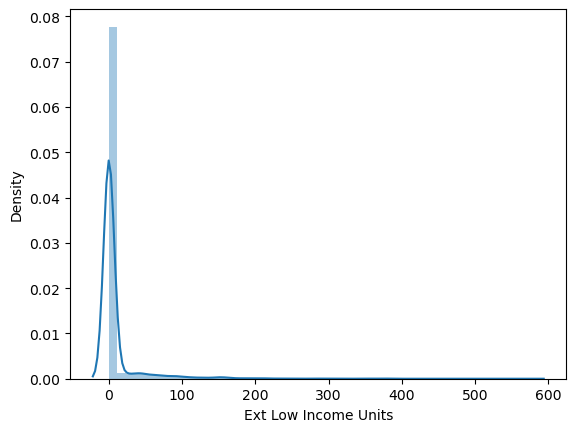

In [55]:
# Plotting a distribution plot (histogram) of the 'Ext Low Income Units' column
sns.distplot(merged_df["Ext Low Income Units"], kde=True)

The graph shows a positively skewed distribution of "Ext Low Income Units", indicating that most projects have few such units, with a peak near zero. This suggests limited availability or priority given to extremely low-income housing. A few outliers indicate some projects offer significantly more of these units, likely due to specific funding or policy support. This could signal a need to adjust housing strategies or funding allocations to address disparities in extremely low-income housing availability.

<AxesSubplot:>

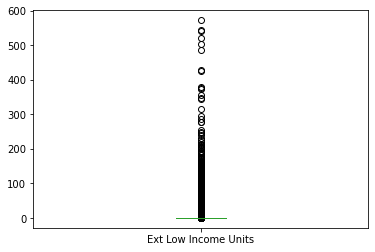

In [68]:
# box plot of Ext Low Income Units
merged_df["Ext Low Income Units"].plot(kind='box')

The graph depicts a striking concentration of projects with zero "Ext Low Income Units," illustrated by the dense cluster at the base, and a few projects with substantially more units, as shown by the sparse outliers.

<AxesSubplot:>

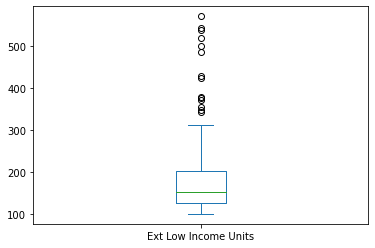

In [69]:
# box plot of Ext Low Income Units
merged_df[merged_df["Ext Low Income Units"] > 100]["Ext Low Income Units"].plot(kind='box')

The boxplot illustrates the distribution of "Ext Low Income Units" with a low median, significant skew, and numerous outliers, indicating that few projects have high number of such units.

In [60]:
# Converting Start Date column to DateTime to perform analysis on the hosuing units
merged_df['Start Date'] = pd.to_datetime(merged_df['Start Date'], format='mixed')

In [62]:
merged_df[merged_df["Ext Low Income Units"] > 500].sort_values(by='Start Date')

Project ID                     Project Name Program Group Start Date  \
468        52721             Morrisania Portfolio           MFP 2014-12-18   
1292       58792    KINGS BAY HOUSING CO. INC. II           MFP 2016-06-15   
2894       65227      DIEGO BEEKMAN MHA.GHPP.FY18           MFP 2018-06-26   
1532       65392          TAINO TOWERS.HUDMF.FY19           MFP 2019-06-27   
3945       70493  TAINO TOWERS PHASE 3.HUDMF.FY23           MFP 2023-06-23   

     Completion Date Extended Affordability Prevailing Wage Status  \
468       12/17/2015                     No                    NPW   
1292      11/19/2018                     No                    NPW   
2894             NaN                     No                    NPW   
1532      06/27/2019                    Yes                    NPW   
3945             NaN                     No                    NPW   

     Tax Benefit  Ext Low Income Units  Very Low Income Units  \
468   Article XI                   545                     72   
1292         NaN                   540                      0   
2894         NaN                   572                    180   
1532  Article XI                   520                     91   
3945  Article XI                   502                     86   

      Low Income Units  Moderate Income Units  Middle Income Units  \
468                 39                      9                    0   
1292                 0                      0                    0   
2894               429                     29                    0   
1532                35                      7                    2   
3945                39                      1                   26   

      Other Income Units  Total Rental Units  HomeOwnership Units  All Units  \
468                   11                 668                    8        676   
1292                   0                   0                  540        540   
2894                   0                1210                    0       1210   
1532                   1                 656                    0        656   
3945                   2                 656                    0        656   

      Total Units  Senior Units  
468           676             0  
1292          540             0  
2894         1210             0  
1532          656             0  
3945          656            49

* The above result indicates there were only four projects which had Extremely Low Income Units more than 500

#### EDA for Very Low Income Units column

<AxesSubplot:xlabel='Very Low Income Units', ylabel='Density'>

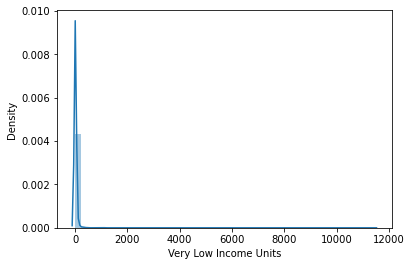

In [71]:
# Plotting a distribution plot (histogram) of the 'very Low Income Units' column
sns.distplot(merged_df["Very Low Income Units"], kde=True)

The density plot for "Very Low Income Units" shows a pronounced peak near zero, indicating that most projects have very few such units, with negligible occurrences of higher values.

<AxesSubplot:>

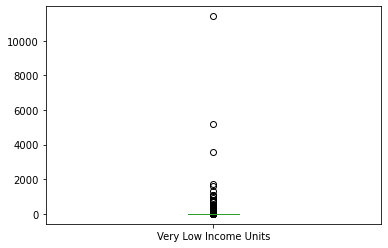

In [72]:
# box plot of very Low Income Units
merged_df["Very Low Income Units"].plot(kind='box')

The boxplot for "Very Low Income Units" highlights a majority of values clustered near zero with a median close to zero, indicating few such units per project, alongside several outliers suggesting a small number of projects with notably higher counts.

<AxesSubplot:>

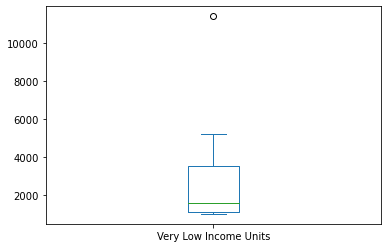

In [73]:
# box plot of very Low Income Units
merged_df[merged_df["Very Low Income Units"] > 1000]["Very Low Income Units"].plot(kind='box')

The boxplot of "Very Low Income Units" displays a moderate range with some projects containing between approximately 1000 and 4000 units. The outliers suggest a few projects exceed typical values, with one notable outlier surpassing 8000 units.

#### EDA for Low Income Units column

<AxesSubplot:xlabel='Low Income Units', ylabel='Density'>

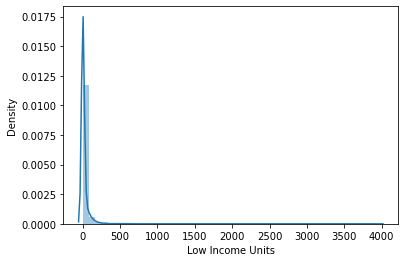

In [75]:
# Plotting a distribution plot (histogram) of the 'Low Income Units' column
sns.distplot(merged_df["Low Income Units"], kde=True)

The density plot for "Low Income Units" shows a high peak near zero, indicating that most projects contain only a few low-income units. The rapid decline in density suggests that projects with higher numbers of these units are very rare.

<AxesSubplot:>

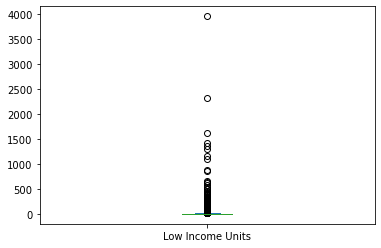

In [76]:
# box plot of Low Income Units
merged_df["Low Income Units"].plot(kind='box')

The boxplot for "Low Income Units" illustrates a majority of projects having a modest number of such units, with a median below 1000. There are a few outliers showing projects with significantly higher numbers, reaching up to 3000 units.

<AxesSubplot:>

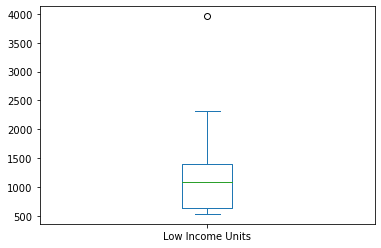

In [77]:
# box plot of Low Income Units where units greater than 500
merged_df[merged_df["Low Income Units"] > 500]["Low Income Units"].plot(kind='box')

The boxplot of "Low Income Units" displays a moderate range with some projects containing units approximately between 500 and 4000 units. The outliers suggest a few projects exceed typical values, with one notable outlier surpassing 2000 units.

In [63]:
merged_df[merged_df["Low Income Units"] > 500].sort_values(by='Start Date')

Project ID                                 Project Name Program Group  \
168        52411                              Twin Parks S.W.           MIP   
2023       58513          Marcus Garvey Apartments (20140295)           MIP   
690        55428                              NYCHA Section 8           MFP   
476        59688                              Riverton Square           MFP   
689        63373  Arverne View Apartments (AKA Ocean Village)           MFP   
834        65189                         47TH AVE - "BIG SIX"           MFP   
1577       61849                       TRACEY TOWERS.HRP.FY18           MFP   
1117       67403                                STARRETT CITY           MIP   
2817       49533                        LINDSAY PARK.HRP.FY18           MFP   
1671       69118                        KNICKERBOCKER VILLAGE           MIP   
2967       68432       LINDEN PLAZA PRESERVATION LP.YR15.FY20           MFP   
2969       68530                           COOP CITY.HRP.FY20           MFP   
2749       69877              CONCOURSE VILLAGE, INC.HRP.FY21           MFP   
3070       70652                    ROCHDALE VILLAGE.HRP.FY21           MFP   
3984       73500               FLATBUSH GARDENS HDFC.HPO.FY23           MFP   

     Start Date Completion Date Extended Affordability Prevailing Wage Status  \
168  2014-06-26      06/30/2014                    Yes                    NPW   
2023 2014-12-16      12/30/2020                     No                    NPW   
690  2014-12-23      12/22/2016                     No                    NPW   
476  2016-01-05      01/05/2016                    Yes                    NPW   
689  2016-12-21      12/21/2016                    Yes                     PW   
834  2017-06-30      06/30/2017                     No                    NPW   
1577 2017-12-20      08/14/2019                     No                    NPW   
1117 2018-05-25      05/25/2018                    Yes                    NPW   
2817 2018-11-26             NaN                     No                    NPW   
1671 2019-10-30      10/30/2019                    Yes                    NPW   
2967 2019-12-27             NaN                     No                    NPW   
2969 2020-03-30             NaN                     No                    NPW   
2749 2020-12-01      06/13/2023                     No                    NPW   
3070 2021-06-28             NaN                     No                    NPW   
3984 2023-06-29             NaN                     No                    NPW   

     Tax Benefit  Ext Low Income Units  Very Low Income Units  \
168   Article XI                     0                      0   
2023  Article II                     0                      0   
690         420c                     0                      0   
476   Article XI                     0                      0   
689   Article II                     0                      0   
834   Article XI                     0                    393   
1577         NaN                     0                      0   
1117   Article V                     0                   3569   
2817         NaN                     0                   1088   
1671  Article IV                     0                      0   
2967        J-51                     6                    228   
2969  Article II                     0                  11413   
2749         NaN                     0                    506   
3070         NaN                    13                   5213   
3984  Article XI                     9                    748   

      Low Income Units  Moderate Income Units  Middle Income Units  \
168                536                      0                    0   
2023               623                      0                    0   
690                873                      0                    0   
476                650                      0                  325   
689               1093                      0        

* From the above results we can infer that there was atmost one project in every year with Low Income Units more than 500.

#### EDA for Moderate Income Units column

<AxesSubplot:xlabel='Moderate Income Units', ylabel='Density'>

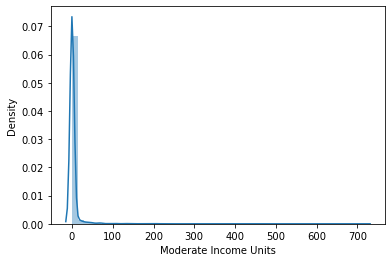

In [79]:
# Plotting a distribution plot (histogram) of the 'Moderate Income Units' column
sns.distplot(merged_df["Moderate Income Units"], kde=True)

The density plot for "Moderate Income Units" shows an extremely sharp peak near zero, indicating that the vast majority of projects contain very few moderate-income units, with almost negligible instances of higher unit counts.

<AxesSubplot:>

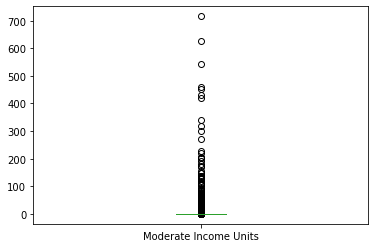

In [80]:
# box plot of Moderate Low Income Units
merged_df["Moderate Income Units"].plot(kind='box')

The boxplot for "Moderate Income Units" shows most projects having few units, with a median close to zero. Several outliers indicate a minority of projects offer substantially more moderate-income units.

<AxesSubplot:>

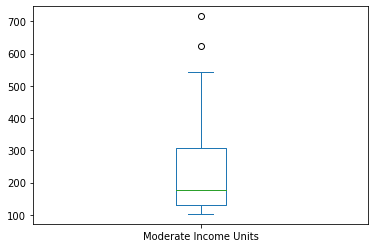

In [81]:
# box plot of Moderate Low Income Units where units greater than 100
merged_df[merged_df["Moderate Income Units"] > 100]["Moderate Income Units"].plot(kind='box')

The boxplot for "Moderate Income Units" displays a median just over 100, with few projects containing up to 300 units. A few outliers highlight projects with up to 700 moderate-income units.

In [64]:
# box plot of Moderate Low Income Units where units greater than 200
merged_df[merged_df["Moderate Income Units"] > 200].sort_values(by='Start Date')

Project ID                                     Project Name  \
1018       51396                  RIVERBEND HOUSING COMPANY, INC.   
903        59834                                     Kelly Towers   
488        60080                            Atlantic Plaza Towers   
765        63839                                       PENN SOUTH   
978        65361                                711 SEA GIRT HDFC   
2681       63777                                       APEX PLACE   
1654       68660               RIVER CROSSING OWNER HDFC.HPO.FY20   
1656       68662               MILES & PARKER OWNER HDFC.HPO.FY20   
1671       69118                            KNICKERBOCKER VILLAGE   
2600       66970              HUNTERS POINT SOUTH PARCELS F AND G   
2626       69355                                 GOODWILL TERRACE   
2194       69490  HP MORNINGSIDE HEIGHTS PORTFOLIO HDFC.YR15.FY21   
3437       73522                                    3333-BROADWAY   
3984       73500                   FLATBUSH GARDENS HDFC.HPO.FY23   
4038       71424       BUFF 236-1 DEVELOPMENT ASSOCIATES.HPO.FY23   
4247       67995                 WILLETS POINT PHASE I BLDG 1 & 2   

     Program Group Start Date          Completion Date Extended Affordability  \
1018           MFP 2015-06-24               01/09/2018                     No   
903            MFP 2015-12-30               09/27/2017                     No   
488            MIP 2016-01-29               01/29/2016                    Yes   
765            MIP 2017-04-27               04/27/2017                    Yes   
978            MIP 2017-11-21               11/21/2017                    Yes   
2681           MFP 2019-06-26               01/30/2023                     No   
1654           MFP 2019-10-23               10/23/2019                    Yes   
1656           MFP 2019-10-23               10/23/2019                    Yes   
1671           MIP 2019-10-30               10/30/2019                    Yes   
2600           MFP 2019-12-20               09/20/2022                     No   
2626           MFP 2019-12-23               10/26/2022                     No   
2194           MFP 2020-10-16               07/14/2021                     No   
3437           MFP 2022-06-30  2022-06-30T00:00:00.000                    Yes   
3984           MFP 2023-06-29                      NaN                     No   
4038           MFP 2023-07-25                      NaN                     No   
4247           MFP 2023-11-22                      NaN                     No   

     Prevailing Wage Status Tax Benefit  Ext Low Income Units  \
1018                    NPW         NaN                     0   
903                     NPW  Article II                     0   
488                     NPW  Article XI                     0   
765                     NPW   Article V                   424   
978                     NPW  Article XI                     7   
2681                    NPW  Article XI                    44   
1654                    NPW  Article XI                     0   
1656                    NPW  Article XI                     0   
1671                    NPW  Article IV                     0   
2600                    NPW  Article XI                   170   
2626                    NPW         NaN                     0   
2194                    NPW  Article XI                   210   
3437                    NPW  Article XI                     0   
3984                    NPW  Article XI                     9   
4038                    NPW  Article XI                    14   
4247                    NPW  Article XI                   193   

      Very Low Income Units  Low Income Units  Moderate Income Units  \
1018                      0                 0                    625   
903                       0                 0                    302   
488                       0                 0                    716   
765                     380               388               

* Projects with Moderate Income Units more than 200 only started from 2015 and there was atmost one such project in a year.

#### EDA for Middle Income Units column

<AxesSubplot:xlabel='Middle Income Units', ylabel='Density'>

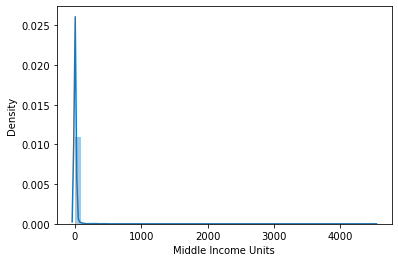

In [83]:
# Plotting a distribution plot (histogram) of the 'Middle Income Units' column
sns.distplot(merged_df["Middle Income Units"], kde=True)

The density plot for "Middle Income Units" shows an extremely concentrated peak near zero, indicating that the vast majority of projects include very few or no middle-income units. This suggests a limited focus on this income bracket in housing projects.

<AxesSubplot:>

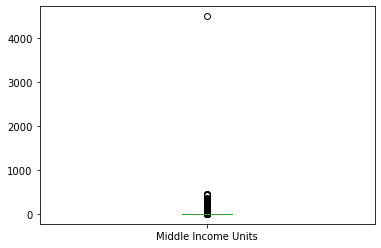

In [84]:
# box plot of Middle Income Units
merged_df["Middle Income Units"].plot(kind='box')

The boxplot for "Middle Income Units" reveals a very low median near zero, showing that most projects have minimal such units. The presence of outliers indicates a few projects provide significantly more middle-income units, albeit rarely.

<AxesSubplot:>

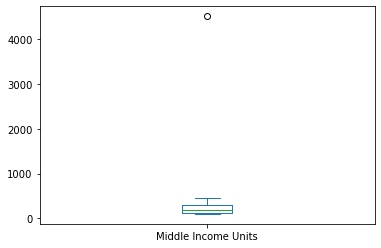

In [85]:
# box plot of Middle Income Units where units greater than 100
merged_df[merged_df["Middle Income Units"] > 100]["Middle Income Units"].plot(kind='box')

The boxplot for "Middle Income Units" displays a broad range with a median around 2000 units. The majority of projects offer up to 4000 units, with a notable outlier indicating some projects exceed this significantly.

In [66]:
# box plot of Middle Income Units where units greater than 100
merged_df[merged_df["Middle Income Units"] > 500].sort_values(by='Start Date')

Project ID                    Project Name Program Group Start Date  \
472       59857  Stuy Town Peter Cooper Village           MFP 2015-12-18   

    Completion Date Extended Affordability Prevailing Wage Status Tax Benefit  \
472      12/18/2015                    Yes                    NPW         NaN   

     Ext Low Income Units  Very Low Income Units  Low Income Units  \
472                     0                      0               495   

     Moderate Income Units  Middle Income Units  Other Income Units  \
472                      0                 4505                   0   

     Total Rental Units  HomeOwnership Units  All Units  Total Units  \
472                5000                    0       5000         5000   

     Senior Units  
472             0

* The above result signifies that the project Stuy Town Peter Cooper Village was exclusively focused on procuring Middle Income Units. The number of units incorporated are more than 4500.

#### EDA for Other Income Units column

In [87]:
merged_df["Other Income Units"].describe()

count    4341.000000
mean        0.246948
std         0.752457
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: Other Income Units, dtype: float64

<AxesSubplot:xlabel='Other Income Units', ylabel='Density'>

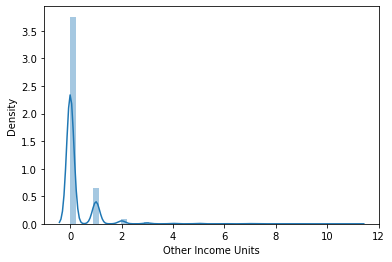

In [88]:
# Plotting a distribution plot (histogram) of the 'Other Income Units' column
sns.distplot(merged_df["Other Income Units"], kde=True)

The density plot for "Other Income Units" illustrates a peak at zero, suggesting that most projects have few to no such units. The negligible density beyond this point indicates that higher values are extremely rare.

<AxesSubplot:>

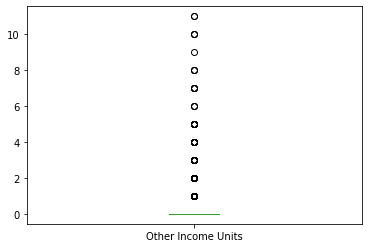

In [89]:
# box plot of other Income Units
merged_df["Other Income Units"].plot(kind='box')

The box plot shows most "Other Income Units" counts close to zero with a few sparse data points up to 10, highlighting minimal usage of this category in projects.

<AxesSubplot:>

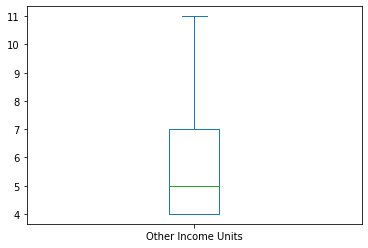

In [90]:
# box plot of other Income Units where units greater than 3
merged_df[merged_df["Other Income Units"] > 3]["Other Income Units"].plot(kind='box')

This box plot depicts minimal variation in "Other Income Units," with a compact box and outliers up to 10, reinforcing the rarity of these units in projects.

#### EDA for Total Rental Units column

<Axes: xlabel='Total Rental Units', ylabel='Density'>

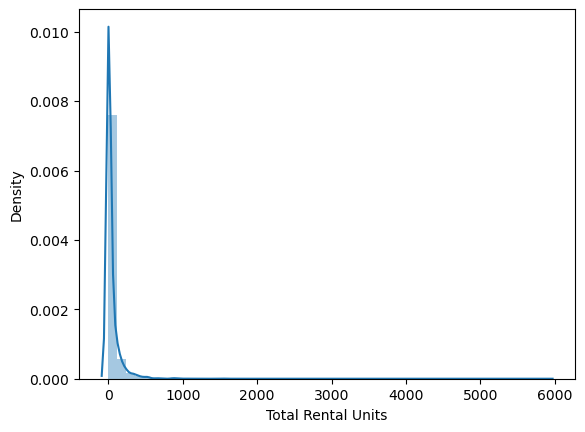

In [67]:
# Plotting a distribution plot (histogram) of the 'Total Rental Units' column
sns.distplot(merged_df["Total Rental Units"], kde=True)

The density plot for "Total Rental Units" demonstrates a significant concentration of values near zero, indicating a strong tendency towards fewer rental units in most projects.

<Axes: >

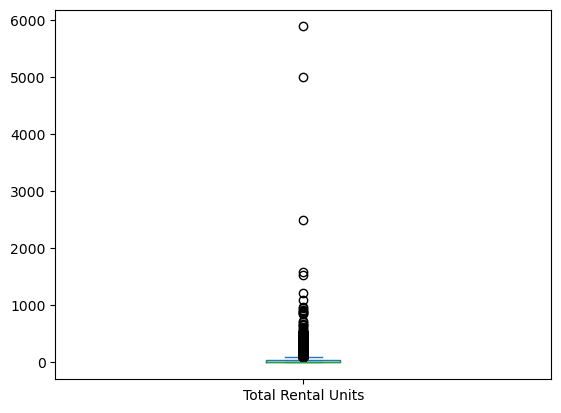

In [68]:
# box plot of Total Rental Units Income Units
merged_df["Total Rental Units"].plot(kind='box')

The box plot of "Total Rental Units" shows a range predominantly below 2000 units with a few extreme outliers, suggesting most projects are small to medium-sized in scope.

<Axes: >

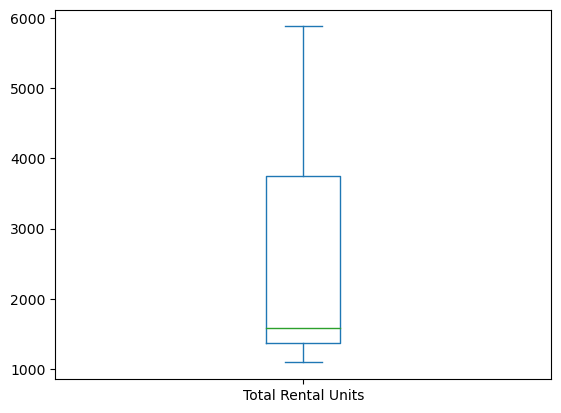

In [69]:
# box plot of Total Rental Units where units greater than 1000
merged_df[merged_df["Total Rental Units"] > 1000]["Total Rental Units"].plot(kind='box')

This expanded box plot displays a wider interquartile range, emphasizing a substantial number of projects with up to 4000 rental units and outliers indicating exceptionally large projects.

In [70]:
merged_df[merged_df["Total Rental Units"] > 1000].sort_values(by='Start Date')

Project ID                                 Project Name Program Group  \
472        59857               Stuy Town Peter Cooper Village           MFP   
689        63373  Arverne View Apartments (AKA Ocean Village)           MFP   
1117       67403                                STARRETT CITY           MIP   
2894       65227                  DIEGO BEEKMAN MHA.GHPP.FY18           MFP   
1671       69118                        KNICKERBOCKER VILLAGE           MIP   
2967       68432       LINDEN PLAZA PRESERVATION LP.YR15.FY20           MFP   
3984       73500               FLATBUSH GARDENS HDFC.HPO.FY23           MFP   

     Start Date Completion Date Extended Affordability Prevailing Wage Status  \
472  2015-12-18      12/18/2015                    Yes                    NPW   
689  2016-12-21      12/21/2016                    Yes                     PW   
1117 2018-05-25      05/25/2018                    Yes                    NPW   
2894 2018-06-26             NaN                     No                    NPW   
1671 2019-10-30      10/30/2019                    Yes                    NPW   
2967 2019-12-27             NaN                     No                    NPW   
3984 2023-06-29             NaN                     No                    NPW   

     Tax Benefit  Ext Low Income Units  Very Low Income Units  \
472          NaN                     0                      0   
689   Article II                     0                      0   
1117   Article V                     0                   3569   
2894         NaN                   572                    180   
1671  Article IV                     0                      0   
2967        J-51                     6                    228   
3984  Article XI                     9                    748   

      Low Income Units  Moderate Income Units  Middle Income Units  \
472                495                      0                 4505   
689               1093                      0                    0   
1117              2312                      0                    0   
2894               429                     29                    0   
1671              1159                    431                    0   
2967              1291                      0                    0   
3984              1419                    318                    0   

      Other Income Units  Total Rental Units  HomeOwnership Units  All Units  \
472                    0                5000                    0       5000   
689                    0                1093                    0       1093   
1117                   0                5881                    0       5881   
2894                   0                1210                    0       1210   
1671                   0                1590                    0       1590   
2967                   2                1527                    0       1527   
3984                   0                2494                    0       2494   

      Total Units  Senior Units  
472          5000             0  
689          1093             0  
1117         5881             0  
2894         1210             0  
1671         1590             0  
2967         1527             0  
3984         2494           102

* The above result suggests there was hardly a single project every year which had more than 1000 rental housing units. This has to be addressed by Housing Department.

#### EDA for HomeOwnership Units column

<Axes: xlabel='HomeOwnership Units', ylabel='Density'>

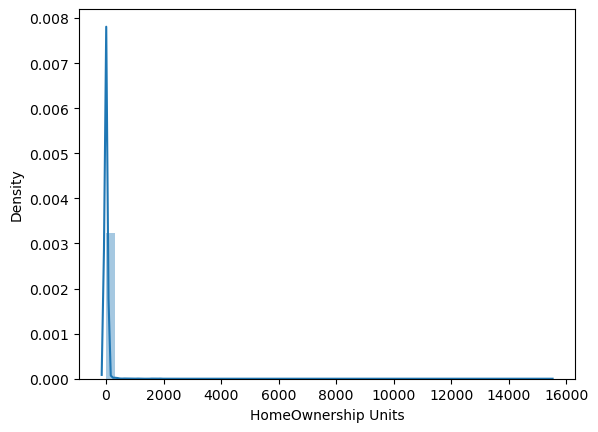

In [71]:
# Plotting a distribution plot (histogram) of the 'Homeownership Units' column
sns.distplot(merged_df["HomeOwnership Units"], kde=True)

The density plot for "HomeOwnership Units" shows most projects have very few such units, with the density sharply decreasing past zero, indicating that these units are uncommon.

<Axes: >

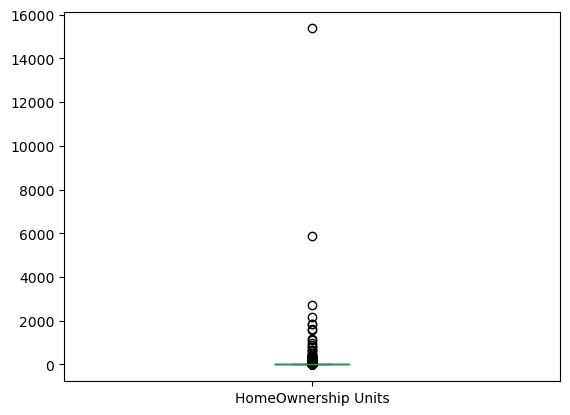

In [72]:
# box plot of HomeOwnership Units
merged_df["HomeOwnership Units"].plot(kind='box')

The box plot for "HomeOwnership Units" reflects a low median close to zero and few high outliers, suggesting that while most projects have few homeownership opportunities, some offer significantly more.

<Axes: >

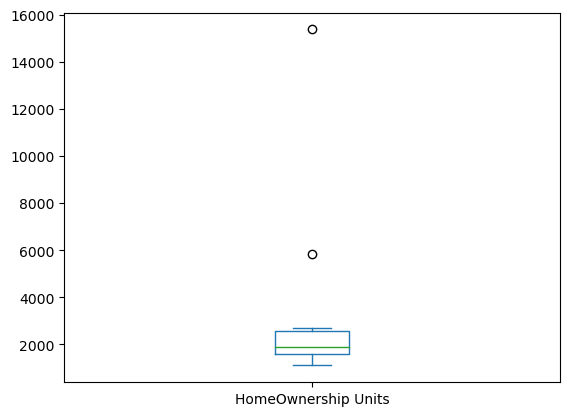

In [73]:
# box plot of Home Ownership Units where units greater than 1000
merged_df[merged_df["HomeOwnership Units"] > 1000]["HomeOwnership Units"].plot(kind='box')

This box plot indicates that while homeownership units are generally low across projects, there are exceptions with significant numbers, reflected by the outliers extending up to 16000 units.

In [74]:
merged_df[merged_df["HomeOwnership Units"] > 1000]

Project ID                             Project Name Program Group  \
765        63839                               PENN SOUTH           MIP   
1917       67427                           MASARYK TOWERS           MFP   
2162       66588                        DAYTON BEACH PARK           MFP   
2749       69877          CONCOURSE VILLAGE, INC.HRP.FY21           MFP   
2815       48885   FRANKLIN PLAZA APARTMENTS INC.HRP.FY18           MFP   
2817       49533                    LINDSAY PARK.HRP.FY18           MFP   
2853       61875               1199 HOUSING CORP.PLP.FY19           MFP   
2940       67577  ESPLANADE GARDENS INCORPORATED.PLP.FY19           MFP   
2969       68530                       COOP CITY.HRP.FY20           MFP   
3070       70652                ROCHDALE VILLAGE.HRP.FY21           MFP   

     Start Date Completion Date Extended Affordability Prevailing Wage Status  \
765  2017-04-27      04/27/2017                    Yes                    NPW   
1917 2018-06-29      06/29/2020                     No                    NPW   
2162 2017-11-28      06/30/2021                     No                    NPW   
2749 2020-12-01      06/13/2023                     No                    NPW   
2815 2018-06-20             NaN                     No                    NPW   
2817 2018-11-26             NaN                     No                    NPW   
2853 2019-06-28             NaN                     No                    NPW   
2940 2018-12-27             NaN                     No                    NPW   
2969 2020-03-30             NaN                     No                    NPW   
3070 2021-06-28             NaN                     No                    NPW   

        Tax Benefit  Ext Low Income Units  Very Low Income Units  \
765       Article V                   424                    380   
1917     Article II                     0                   1107   
2162     Article II                     0                   1029   
2749            NaN                     0                    506   
2815            NaN                     2                   1620   
2817            NaN                     0                   1088   
2853  J-51 Enriched                   277                   1315   
2940           J-51                   124                   1746   
2969     Article II                     0                  11413   
3070            NaN                    13                   5213   

      Low Income Units  Moderate Income Units  Middle Income Units  \
765                388                    542                  455   
1917                 0                      0                    0   
2162               120                      0                    0   
2749              1366                      0                    0   
2815                12                      0                    0   
2817              1614                      0                    0   
2853                 0                      0                    0   
2940                 0                      0                    0   
2969              3959                      0                    0   
3070               634                      0                    0   

      Other Income Units  Total Rental Units  HomeOwnership Units  All Units  \
765                    0                   0                 2189       2189   
1917                   2                   0                 1109       1109   
2162                   0                   0                 1149       1149   
2749                   2                   0                 1874       1874   
2815                   0                   0                 1634       1634   
2817                   7                   0                 2709       2709   
2853                   2                   0                 1594       1594   
2940                   2                   0                 1872       1872   
2969                   0                   0    

* There were only 10 projects which had HomeOwnership Units more than 1000. It needs to be increased to meet the demand of the housing needs.

#### EDA for All Units column

<Axes: xlabel='All Units', ylabel='Density'>

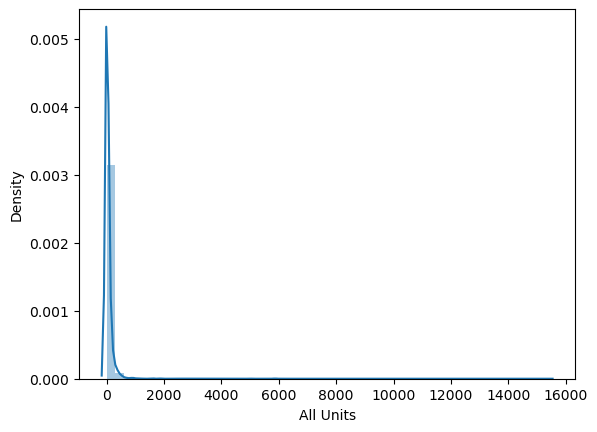

In [75]:
# Plotting a distribution plot (histogram) of the 'All Units' column
sns.distplot(merged_df["All Units"], kde=True)

The density plot for "All Units" shows most projects featuring a small number of total units, with a sharp peak near zero and almost no presence of large projects.

<Axes: >

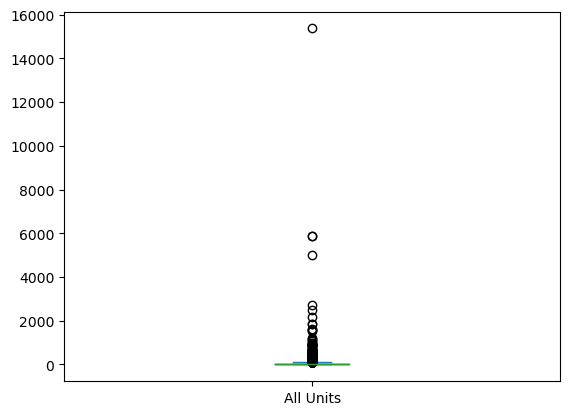

In [76]:
# box plot of All Units
merged_df["All Units"].plot(kind='box')

This box plot shows a significant presence of outliers in the 'All Units' data, indicating the presence of unusually large values well above the main data cluster.

<Axes: >

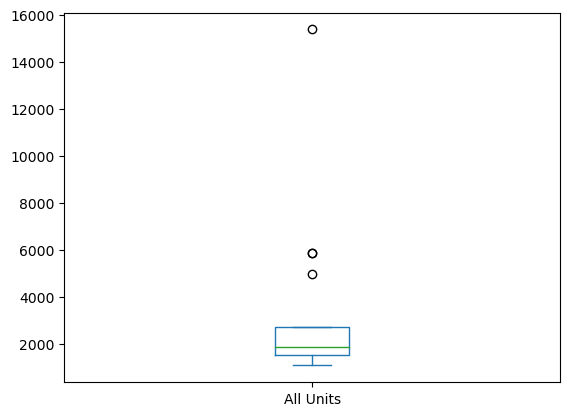

In [77]:
# box plot of All units where units greater than 1000
merged_df[merged_df["All Units"] > 1000]["All Units"].plot(kind='box')

After filtering for 'All Units' greater than 1000, the box plot reveals fewer outliers, indicating that large values are not common but do exist in significant amounts when present.

In [78]:
merged_df[merged_df["All Units"] > 1000].sort_values(by='Start Date')

Project ID                                 Project Name Program Group  \
472        59857               Stuy Town Peter Cooper Village           MFP   
689        63373  Arverne View Apartments (AKA Ocean Village)           MFP   
765        63839                                   PENN SOUTH           MIP   
2162       66588                            DAYTON BEACH PARK           MFP   
1117       67403                                STARRETT CITY           MIP   
2815       48885       FRANKLIN PLAZA APARTMENTS INC.HRP.FY18           MFP   
2894       65227                  DIEGO BEEKMAN MHA.GHPP.FY18           MFP   
1917       67427                               MASARYK TOWERS           MFP   
2817       49533                        LINDSAY PARK.HRP.FY18           MFP   
2940       67577      ESPLANADE GARDENS INCORPORATED.PLP.FY19           MFP   
2853       61875                   1199 HOUSING CORP.PLP.FY19           MFP   
1671       69118                        KNICKERBOCKER VILLAGE           MIP   
2967       68432       LINDEN PLAZA PRESERVATION LP.YR15.FY20           MFP   
2969       68530                           COOP CITY.HRP.FY20           MFP   
2749       69877              CONCOURSE VILLAGE, INC.HRP.FY21           MFP   
3070       70652                    ROCHDALE VILLAGE.HRP.FY21           MFP   
3984       73500               FLATBUSH GARDENS HDFC.HPO.FY23           MFP   

     Start Date Completion Date Extended Affordability Prevailing Wage Status  \
472  2015-12-18      12/18/2015                    Yes                    NPW   
689  2016-12-21      12/21/2016                    Yes                     PW   
765  2017-04-27      04/27/2017                    Yes                    NPW   
2162 2017-11-28      06/30/2021                     No                    NPW   
1117 2018-05-25      05/25/2018                    Yes                    NPW   
2815 2018-06-20             NaN                     No                    NPW   
2894 2018-06-26             NaN                     No                    NPW   
1917 2018-06-29      06/29/2020                     No                    NPW   
2817 2018-11-26             NaN                     No                    NPW   
2940 2018-12-27             NaN                     No                    NPW   
2853 2019-06-28             NaN                     No                    NPW   
1671 2019-10-30      10/30/2019                    Yes                    NPW   
2967 2019-12-27             NaN                     No                    NPW   
2969 2020-03-30             NaN                     No                    NPW   
2749 2020-12-01      06/13/2023                     No                    NPW   
3070 2021-06-28             NaN                     No                    NPW   
3984 2023-06-29             NaN                     No                    NPW   

        Tax Benefit  Ext Low Income Units  Very Low Income Units  \
472             NaN                     0                      0   
689      Article II                     0                      0   
765       Article V                   424                    380   
2162     Article II                     0                   1029   
1117      Article V                     0                   3569   
2815            NaN                     2                   1620   
2894            NaN                   572                    180   
1917     Article II                     0                   1107   
2817            NaN                     0                   1088   
2940           J-51                   124                   1746   
2853  J-51 Enriched                   277                   1315   
1671     Article IV                     0                      0   
2967           J-51                     6                    228   
2969     Article II                     0                  11413   
2749            NaN                     0                    506   
3070            NaN                 

* There were significant number of projects which had more than 1000 All Units. Housing Department needs to keep this momentum in order to address the housing rental issues.

#### EDA for Total Units column

<Axes: xlabel='Total Units', ylabel='Density'>

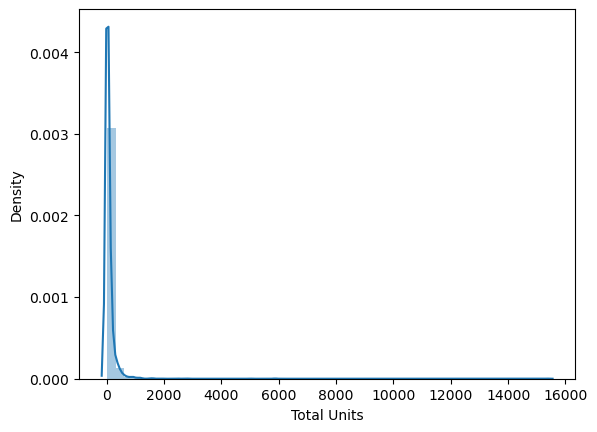

In [80]:
# Plotting a distribution plot (histogram) of the 'Total Units' column
sns.distplot(merged_df["Total Units"], kde=True) 

The distribution plot, which includes a KDE, shows that the 'Total Units' are heavily skewed towards smaller numbers, with a sharp peak near zero, suggesting that most data points are clustered around a low range.

<Axes: >

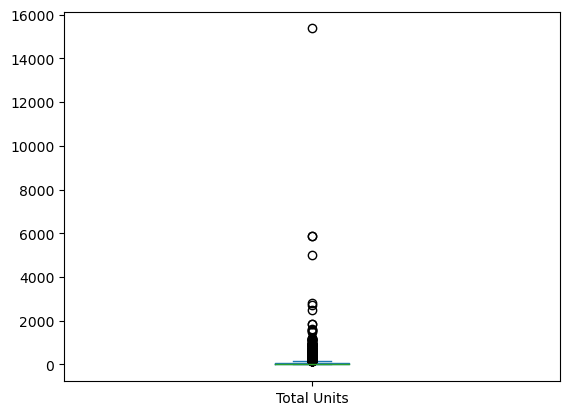

In [81]:
# box plot of Total Units
merged_df["Total Units"].plot(kind='box')

Similar to the first plot, this box plot of 'Total Units' also indicates a significant number of outliers, which might indicate exceptionally large projects or errors in data.

<Axes: >

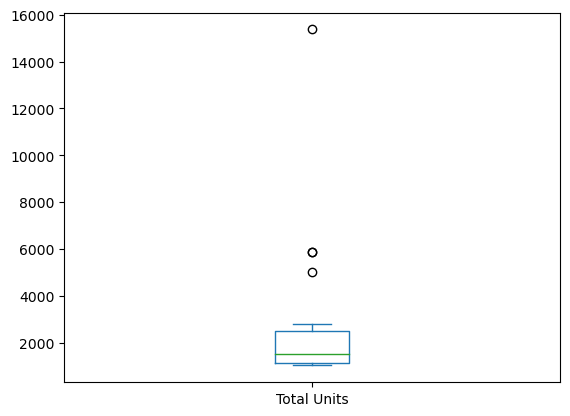

In [82]:
# box plot of Total Units where units greater than 1000
merged_df[merged_df["Total Units"] > 1000]["Total Units"].plot(kind='box')

This filtered box plot highlights the concentration of values above 1000, showcasing that while there are outliers, the core distribution remains consistent.

In [83]:
merged_df[merged_df["Total Units"] > 1000].sort_values(by='Start Date')

Project ID                                 Project Name Program Group  \
645        49709                             605 WEST 42ND ST           MIP   
1303       52241                         606 WEST 57TH STREET           MIP   
472        59857               Stuy Town Peter Cooper Village           MFP   
476        59688                              Riverton Square           MFP   
689        63373  Arverne View Apartments (AKA Ocean Village)           MFP   
765        63839                                   PENN SOUTH           MIP   
908        66058                605 WEST 42ND STREET PHASE II           MIP   
2162       66588                            DAYTON BEACH PARK           MFP   
1117       67403                                STARRETT CITY           MIP   
2815       48885       FRANKLIN PLAZA APARTMENTS INC.HRP.FY18           MFP   
2894       65227                  DIEGO BEEKMAN MHA.GHPP.FY18           MFP   
1917       67427                               MASARYK TOWERS           MFP   
2817       49533                        LINDSAY PARK.HRP.FY18           MFP   
2940       67577      ESPLANADE GARDENS INCORPORATED.PLP.FY19           MFP   
2853       61875                   1199 HOUSING CORP.PLP.FY19           MFP   
1661       64768                     WATERSIDE PLAZA.HPO.FY20           MFP   
1671       69118                        KNICKERBOCKER VILLAGE           MIP   
2600       66970          HUNTERS POINT SOUTH PARCELS F AND G           MFP   
2967       68432       LINDEN PLAZA PRESERVATION LP.YR15.FY20           MFP   
2969       68530                           COOP CITY.HRP.FY20           MFP   
2749       69877              CONCOURSE VILLAGE, INC.HRP.FY21           MFP   
2788       70840                                 5 POINTZ LIC           MIP   
3070       70652                    ROCHDALE VILLAGE.HRP.FY21           MFP   
3477       71573                            12 ROCKWELL PLACE           MIP   
3984       73500               FLATBUSH GARDENS HDFC.HPO.FY23           MFP   

     Start Date Completion Date Extended Affordability Prevailing Wage Status  \
645  2014-07-31      10/11/2016                     No                    NPW   
1303 2014-10-30      12/03/2018                     No                    NPW   
472  2015-12-18      12/18/2015                    Yes                    NPW   
476  2016-01-05      01/05/2016                    Yes                    NPW   
689  2016-12-21      12/21/2016                    Yes                     PW   
765  2017-04-27      04/27/2017                    Yes                    NPW   
908  2017-09-29      09/29/2017                     No                    NPW   
2162 2017-11-28      06/30/2021                     No                    NPW   
1117 2018-05-25      05/25/2018                    Yes                    NPW   
2815 2018-06-20             NaN                     No                    NPW   
2894 2018-06-26             NaN                     No                    NPW   
1917 2018-06-29      06/29/2020                     No                    NPW   
2817 2018-11-26             NaN                     No                    NPW   
2940 2018-12-27             NaN                     No                    NPW   
2853 2019-06-28             NaN                     No                    NPW   
1661 2019-10-25      10/25/2019                    Yes                    NPW   
1671 2019-10-30      10/30/2019                    Yes                    NPW   
2600 2019-12-20      09/20/2022                     No                    NPW   
2967 2019-12-27             NaN                     No                    NPW   
2969 2020-03-30             NaN                     No                    NPW   
2749 2020-12-01      06/13/2023                     No                    NPW   
2788 2021-02-24      10/04/2023                     No                    NPW   
3070 2021-06-28             NaN                     No                    NPW   
3477 20

* Total Units were more than 1000 in several projects and there were atmost 2 projects which accrued these units. Housing Department needs to keep this momentum in order to address the housing rental issues.

#### EDA for Senior Units column

<Axes: xlabel='Senior Units', ylabel='Density'>

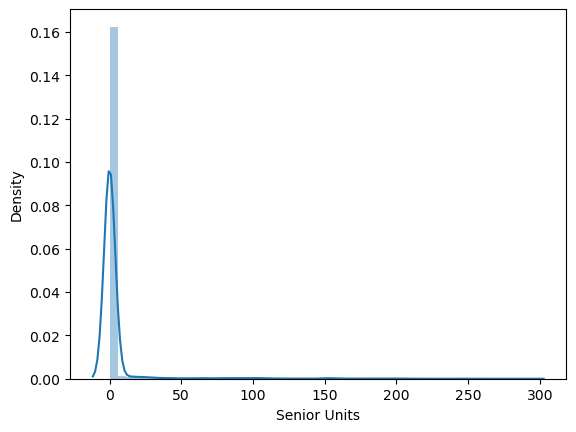

In [85]:
# Plotting a distribution plot (histogram) of the 'Senior Units' column
sns.distplot(merged_df["Senior Units"], kde=True)

The distribution plot for 'Senior Units' shows a heavy skew towards the lower end, with most values clustering near zero, suggesting that senior-specific units are relatively uncommon.

<Axes: >

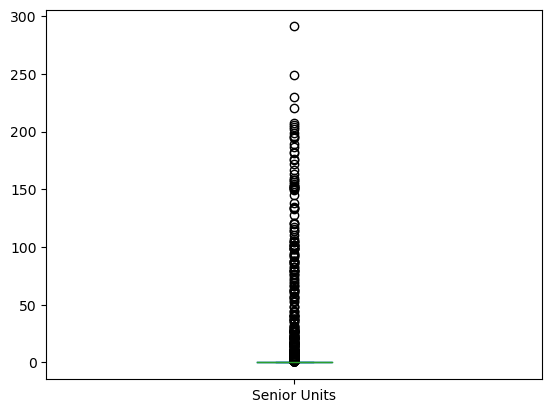

In [86]:
# box plot of senior Units
merged_df["Senior Units"].plot(kind='box')

This box plot of 'Senior Units' shows a long tail of outliers, indicating that a few entries have a high number of senior units compared to the rest.

<Axes: >

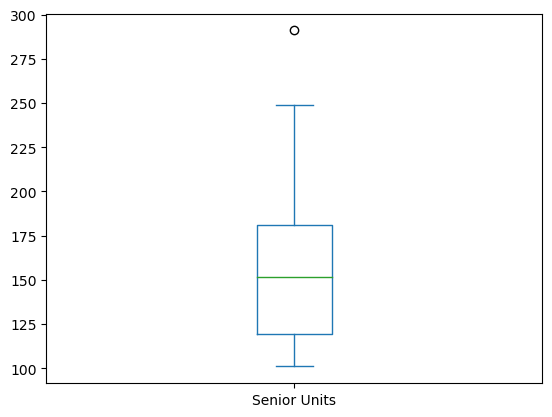

In [87]:
# box plot of Senior Units where units greater than 100
merged_df[merged_df["Senior Units"] > 100]["Senior Units"].plot(kind='box')

This plot after filtering for 'Senior Units' greater than 200 displays a more uniform distribution, but still with outliers, indicating random instances of high values.

In [88]:
merged_df[merged_df["Senior Units"] > 200].sort_values(by='Start Date')

Project ID                                       Project Name  \
985        48646             SKA MARIN. 1918 FIRST AVE. DRAPER HALL   
2886       64796                         127 WEST 43 ST | WOODSTOCK   
2359       65341                     FRIENDSET APTS HDFC.HUDMF.FY18   
1542       68177                      CAPITOL APARTMENTS HDFC.HUDMF   
2769       68160  O+O. 1611 & 1701 PURDY STREET. PARKCHESTER GAR...   
2951       67898             XENOLITH. 1810 WATSON AVENUE.SOTOMAYOR   
3010       69428                                 88-20 153RD STREET   
4276       73843                                 RED OAK.HUDMF.FY24   

     Program Group Start Date          Completion Date Extended Affordability  \
985            MFP 2014-12-24               11/28/2017                     No   
2886           MIP 2018-06-20                      NaN                     No   
2359           MFP 2018-12-20               12/30/2021                    Yes   
1542           MFP 2019-06-28               06/28/2019                    Yes   
2769           MFP 2020-12-17               08/03/2023                     No   
2951           MFP 2021-06-24                      NaN                     No   
3010           MIP 2021-06-30                      NaN                     No   
4276           MFP 2023-12-08  2023-12-08T00:00:00.000                    Yes   

     Prevailing Wage Status Tax Benefit  Ext Low Income Units  \
985                      PW        420c                   202   
2886                    NPW         NaN                     0   
2359                    NPW  Article XI                   250   
1542                    NPW  Article XI                   239   
2769                     PW        420c                   220   
2951                     PW         NaN                   204   
3010                    NPW        421a                     0   
4276                    NPW   Article V                   210   

      Very Low Income Units  Low Income Units  Moderate Income Units  \
985                       0                 0                      0   
2886                    281                10                      0   
2359                      4                 1                      4   
1542                      6                 2                      3   
2769                      0                 0                      0   
2951                      0                 0                      0   
3010                      0               207                      0   
4276                     12                 3                      0   

      Middle Income Units  Other Income Units  Total Rental Units  \
985                     0                   1                 203   
2886                    0                   0                 291   
2359                    0                   0                 259   
1542                   27                   1                 278   
2769                    0                   1                 221   
2951                    0                   1                 205   
3010                    0                   0                 207   
4276                    4                   1                 230   

      HomeOwnership Units  All Units  Total Units  Senior Units  
985                     0        203          203           202  
2886                    0        291          291           291  
2359                    0        259          259           206  
1542                    0        278          278           249  
2769                    0        221          221           220  
2951                    0        205          205           204  
3010                    0        207          207           207  
4276                    0        230          230           230

* There were very few projects which had affordable housing units more than 200 for Senior citizens. This has to be immediately addressed by Housing Department.

### Categorical Analysis

#### Program Group column

In [103]:
# Counting the occurrences of each unique value in the 'Program Group' column 
merged_df['Program Group'].value_counts()

Program Group
Multifamily Incentives Program    1896
Homeowner Assistance Program      1452
Multifamily Finance Program        955
Small Homes Program                 38
Name: count, dtype: int64

<Axes: title={'center': 'Program Group'}, xlabel='Program Group'>

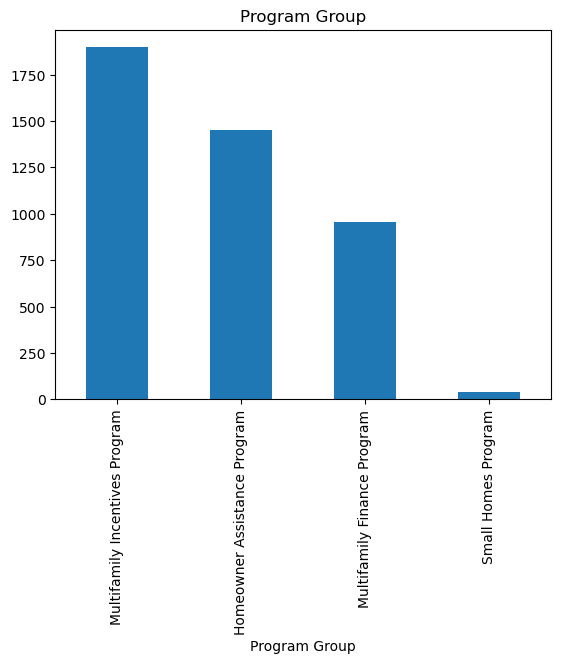

In [104]:
# Plot a bar chart of the counts of unique values in the 'Program Group'
merged_df['Program Group'].value_counts().plot.bar(title = "Program Group")

This bar chart shows the counts of different program groups, with one group Multifamily Incentives Program significantly more frequent than others, which helps in identifying the most common type of program in the dataset.

#### Extended Affordability column

In [105]:
# Counting the occurrences of each unique value in the 'Extended Affordability' column 
merged_df['Extended Affordability'].value_counts()

Extended Affordability
No     4074
Yes     267
Name: count, dtype: int64

<Axes: title={'center': 'Extended Affordability'}, xlabel='Extended Affordability'>

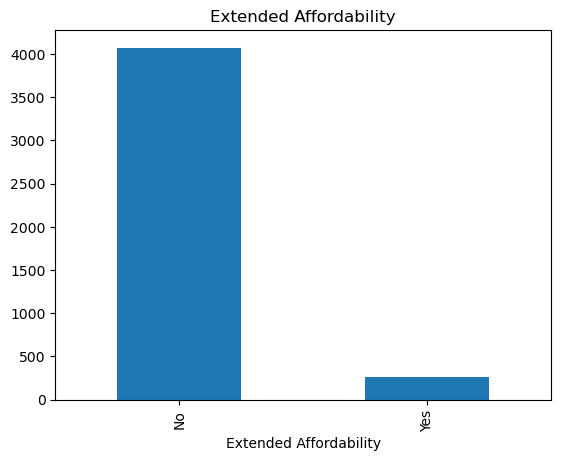

In [106]:
# Plot a bar chart of the counts of unique values in the 'Extended Affordability'
merged_df['Extended Affordability'].value_counts().plot.bar(title = "Extended Affordability")

This bar chart reveals the distribution between properties with and without extended affordability, highlighting a predominant absence of extended affordability agreements.

#### Prevailing Wage Status column

In [109]:
# Counting the occurrences of each unique value in the 'Prevailing Wage Status' column 
merged_df['Prevailing Wage Status'].value_counts()

Prevailing Wage Status
Non Prevailing Wage    4249
Prevailing Wage          92
Name: count, dtype: int64

<Axes: title={'center': 'Prevailing Wage Status'}, xlabel='Prevailing Wage Status'>

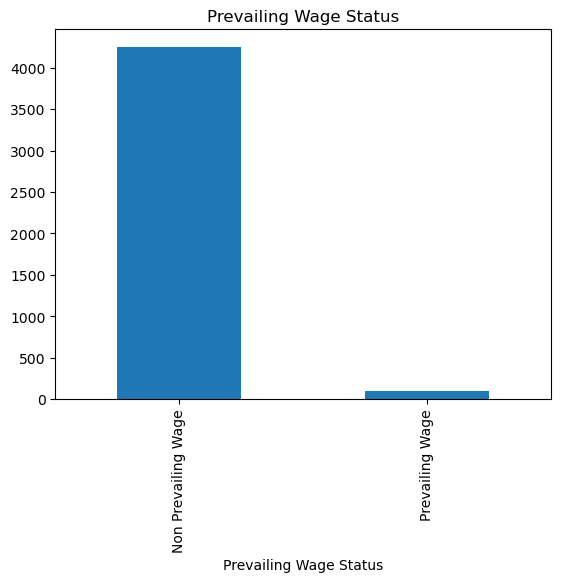

In [110]:
# Plot a bar chart of the counts of unique values in the 'Prevailing Wage Status'
merged_df['Prevailing Wage Status'].value_counts().plot.bar(title = "Prevailing Wage Status")

This bar chart shows a significant disparity between the two categories, with Non-Prevailing Wage statuses being far more common than Prevailing Wage status. This indicates that a majority of the units in the dataset are not adhering to prevailing wage standards.

#### Analysis for Tax Benefit column

In [111]:
# Counting the occurrences of each unique value in the 'Tax Benefit' column 
merged_df['Tax Benefit'].value_counts()

Tax Benefit
421a             1794
NaN              1582
420c              422
Article XI        411
Article II         36
J-51 Enriched      36
J-51               17
Article V          16
UDAAP              14
420a               11
Article IV          2
Name: count, dtype: int64

<Axes: title={'center': 'Tax Benefit'}, xlabel='Tax Benefit'>

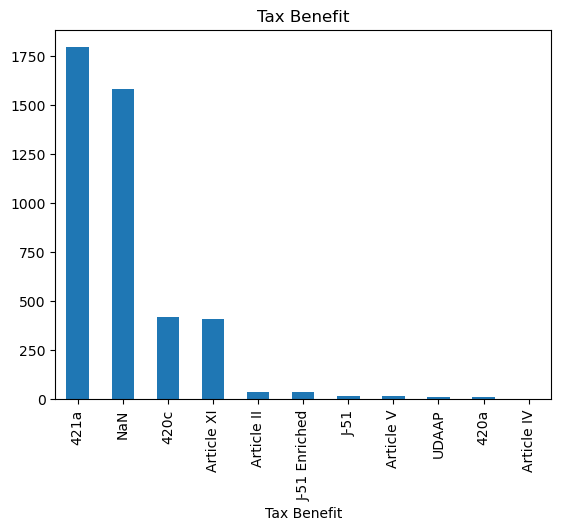

In [112]:
# Plot a bar chart of the counts of unique values in the 'Tax Benefit'
merged_df['Tax Benefit'].value_counts().plot.bar(title = "Tax Benefit")

The bar chart displays various tax benefits with '421a' and 'NaN' (missing values) being the most common. This suggests a prevalent use of the 421a tax incentive, and a significant portion of the data missing this information.

### Bivariate Analysis

#### Numerical vs Numerical

##### Extremely Low Income Units vs Very Low Income Units

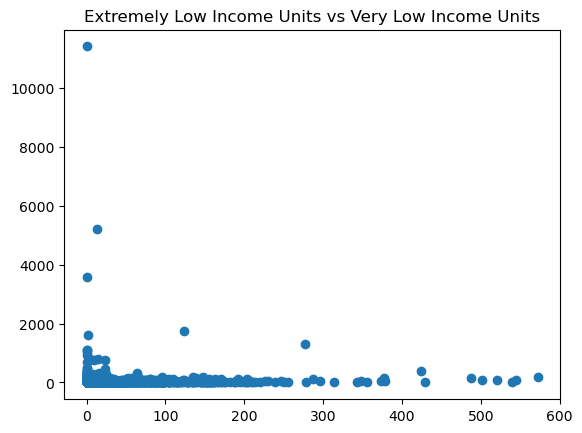

In [113]:
# Using plt.scatter to plot scatter plot by considering Ext Low Income Units on x-axis and Very Low Income Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Very Low Income Units', data = merged_df)
#plt.title to plot the title of the graph
plt.title("Extremely Low Income Units vs Very Low Income Units")
plt.show()

This scatter plot shows a relationship between extremely low and very low income units, indicating that properties often have both types of units, but there is a wide variation in the proportion of these unit types with Extremely Low Units being significantly less in number when compared with Very Low income Units.

##### Extremely Low Income Units vs Low Income Units

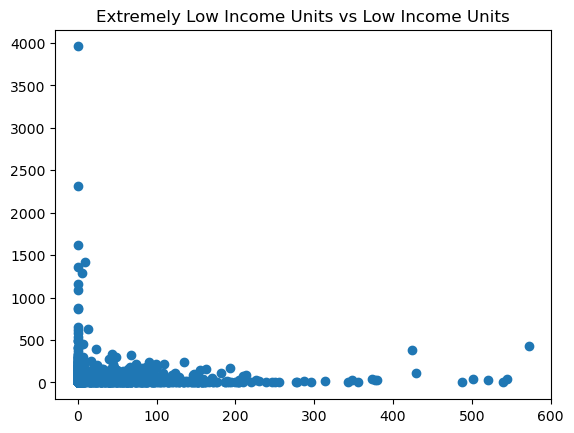

In [114]:
# Scatter plot by considering Ext Low Income Units on x-axis and Low Income Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Low Income Units', data = merged_df)
#plt.title to plot the title 
plt.title("Extremely Low Income Units vs Low Income Units")
plt.show()

This plot illustrates the distribution of extremely low income units compared to low income units. The majority of properties have a higher number of low income units compared to extremely low income units.
This could reflect varying levels of affordability within the low-income housing market.

##### Extremely Low Income Units vs Moderate Income Units

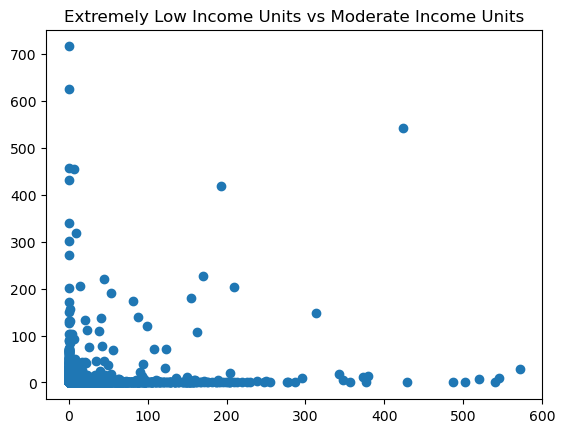

In [115]:
# Using plt.scatter to plot scatter plot by considering Ext Low Income Units on x-axis and Moderate Income Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Moderate Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Extremely Low Income Units vs Moderate Income Units")
plt.show()

 Here, the scatter plot reveals a less frequent co-occurrence of extremely low and moderate income units, suggesting that properties typically cater to either lower or moderately low income brackets, but less commonly both.

##### Extremely Low Income Units vs Middle Income Units

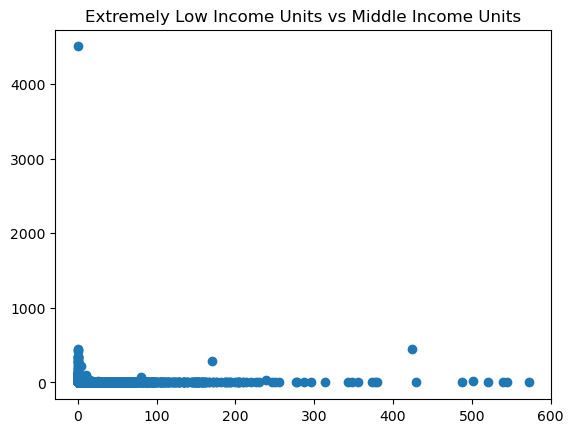

In [116]:
# Using plt.scatter to plot scatter plot by considering Ext Low Income Units on x-axis and Middle Income Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Middle Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Extremely Low Income Units vs Middle Income Units")
plt.show()

This plot shows an even distribution across the range of middle income units, with some properties having a significant number of both extremely low and middle income units, indicating diverse housing strategies.

##### Extremely Low Income Units vs Counted Rental Units

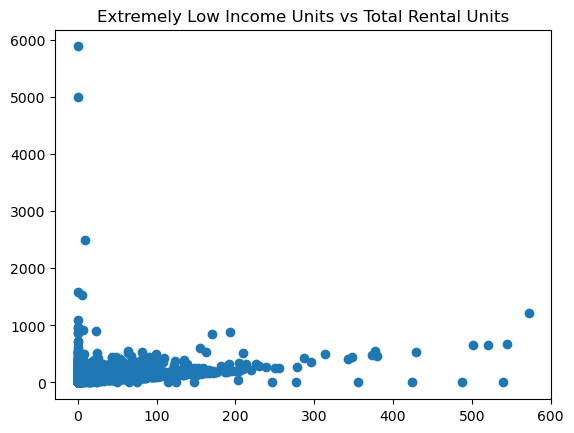

In [117]:
# Using plt.scatter to plot scatter plot by considering Ext Low Income Units on x-axis and Total Rental Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Total Rental Units', data = merged_df)
#plt.title to plot the title
plt.title("Extremely Low Income Units vs Total Rental Units")
plt.show()

 The relationship between extremely low income units and total rental units suggests that properties with a high total number of units tend to include more extremely low income units, highlighting a trend towards inclusivity in larger developments

##### Extremely Low Income Units vs Senior Units

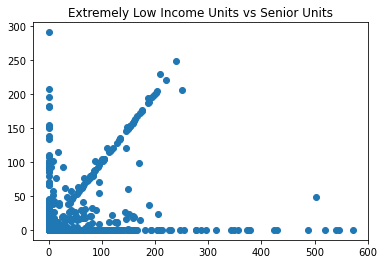

In [127]:
# Using plt.scatter to plot scatter plot by considering Ext Low Income Units on x-axis and Senior Units as y-axis
plt.scatter(x = 'Ext Low Income Units', y = 'Senior Units', data = merged_df)
#plt.title to plot the title
plt.title("Extremely Low Income Units vs Senior Units")
plt.show()

This plot shows a positive trend between extremely low income and senior units, indicating that properties designed to accommodate seniors often include a proportionately high number of extremely low income units, catering to potentially lower-income seniors.

In [128]:
merged_df[['Ext Low Income Units', 'Senior Units']].corr()

Ext Low Income Units  Senior Units
Ext Low Income Units              1.000000      0.374323
Senior Units                      0.374323      1.000000

* The correlation between Ext Low Income Units and Senior Units 37.4%. They are not highly correlated.

##### Very Low Income Units vs Low Income Units

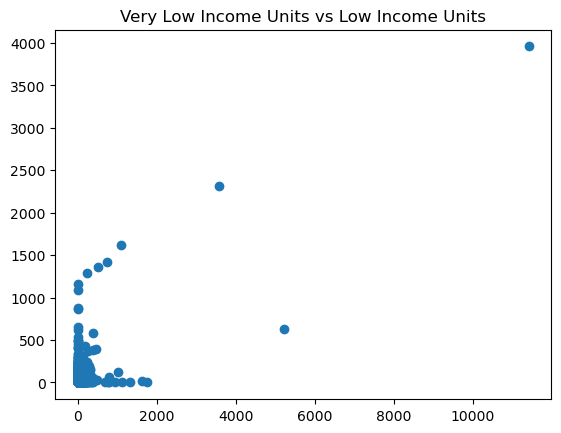

In [118]:
# Using plt.scatter to plot scatter plot by considering Very Low Income Units on x-axis and Low Income Units as y-axis
plt.scatter(x = 'Very Low Income Units', y = 'Low Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Very Low Income Units vs Low Income Units")
plt.show()

This plot shows a robust positive correlation between very low and low income units, suggesting that properties often serve both income groups, potentially to cater to a broader spectrum of the low-income population.

#### Senior Units vs Very Low Income Units

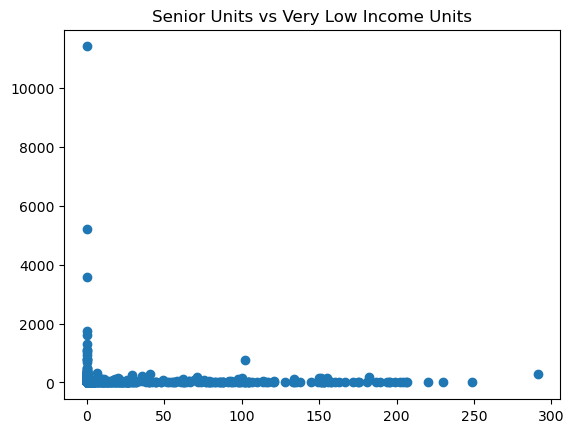

In [120]:
# Using plt.scatter to plot scatter plot by considering Senior Units on x-axis and Very Low Income Units as y-axis
plt.scatter(x = 'Senior Units', y = 'Very Low Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Senior Units vs Very Low Income Units")
plt.show()

This scatter plot shows the relationship between senior units and very low income units. It exhibits a few high values for senior units with corresponding low very low income units, suggesting specific instances with a high number of senior units but fewer very low income units.

#### Senior Units vs Low Income Units

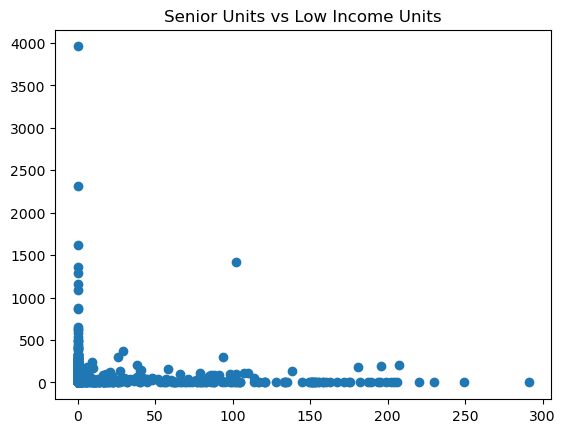

In [121]:
# Using plt.scatter to plot scatter plot by considering Senior Units on x-axis and Low Income Units as y-axis
plt.scatter(x = 'Senior Units', y = 'Low Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Senior Units vs Low Income Units")
plt.show()

 The plot suggests minimal correlation between senior units and low income units, with most of the data clustered at lower counts. This indicates that the presence of senior units doesn’t necessarily correlate with higher low income unit counts.

In [122]:
merged_df[['Senior Units', 'Low Income Units']].corr()

Senior Units  Low Income Units
Senior Units          1.000000          0.025745
Low Income Units      0.025745          1.000000

#### Senior Units vs Moderate Income Units

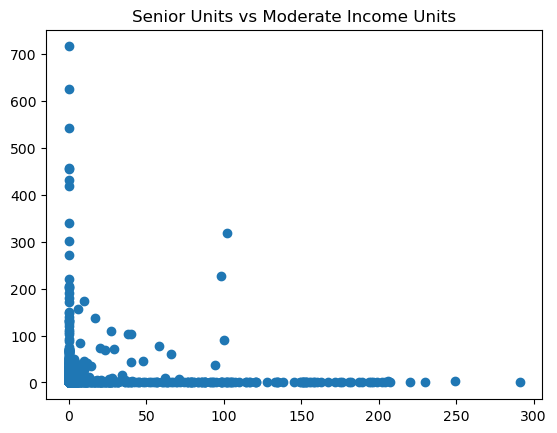

In [123]:
# Using plt.scatter to plot scatter plot by considering Senior Units on x-axis and Moderate Income Units as y-axis
plt.scatter(x = 'Senior Units', y = 'Moderate Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Senior Units vs Moderate Income Units")
plt.show()

The graph reveals a slightly scattered relationship between senior units and moderate income units, implying that projects with more senior units don't typically have a proportionally higher count of moderate income units.


In [124]:
merged_df[['Senior Units', 'Moderate Income Units']].corr()

Senior Units  Moderate Income Units
Senior Units               1.000000               0.020945
Moderate Income Units      0.020945               1.000000

#### Senior Units vs Middle Income Units

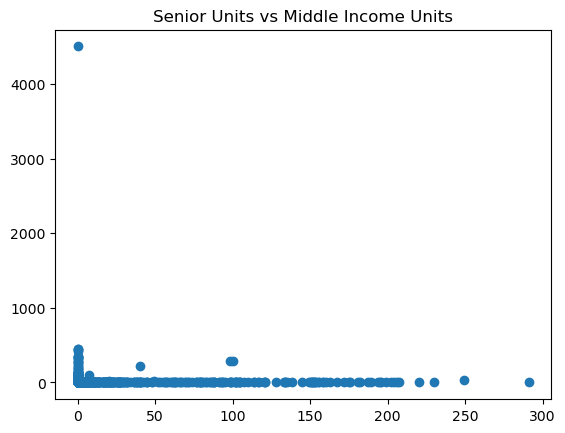

In [125]:
# Using plt.scatter to plot scatter plot by considering Senior Units on x-axis and Middle Income Units as y-axis
plt.scatter(x = 'Senior Units', y = 'Middle Income Units', data = merged_df)
#plt.title to plot the title
plt.title("Senior Units vs Middle Income Units")
plt.show()

This plot shows a slight increase in middle income units with the rise in senior units, though the relationship doesn't seem strongly correlated. The concentration of points at the lower end of the senior units spectrum indicates that most projects have fewer senior units.

In [126]:
merged_df[['Senior Units', 'Middle Income Units']].corr()

Senior Units  Middle Income Units
Senior Units             1.000000            -0.005541
Middle Income Units     -0.005541             1.000000

### Numeric VS Categorical

#### Program Group vs Ext Low Income Units

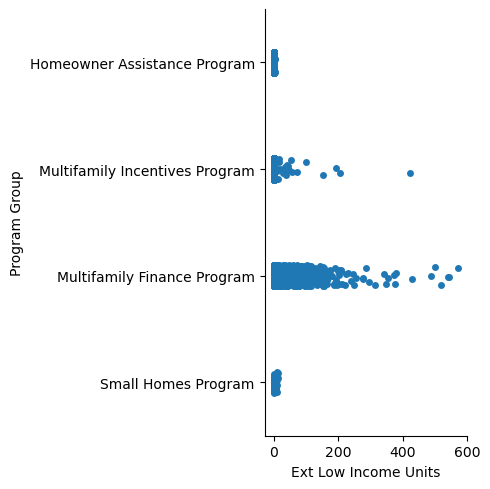

In [129]:
# Categorical plot taking Ext Low Income Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Ext Low Income Units", y="Program Group")

The catplot highlights the distribution of extreme low income units across various program groups. There is a wide distribution in the Multifamily Finance Program group, while the Small Homes Program group shows distinctly lower counts.

#### Program Group vs Very Low Income Units

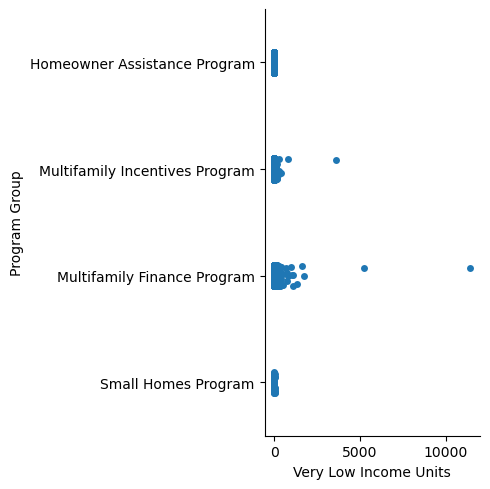

In [130]:
# Categorical plot taking Very Low Income Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Very Low Income Units", y="Program Group")

This plot showcases that Multifamily Finance Program group tends to have higher very low income units. Other program groups like Small Homes Program show significantly fewer units, indicating a program-specific distribution strategy.

#### Program Group vs Low Income Units

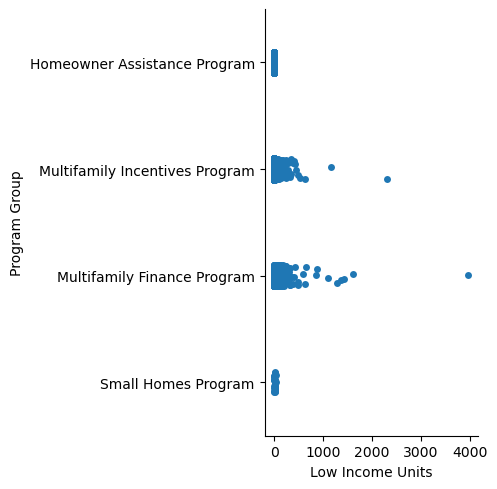

In [131]:
# Categorical plot taking Low Income Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Low Income Units", y="Program Group")

Displaying low income units across different program groups, the plot indicates a varied distribution with Multifamily Finance Program showing higher counts than other groups.

#### Program Group vs Moderate Income Units

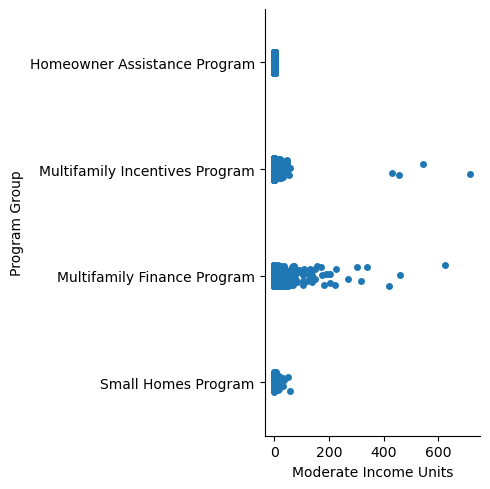

In [132]:
# Categorical plot taking Moderate Income Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Moderate Income Units", y="Program Group")

This visual suggests that the Multifamily Finance program group generally has more middle income units, whereas Small Homes Program shows very low counts, highlighting how program strategies differ.

#### Program Group vs Middle Income Units

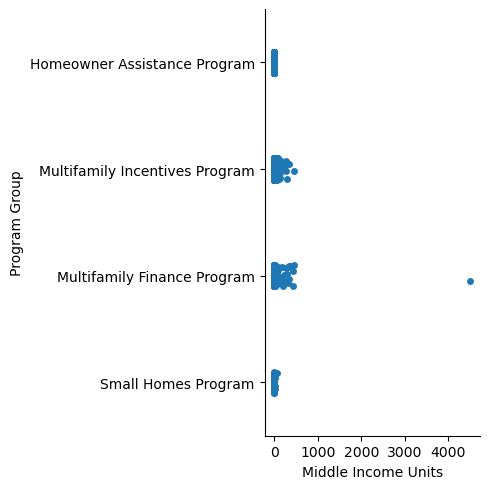

In [133]:
# Categorical plot taking Middle Income Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Middle Income Units", y="Program Group")

A broad range of total rental units is evident across different program groups. The Multifamily Finance Program group shows a high concentration of projects with many rental units, reflecting its large-scale focus.

#### Program Group vs  Total Rental Units

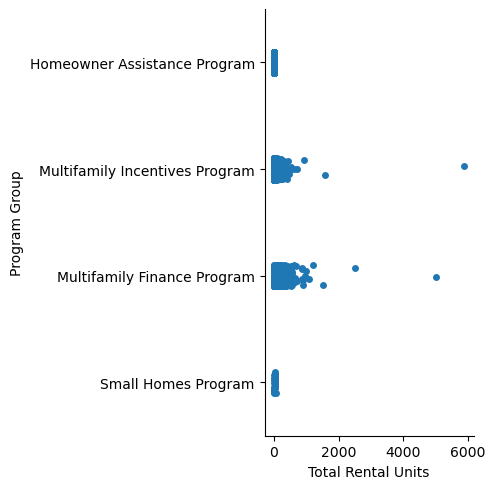

In [134]:
# Categorical plot taking Total Rental Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Total Rental Units", y="Program Group")

The plot illustrates a concentrated number of senior units within certain program groups, notably Multifamily Finance Program, pointing to targeted strategies within specific housing programs.

#### Program Group vs Senior Units

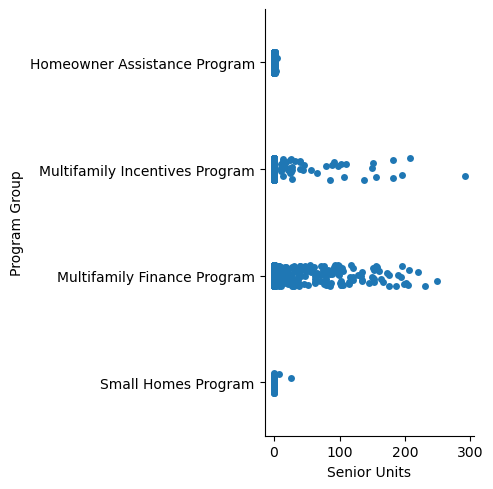

In [135]:
# Categorical plot taking Senior Units on x-axis and Program Group on y-axis
sns.catplot(data=merged_df, x="Senior Units", y="Program Group")

This plot shows a distribution of projects across different program groups against senior units. Most groups exhibit a consistent range of senior units, except for Small Homes Program and Multifamily Finance Program, suggesting a focused approach to senior housing within these programs.

#### Prevailing Wage Status vs Ext Low Income Units

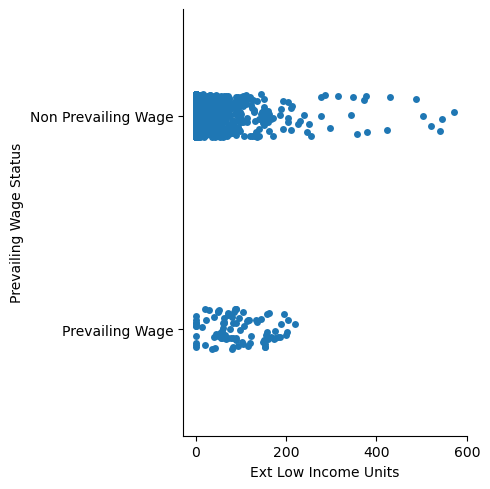

In [136]:
# Categorical plot taking Ext Low Income Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Ext Low Income Units", y="Prevailing Wage Status")

The prevailing wage status across various extents of low-income units shows a clear divide. Projects not paying prevailing wages (NPW) outnumber those paying prevailing wages (PW), particularly in developments with higher numbers of low-income units.

#### Prevailing Wage Status vs Very Low Income Units

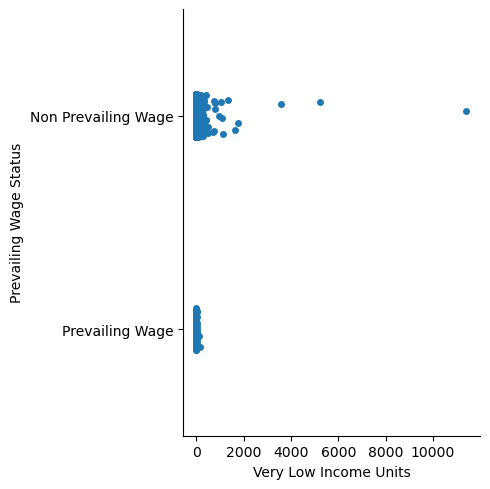

In [137]:
# Categorical plot taking Very Low Income Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Very Low Income Units", y="Prevailing Wage Status")

This plot highlights a stark contrast in prevailing wage status by the number of very low-income units. Very few projects offer prevailing wages compared to non-prevailing wages as the number of very low-income units increases.

#### Prevailing Wage Status vs  Low Income Units

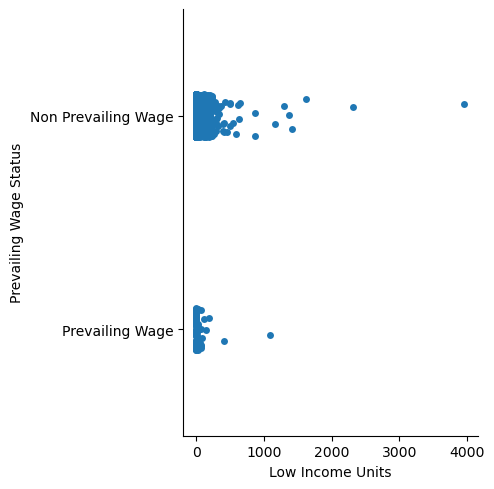

In [138]:
# Categorical plot taking Low Income Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Low Income Units", y="Prevailing Wage Status")

The distribution of low-income units against prevailing wage status indicates that most projects not offering prevailing wages accommodate a higher number of low-income units. This trend suggests economic constraints or policy differences affecting wage standards.

#### Prevailing Wage Status vs Moderate Income Units

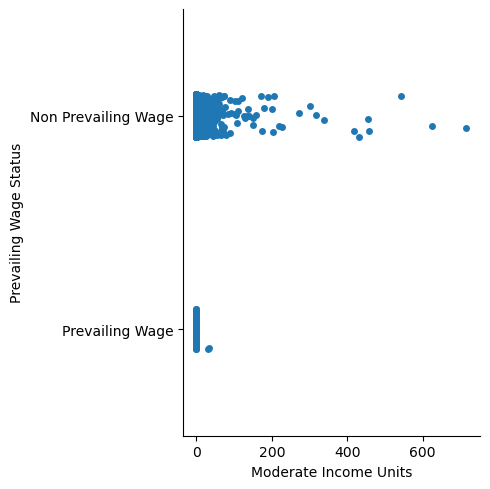

In [139]:
# Categorical plot taking Moderate Income Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Moderate Income Units", y="Prevailing Wage Status")

Projects with moderate-income units predominantly do not pay prevailing wages, as shown in the plot. Projects paying prevailing wages are associated with significantly fewer moderate-income units.

#### Prevailing Wage Status vs Middle Income Units

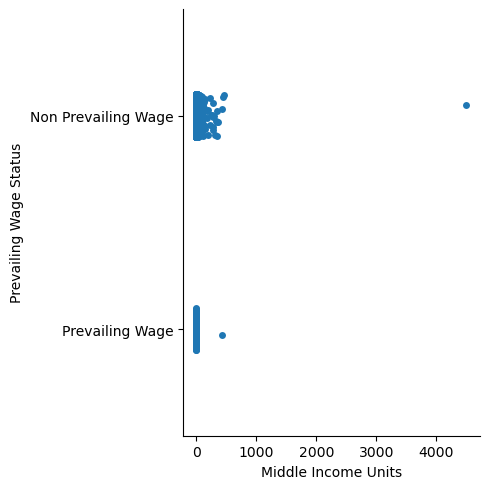

In [141]:
# Categorical plot taking Middle Income Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Middle Income Units", y="Prevailing Wage Status")

The distribution of middle-income units versus prevailing wage status shows a clear prevalence of non-prevailing wage projects across nearly all ranges of middle-income units.

#### Prevailing Wage Status vs Total Rental Units

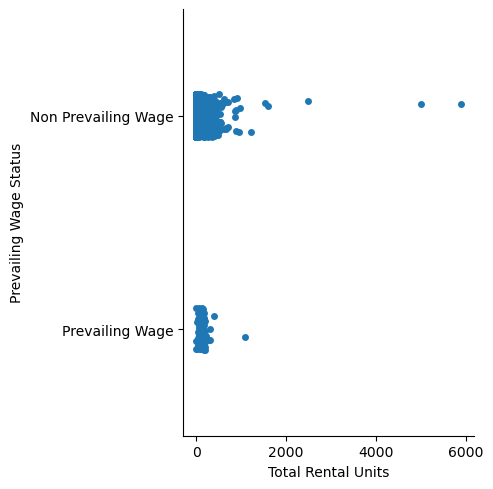

In [142]:
# Categorical plot taking Total Rental Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Total Rental Units", y="Prevailing Wage Status")

Analyzing total rental units, most projects not paying prevailing wages accommodate more units overall, suggesting larger scale projects may often operate under different wage conditions.

#### Prevailing Wage Status vs Senior Units

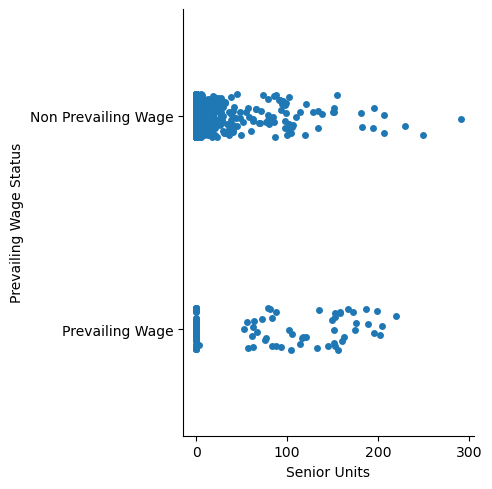

In [143]:
# Categorical plot taking Senior Units on x-axis and Prevailing Wage Status on y-axis
sns.catplot(data=merged_df, x="Senior Units", y="Prevailing Wage Status")

 For senior units, the plot shows few projects paying prevailing wages, but the vast majority do not, across all scales of senior housing units.

#### Tax Benefit vs Ext Low Income Units

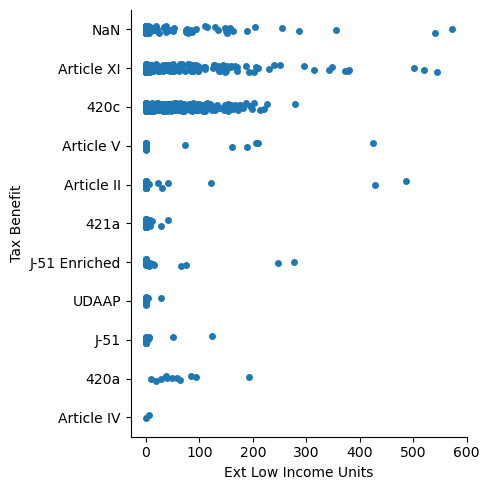

In [144]:
# Categorical plot taking Ext Low Income Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Ext Low Income Units", y="Tax Benefit")

The relationship between senior units and prevailing wage status shows an interesting pattern where projects with fewer senior units tend to pay prevailing wages more consistently than those with more units.

#### Tax Benefit vs Very Low Income Units

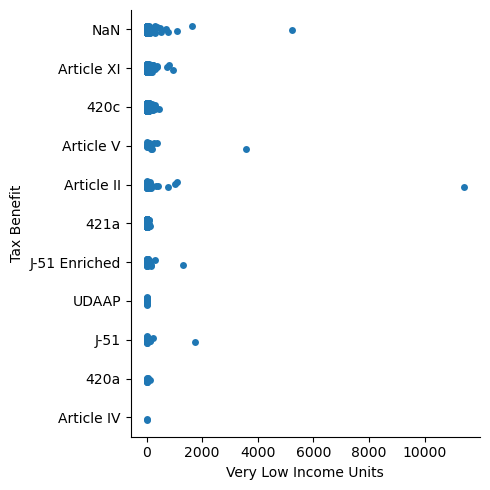

In [145]:
# Categorical plot taking Very Low Income Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Very Low Income Units", y="Tax Benefit")

The tax benefits applied to projects with extremely low-income units show a diversity in the application of various tax benefit programs, with no apparent concentration in any particular program, indicating a broad application of benefits across different programs.

#### Tax Benefit vs Low Income Units

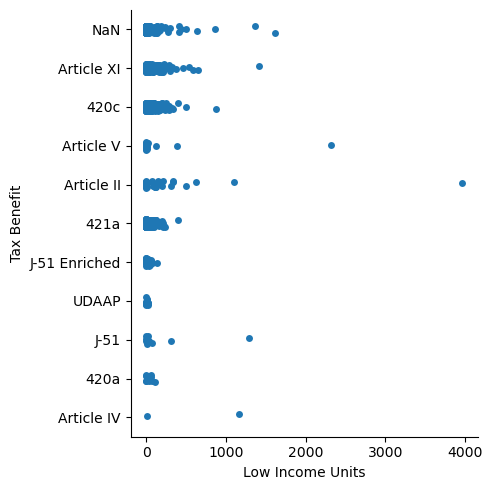

In [146]:
# Categorical plot taking Low Income Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Low Income Units", y="Tax Benefit")

This plot shows the distribution of tax benefits across projects with moderate income units. Each tax benefit category is depicted as a different color, highlighting the diversity in tax benefit application. Notably, most projects, regardless of the number of units, seem to utilize Article XI benefits prominently, suggesting its broader applicability or more favorable terms for these projects.

#### Tax Benefit vs Moderate Income Units

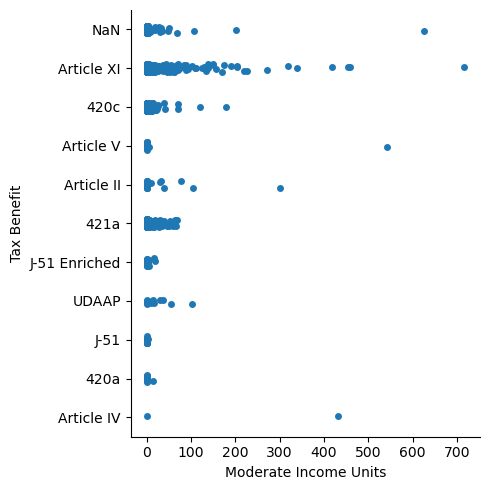

In [147]:
# Categorical plot taking Moderate Income Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Moderate Income Units", y="Tax Benefit")

Here, the relationship between middle income units and tax benefits is displayed. The plot suggests that a few tax benefits are more frequently applied, with 420c and Article XI being the most common among projects with a significant number of middle income units. This might indicate specific policy incentives that favour mid-range income projects.

#### Tax Benefit vs Middle Income Units

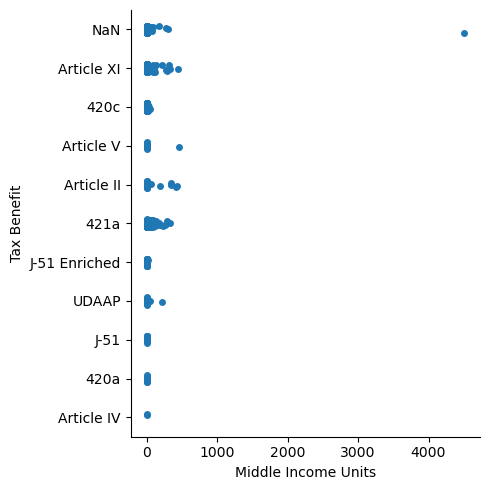

In [148]:
#Categorical plot taking Middle Income Units on x-axis and Tax Benefit Units on y-axis
sns.catplot(data=merged_df, x="Middle Income Units", y="Tax Benefit")

The distribution of total rental units against different tax benefits indicates that larger projects tend to utilize a specific set of benefits, notably Article XI and 421a. This could reflect the design of these tax benefits to support larger scale housing developments.

#### Tax Benefit vs Total Rental Units

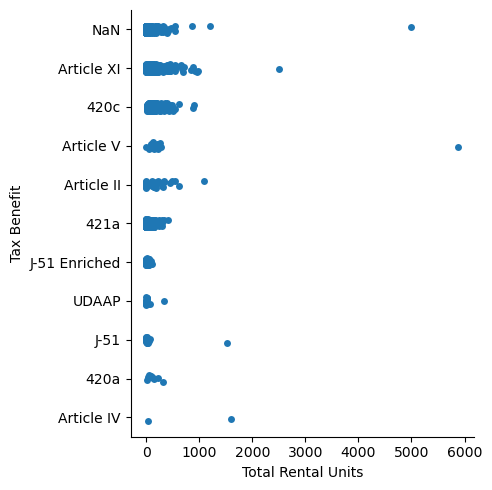

In [149]:
# Categorical plot taking Total Rental Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Total Rental Units", y="Tax Benefit")

This visualization contrasts senior units against the tax benefits applied. It appears that senior housing projects frequently benefit from 420c and Article XI, which may offer advantages that are particularly aligned with the needs or financial structures of senior housing.

#### Tax Benefit vs Senior Units

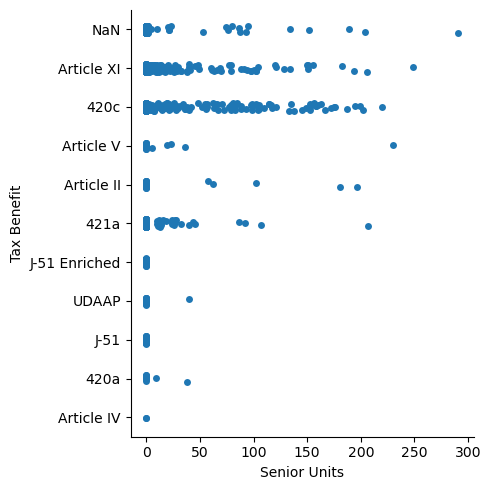

In [150]:
# Categorical plot taking Senior Units on x-axis and Tax Benefit on y-axis
sns.catplot(data=merged_df, x="Senior Units", y="Tax Benefit")

 The plot categorically shows the tax benefits for projects with senior units. Here, the spread of tax benefits across different project sizes (in terms of senior units) is visible, with a notable concentration of Article XI across all sizes, suggesting its suitability or attractiveness for senior housing projects.

### Categorical VS Categorical

#### Program Group vs Prevailing Wage Status

<Axes: xlabel='Program Group'>

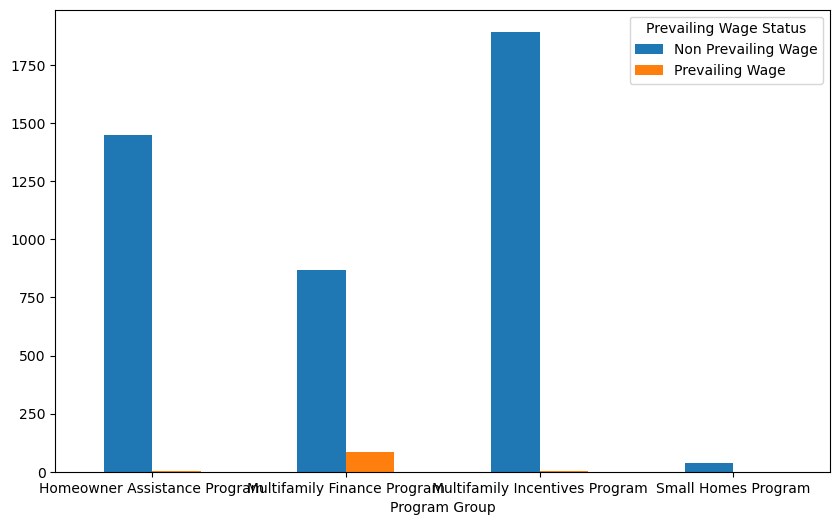

In [152]:
#creating a cross-tabulation (or contingency table) from the data_frame.
CrosstabResult=pd.crosstab(index=merged_df['Program Group'],columns=merged_df['Prevailing Wage Status'])
#Plotting the CrosstabResult as a bar chart. 
CrosstabResult.plot.bar(figsize=(10,6), rot=0) 

This bar graph illustrates the distribution of projects by program group and prevailing wage status. The dominant blue bars (Non Prevailing Wages) across all groups except Small Homes Program suggests a general trend of not paying prevailing wages in most program types, which could reflect broader economic or policy influences affecting wage standards in public housing projects.

#### Program Group vs Tax Benefit

<Axes: xlabel='Program Group'>

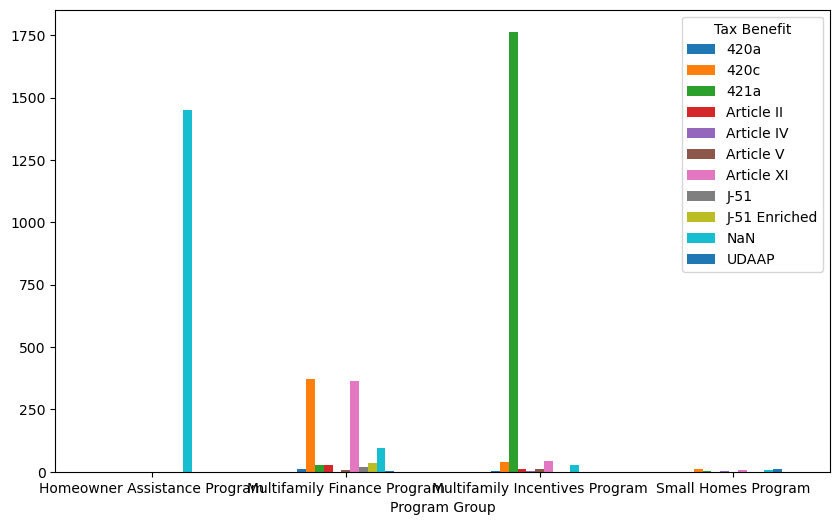

In [153]:
#creating a cross-tabulation (or contingency table) from the data_frame
CrosstabResult=pd.crosstab(index=merged_df['Program Group'],columns=merged_df['Tax Benefit'])
#Plotting the CrosstabResult as a bar chart. 
CrosstabResult.plot.bar(figsize=(10,6), rot=0)

This plot provides a breakdown of tax benefits by program group, highlighting which types of benefits are more prevalent in different housing programs. It shows a significant use of Article XI and 421a benefits, particularly in the Multifamily Incentives Program, suggesting these benefits are crucial for the financial structuring of these housing initiatives.

#### Prevailing Wage Status vs Tax Benefit

<Axes: xlabel='Prevailing Wage Status'>

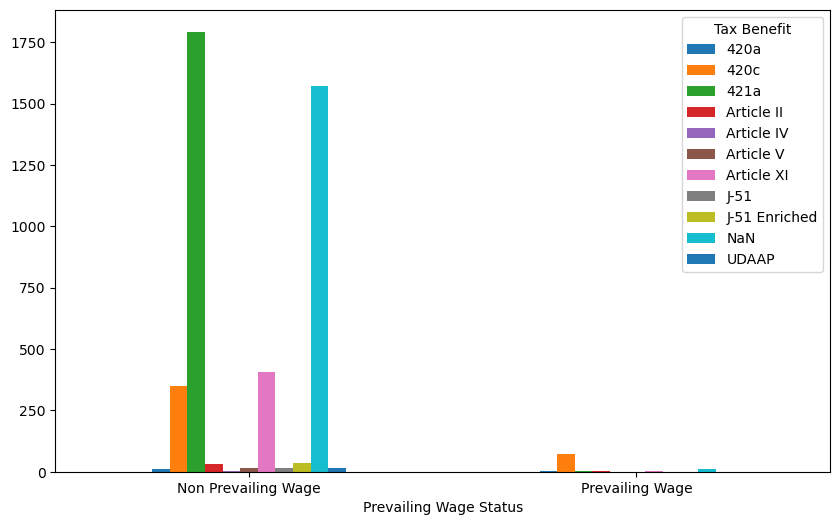

In [154]:
# Creating a cross-tabulation (or contingency table) from the data_frame.
CrosstabResult=pd.crosstab(index=merged_df['Prevailing Wage Status'],columns=merged_df['Tax Benefit'])
#Plotting the CrosstabResult as a bar chart. 
CrosstabResult.plot.bar(figsize=(10,6), rot=0)

This multivariate analysis shows the correlation between prevailing wage status and the distribution of tax benefits. The visualization indicates that projects not paying prevailing wages tend to utilize a diverse range of tax benefits, which might be strategic to offset the lower labor costs with financial incentives from tax benefits.

## Multivariate Analysis

In [215]:
#Finding correlation of the dataframe
merged_df.corr()

Project ID  Ext Low Income Units  \
Project ID               1.000000             -0.089547   
Ext Low Income Units    -0.089547              1.000000   
Very Low Income Units   -0.012299              0.046884   
Low Income Units        -0.113269              0.064868   
Moderate Income Units   -0.043166              0.117059   
Middle Income Units      0.007586             -0.001054   
Other Income Units      -0.183380              0.332539   
Total Rental Units      -0.097228              0.291555   
HomeOwnership Units     -0.010703              0.048365   
All Units               -0.059084              0.191260   
Total Units             -0.053093              0.175007   
Senior Units            -0.048963              0.374323   

                       Very Low Income Units  Low Income Units  \
Project ID                         -0.012299         -0.113269   
Ext Low Income Units                0.046884          0.064868   
Very Low Income Units               1.000000          0.689853   
Low Income Units                    0.689853          1.000000   
Moderate Income Units               0.025678          0.163292   
Middle Income Units                -0.002246          0.073838   
Other Income Units                  0.085990          0.231916   
Total Rental Units                  0.202847          0.561710   
HomeOwnership Units                 0.936187          0.633959   
All Units                           0.914415          0.836645   
Total Units                         0.878634          0.816833   
Senior Units                        0.012519          0.025745   

                       Moderate Income Units  Middle Income Units  \
Project ID                         -0.043166             0.007586   
Ext Low Income Units                0.117059            -0.001054   
Very Low Income Units               0.025678            -0.002246   
Low Income Units                    0.163292             0.073838   
Moderate Income Units               1.000000             0.044634   
Middle Income Units                 0.044634             1.000000   
Other Income Units                  0.143648            -0.007885   
Total Rental Units                  0.283056             0.489961   
HomeOwnership Units                 0.046196             0.015432   
All Units                           0.185026             0.264409   
Total Units                         0.199502             0.279432   
Senior Units                        0.020945            -0.005541   

                       Other Income Units  Total Rental Units  \
Project ID                      -0.183380           -0.097228   
Ext Low Income Units             0.332539            0.291555   
Very Low Income Units            0.085990            0.202847   
Low Income Units                 0.231916            0.561710   
Moderate Income Units            0.143648            0.283056   
Middle Income Units             -0.007885            0.489961   
Other Income Units               1.000000            0.320371   
Total Rental Units               0.320371            1.000000   
HomeOwnership Units              0.029499           -0.013545   
All Units                        0.189691            0.500659   
Total Units                      0.167017            0.498711   
Senior Units                     0.167773            0.142066   

                       HomeOwnership Units  All Units  Total Units  \
Project ID                       -0.010703  -0.059084    -0.053093   
Ext Low Income Units              0.048365   0.191260     0.175007   
Very Low Income Units             0.936187   0.914415     0.878634   
Low Income Units                  0.633959   0.836645     0.816833   
Moderate Income Units             0.046196   0.185026     0.199502   
Middle Income Units               0.015432   0.264409     0.279432   
Other Income Units                0.029499   0.189691     0.167017   
Total Rental Units               -0.013545   0.500659     0.498711   
HomeOwnership Units   

<Axes: >

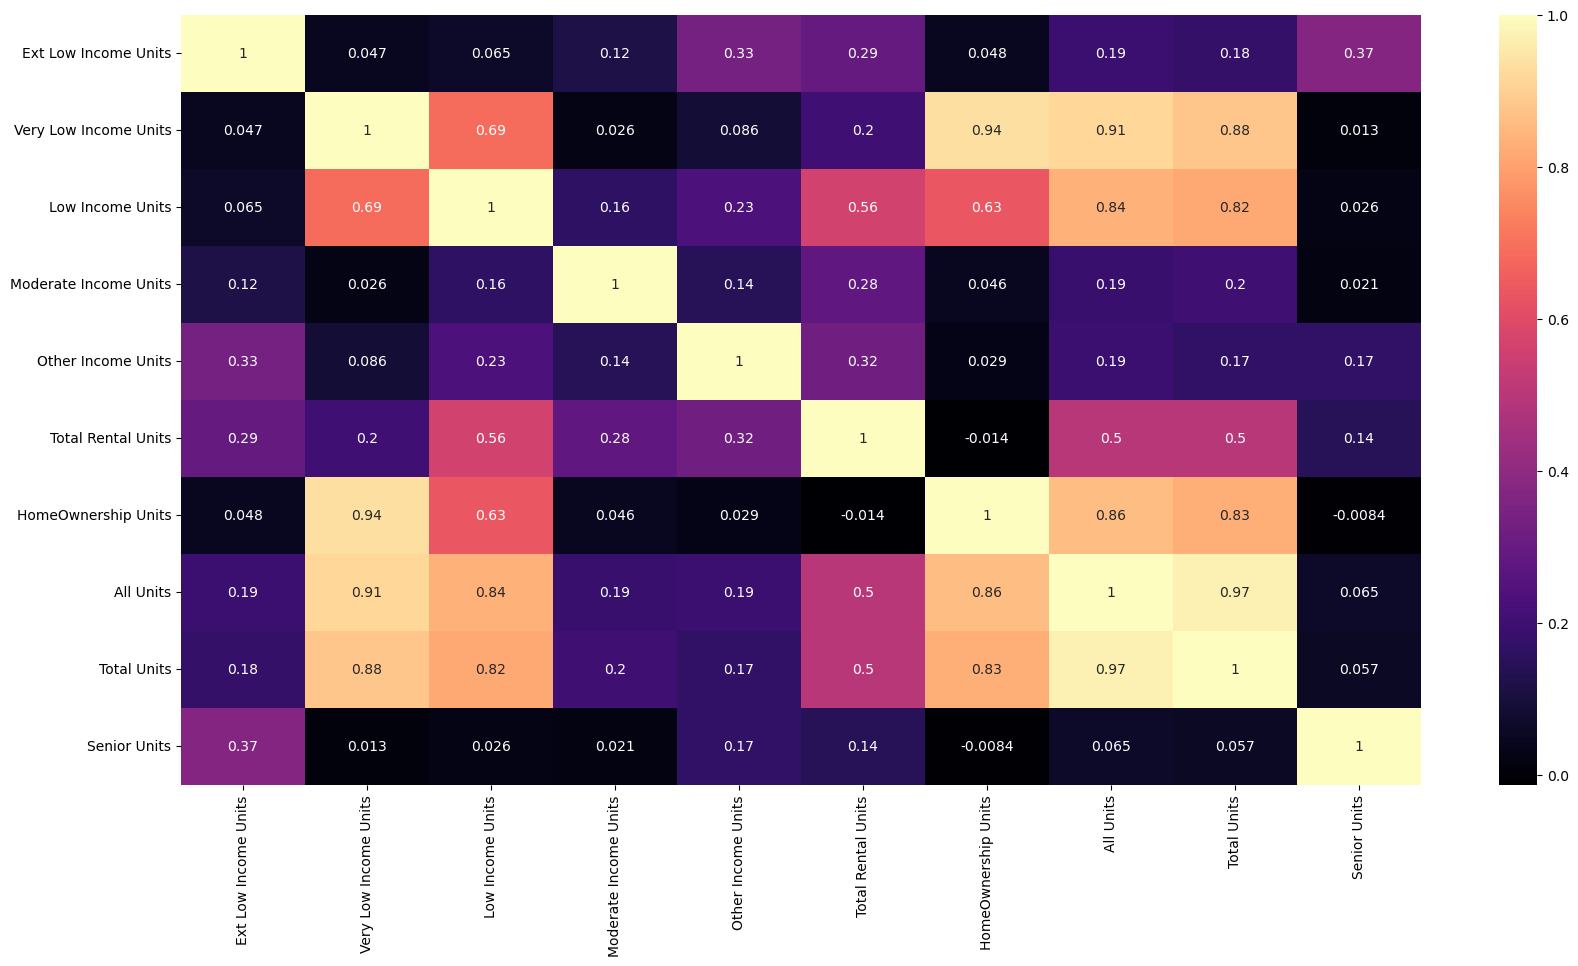

In [158]:
plt.figure(figsize=(20, 10))
#constructing heat map using sns.heatmap
sns.heatmap(merged_df[['Ext Low Income Units','Very Low Income Units','Low Income Units','Moderate Income Units',
                       'Other Income Units','Total Rental Units','HomeOwnership Units','All Units','Total Units',
                       'Senior Units']].corr(), annot=True, cmap="magma")
            

* The heatmap shows high correlations between the columns   
1.Very Low Income Units and Total Units; Very Low Income Units and All Units;Very Low Income Units and HomeOwnership Units.  
2.Low Income Units and Total Units; Low Income Units and All Units;  
3.Total Unitts and All Units  
* There exists negative correlation between HomeOwnership Units and Senior Units; HomeOwnership Units and Total Rental Units.
 

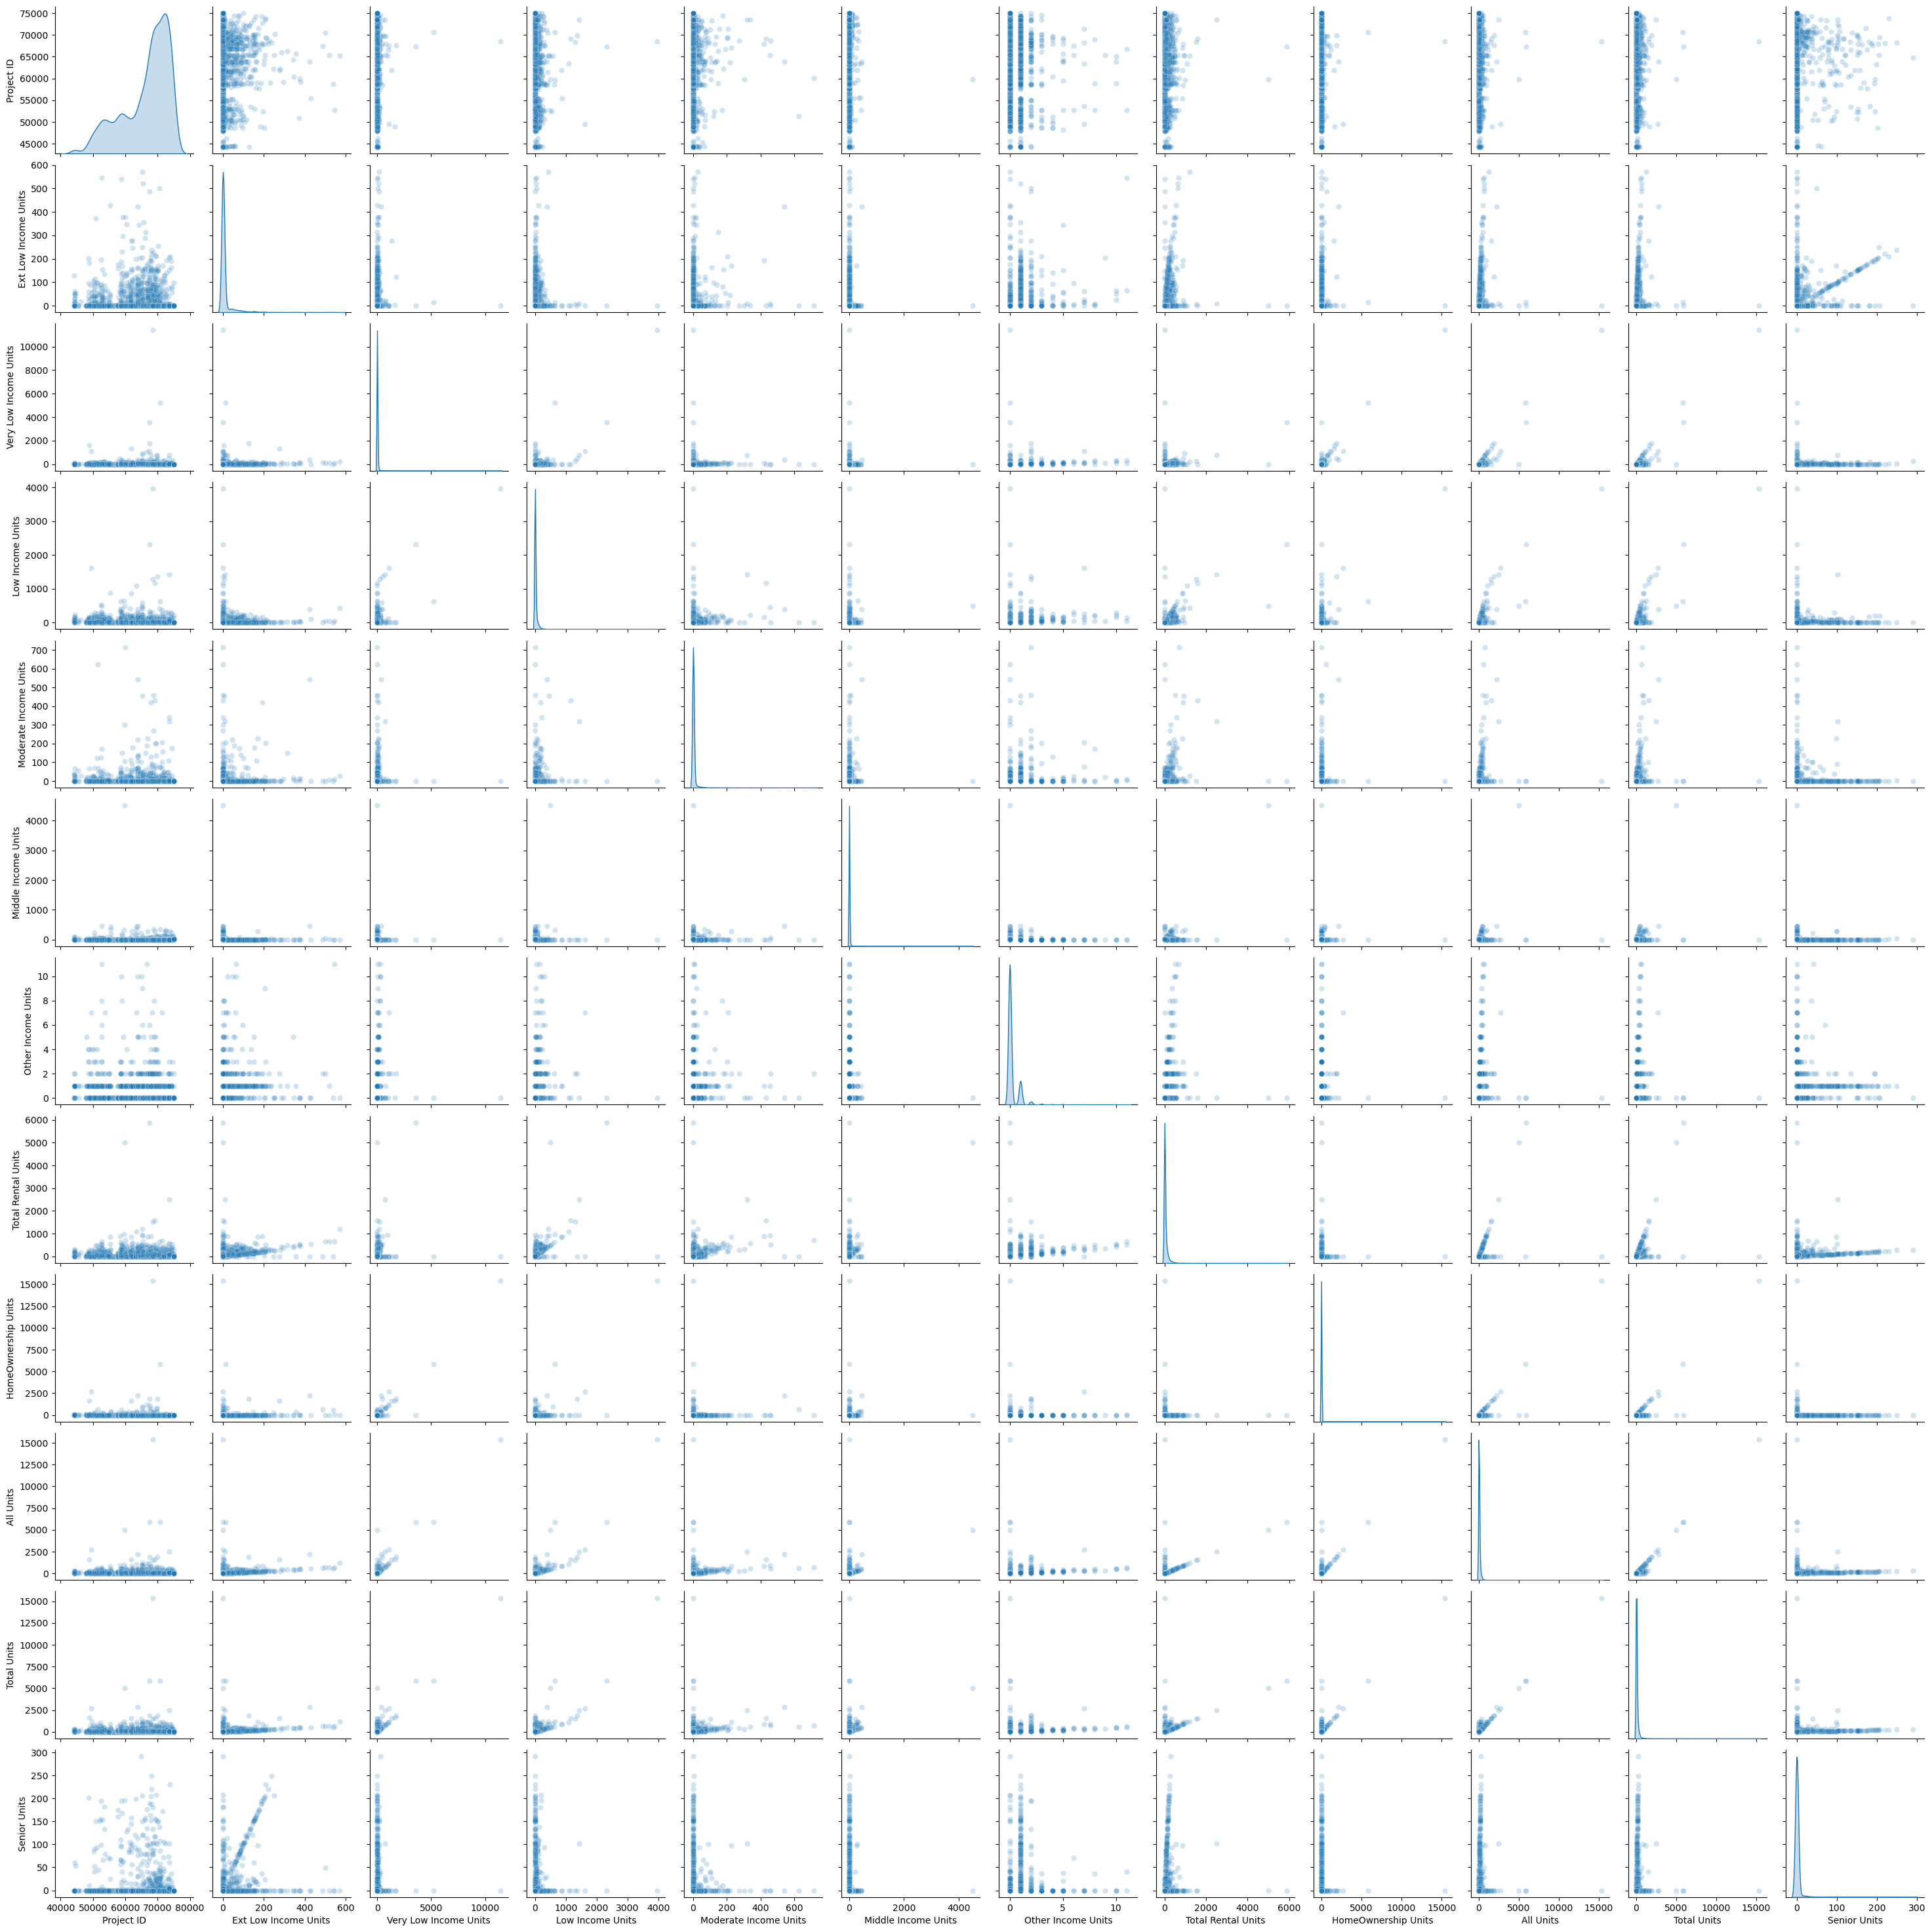

In [159]:
sns.pairplot(merged_df, diag_kind='kde', plot_kws={'alpha': 0.2})

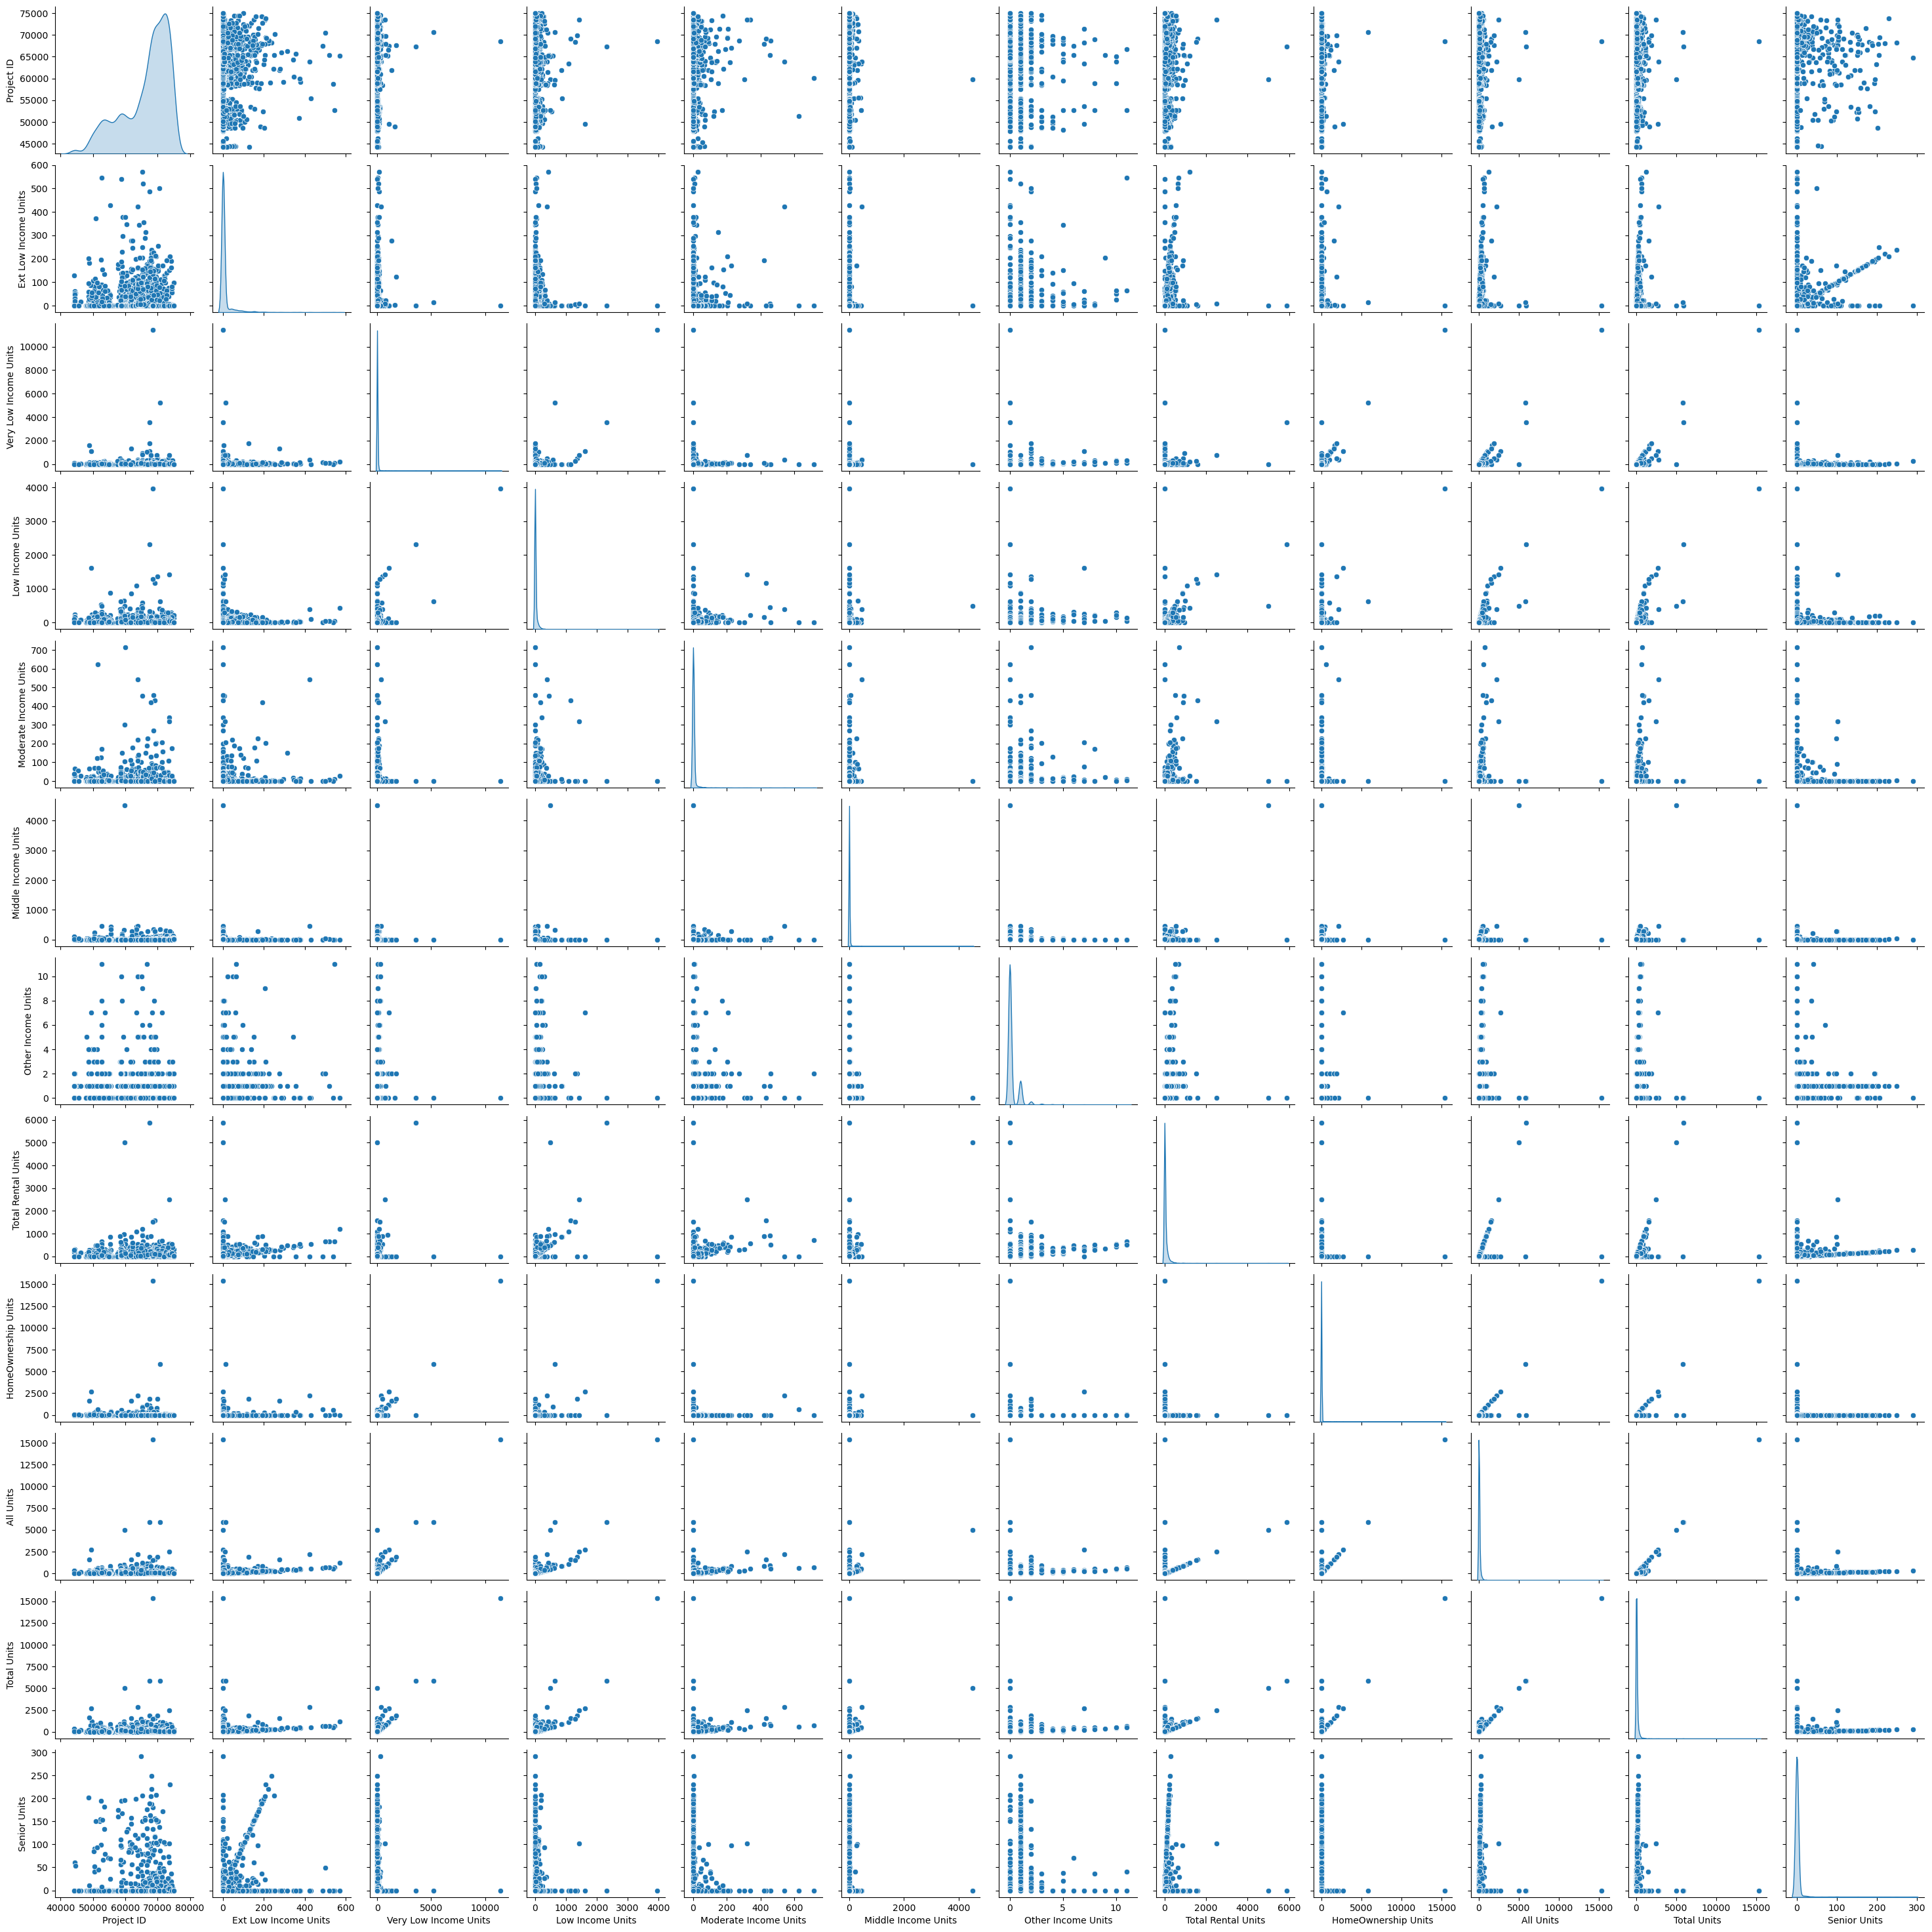

In [161]:
#Plotting the graphs of all the attributes using sns.pairplot
sns.pairplot(merged_df, diag_kind='kde')

* The above Pairplot also confirms the strong correlation between the columns Very Low Income Units and Total Units; Very Low Income Units and All Units;Very Low Income Units and HomeOwnership Units and  negative correlation between HomeOwnership Units and Senior Units; HomeOwnership Units and Total Rental Units


#### Plot between LowEarly Income Units and their Program Groups

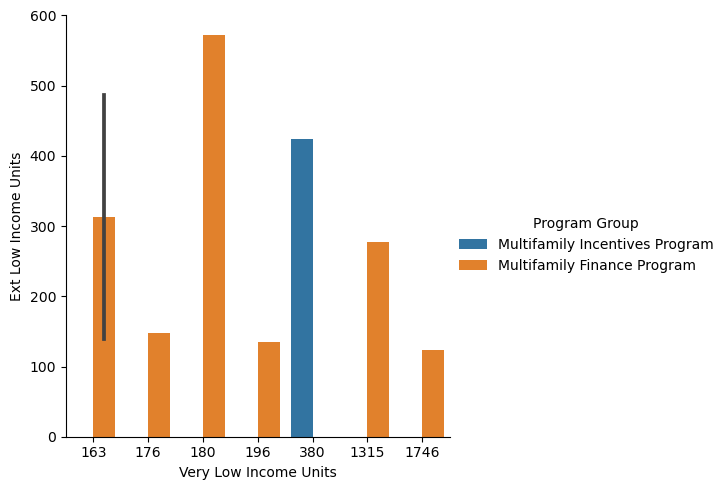

In [167]:
dfEDA = merged_df[(merged_df['Very Low Income Units']>150) & (merged_df['Ext Low Income Units']>100)]
#Drawing a catplot
sns.catplot(x='Very Low Income Units', y='Ext Low Income Units', hue='Program Group',
               kind='bar', data=dfEDA);

This bar graph compares the number of very low-income units across different housing programs. The sharp peaks in certain programs indicate a focused approach to accommodating very low-income residents, potentially driven by specific program mandates or funding structures designed to target the most economically vulnerable populations.

#### Plot between MiddleEarning Income Units and their Program Groups

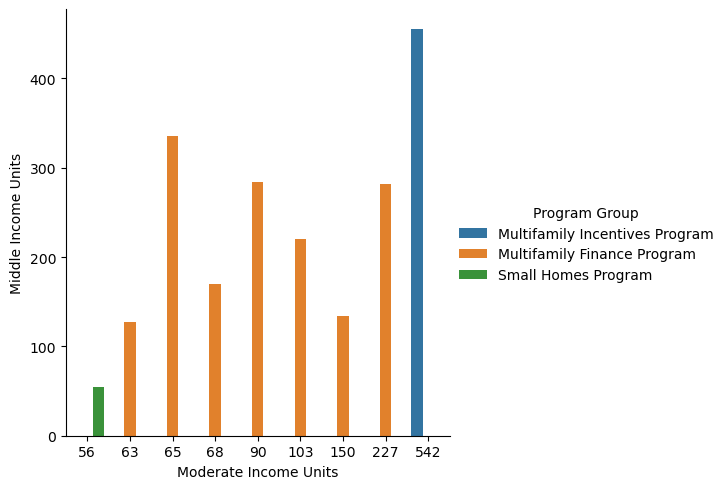

In [169]:
dfEDA = merged_df[(merged_df['Moderate Income Units']>50) & (merged_df['Middle Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Moderate Income Units', y='Middle Income Units', hue='Program Group',
               kind='bar', data=dfEDA);

This plot focuses on the relationship between total rental units and senior units across different program groups. The stark differences in scale between programs like Small Homes Program and Homeowner Assistance Program versus others like Multifamily Incentives Program and Multifamily Finance Program suggest varying focuses, with some programs perhaps targeting broader demographics, while others focus more on senior or specialized housing needs.

#### Plot between Middle Income Units and Total Rental Units, and their associated Program Groups

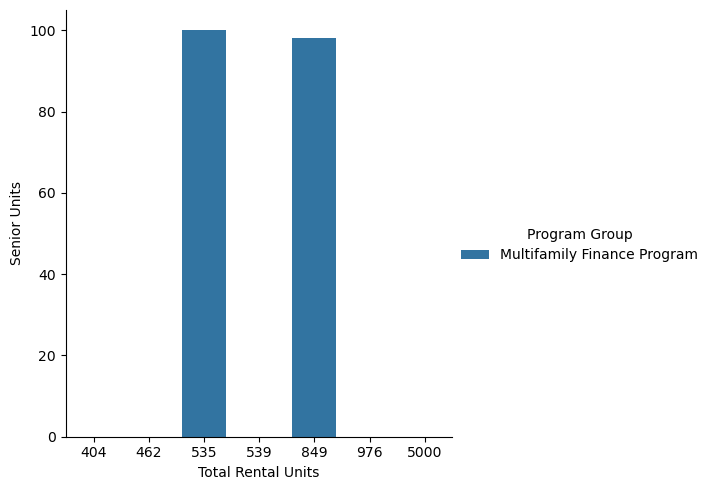

In [176]:
dfEDA = merged_df[(merged_df['Total Rental Units']>400) & (merged_df['Middle Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Total Rental Units', y='Senior Units', hue='Program Group',
               kind='bar', data=dfEDA);

This bar graph presents a detailed comparison of senior units within total rental units across various housing programs. Most notably, the Multifamily Finance program (Multifamily Finance program) stands out with a consistently high ratio of senior units relative to total units, emphasizing its focus on senior housing.

#### Plot between LowEarning Income Units and Prevailing Wage Status category

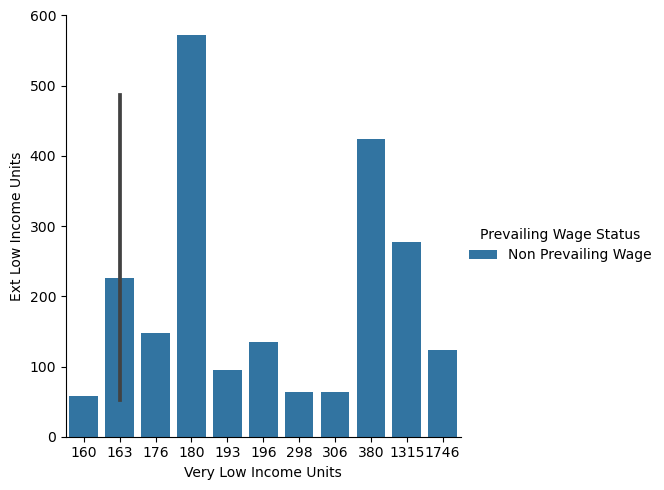

In [177]:
dfEDA = merged_df[(merged_df['Very Low Income Units']>150) & (merged_df['Ext Low Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Very Low Income Units', y='Ext Low Income Units', hue='Prevailing Wage Status',
               kind='bar', data=dfEDA);

This graph depicts the distribution of very low income units across projects with and without prevailing wage policies (NPW, PW). A significant observation is that projects not paying prevailing wages (NPW) tend to have a higher number of very low-income units, suggesting these projects might operate under budget constraints or different funding mechanisms that do not support prevailing wages. This indicates a potential trade-off between wage policies and the capacity to provide lower cost housing.

#### Plot between MiddleEarning Income Units and Prevailing Wage Status Category

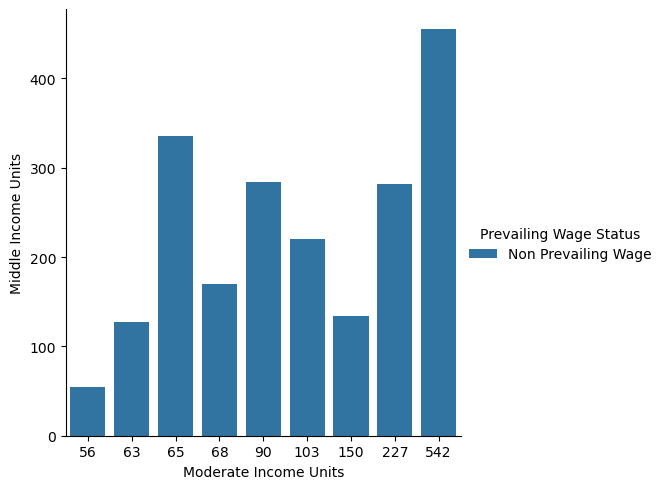

In [178]:
dfEDA = merged_df[(merged_df['Moderate Income Units']>50) & (merged_df['Middle Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Moderate Income Units', y='Middle Income Units', hue='Prevailing Wage Status',
               kind='bar', data=dfEDA);

In this graph, we see the distribution of moderate to middle-income units with a focus on prevailing wage status. The data indicates that projects paying prevailing wages (PW) are less frequent but involve higher numbers of middle-income units when they do occur. This might reflect a policy or economic environment where higher-wage projects are feasible only at certain scales or in certain income brackets.

#### Plot between Total Rental Units and Senior Units, and their Prevailing Wage Status

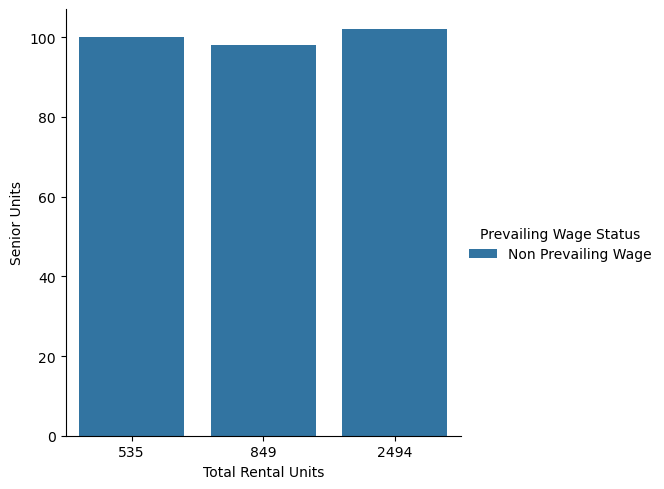

In [180]:
dfEDA = merged_df[(merged_df['Total Rental Units']>400) & (merged_df['Senior Units']>50)]
#Drawing a catplot
sns.catplot(x='Total Rental Units', y='Senior Units', hue='Prevailing Wage Status',
               kind='bar', data=dfEDA);

This graph shows the relationship between total rental units and senior units, categorized by the type of Prevailing Wage Status. This graph usefully illustrates how fiscal policy influences housing development dynamics, especially for vulnerable populations like seniors.

#### Plot between LowEarning Income Units and Tax Benefit Category

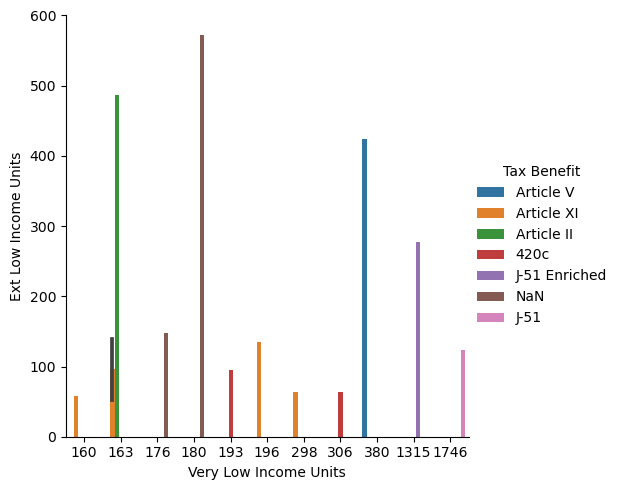

In [181]:
dfEDA = merged_df[(merged_df['Very Low Income Units']>150) & (merged_df['Ext Low Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Very Low Income Units', y='Ext Low Income Units', hue='Tax Benefit',
               kind='bar', data=dfEDA);

Highlighting the association between the scale of very low-income units and the type of tax benefits applied, this graph shows that certain benefits like Article XI and 421a are predominantly used in projects with a higher number of very low-income units. This pattern suggests these tax benefits are crucial tools for enabling or enhancing housing affordability at lower income levels.

#### Plot between Moderate Earning Income Units and Tax Benefit Category

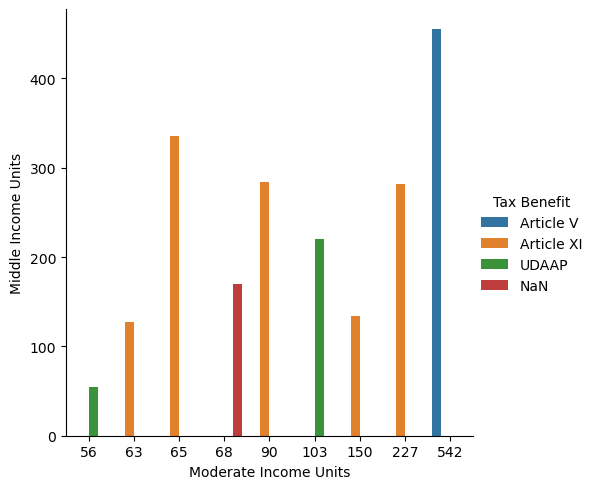

In [183]:
dfEDA = merged_df[(merged_df['Moderate Income Units']>50) & (merged_df['Middle Income Units']>50)]
#Drawing a catplot
sns.catplot(x='Moderate Income Units', y='Middle Income Units', hue='Tax Benefit',
               kind='bar', data=dfEDA);

This graph contrasts moderate income units with the tax benefits they receive, showing a varied application of benefits. Notably, Article V, Article XI and UDAAP appear frequently, indicating their broad applicability in facilitating projects that include moderate income units. This suggests that these benefits are key to balancing project economics to include a mix of income levels.

#### Plot between Total Rental Units and Senior Units, and their Tax Benefit category

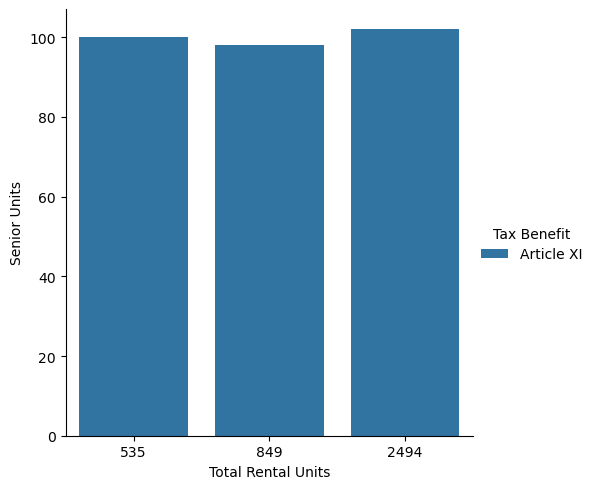

In [184]:
dfEDA = merged_df[(merged_df['Total Rental Units']>400) & (merged_df['Senior Units']>50)]
#Drawing a catplot
sns.catplot(x='Total Rental Units', y='Senior Units', hue='Tax Benefit',
               kind='bar', data=dfEDA);

Similar to the earlier graph with a focus on senior units, this visualization again underscores the use of specific tax benefits in senior housing projects, with a clear predominance of Article XI. This consistent pattern across different visual representations confirms the targeted use of these benefits in supporting housing for the elderly.

## Feature Engineering

### Handling Missing Values

From the EDA analysis we observe that Completion Date and Tax Benefit have missing values. Let us try to fill in the missing values for these columns.

#### Missing Values for Completion Date

We have missing values for Completion Date as these projects are still ongoing and as a result do not have a Completion date.
For our analysis, we can convert the Completion Date to DateTime and fill in the missing values with Current Date.

In [186]:
merged_df['Completion Date'] = pd.to_datetime(merged_df['Completion Date'], format='mixed')

In [187]:
current_date_str = pd.Timestamp.now().strftime('%Y-%m-%d')
merged_df["Completion Date"].fillna(current_date_str,inplace = True)

In [189]:
merged_df["Completion Date"].isna().sum()

0

#### Missing Values for Tax Benefit

In [193]:
merged_df['Tax Benefit'].value_counts()

Tax Benefit
421a             1794
NaN              1582
420c              422
Article XI        411
Article II         36
J-51 Enriched      36
J-51               17
Article V          16
UDAAP              14
420a               11
Article IV          2
Name: count, dtype: int64

In [194]:
merged_df[merged_df['Tax Benefit'] == 'NaN']['Tax Benefit'].value_counts()/len(merged_df)

Tax Benefit
NaN    0.364432
Name: count, dtype: float64

We have 1582 missing values in Tax Benefit column, which is high in number when compared to Tax Benefit 421a which is the highest with value 1794. As 36% of the values are missing, its better to fill the missing values with a new category 'Not Applicable'.

In [195]:
merged_df['Tax Benefit'].replace('NaN', 'Not Applicable', inplace=True)

In [197]:
merged_df['Tax Benefit'].value_counts()

Tax Benefit
421a              1794
Not Applicable    1582
420c               422
Article XI         411
Article II          36
J-51 Enriched       36
J-51                17
Article V           16
UDAAP               14
420a                11
Article IV           2
Name: count, dtype: int64

### Handling Outliers

From the above EDA, we observed several Outliers for all the numerical fields. Handling Outliers depends on the business context.  
For the Housing Prediction analysis, there were some projects which focussed on specific task such as increasing affordable housing units for Low Income Units or Middle Income Units etc. As a result we have outliers in these fields as the number of Units were drastically high in those projects when compared to the rest.   
As such these data values are not fully outliers and they can be handled appropriately during model building.  

### Creating Interaction variables

We create new Interaction features such as, "Project Duration(in Months)","Inception Year","LowEarning Income Units" and "MiddleEarning Income Units" which will help us in analyzing the insights on Housing Prediction.

In [200]:
merged_df["Project Duration"] = (merged_df["Completion Date"] - merged_df["Start Date"])/pd.Timedelta(days=30.44)

In [204]:
merged_df["Project Duration"] = merged_df["Project Duration"].astype(int)

In [206]:
merged_df["Project Duration"].tail()

4336    4
4337    4
4338    4
4339    4
4340    4
Name: Project Duration, dtype: int32

In [208]:
merged_df["Project Duration"].describe()

count    4341.000000
mean       13.531675
std        17.514661
min         0.000000
25%         0.000000
50%         6.000000
75%        22.000000
max       112.000000
Name: Project Duration, dtype: float64

From the above stats, we can infer that the Maximum number of Months a project was under implementation is 112 and the minimum is 0.  
Minimum value of zero indicates that on the Project Start Date, available affordable units were procured and the project implementaion got completed on the same day or in the same month the project was started.

### Creating Indicator Variable

For the Projects that do not have Completion Date, we have assigned Current Date in order to fill in the missing values but these Projects are still ongoing, inorder to differentiate these projects we create an indicator variable named as "Ongoing Project".

In [210]:
merged_df["Ongoing Project"] = ((merged_df["Completion Date"]).dt.date == date.today()).astype(int)

### Research Question 1:
#### Analyzing distribution of units and tax benefits across different program groups

For Analyzing Distribution of units for the given dataset, we create Interaction features, such as "LowEarning Income Units" and "MiddleEarning Income Units".
LowEarning Income Units combines the Units alloted for Extremely Low Income Units + Very Low Income Units + Low Income Units.

In [218]:
merged_df["LowEarning Income Units"] = merged_df["Ext Low Income Units"] + merged_df["Very Low Income Units"] + merged_df["Low Income Units"]

#### Analyzing LowEarning Income Units and their associated Program Groups

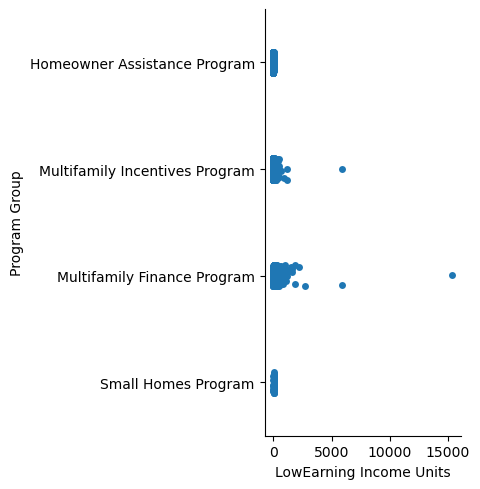

In [213]:
sns.catplot(data=merged_df, x="LowEarning Income Units", y="Program Group")

* The above plot indicates that among the available Program Groups, "Multifamily Finance Program" was frequently associated with Low Earning Income Units.

#### Plot between Program Group and Tax Benefit

<Axes: xlabel='Program Group'>

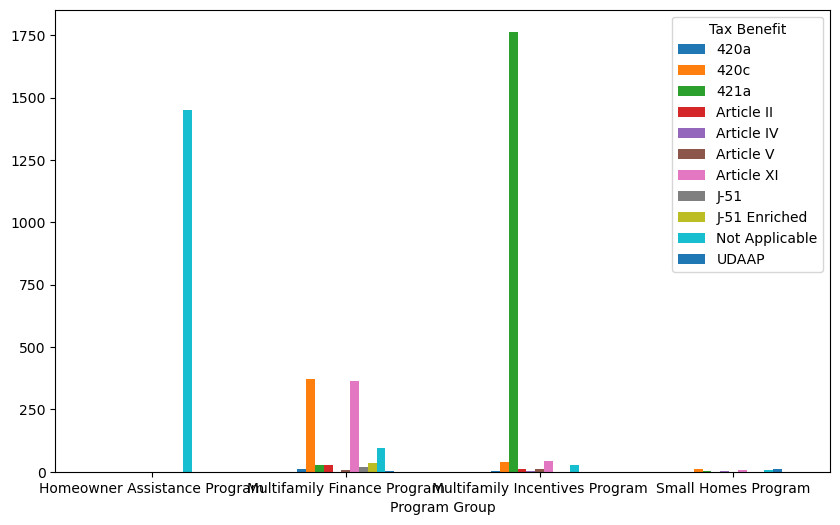

In [215]:
CrosstabResult=pd.crosstab(index=merged_df['Program Group'],columns=merged_df['Tax Benefit'])
#This line helps in plotting the CrosstabResult as a bar chart. 
CrosstabResult.plot.bar(figsize=(10,6), rot=0)

* Among the available Program Group, "Multifamily Incentives Program" was the frequently used with Tax Benefit of "421a"

#### Verifying the Tax Benefit used for LowEarning Income Units

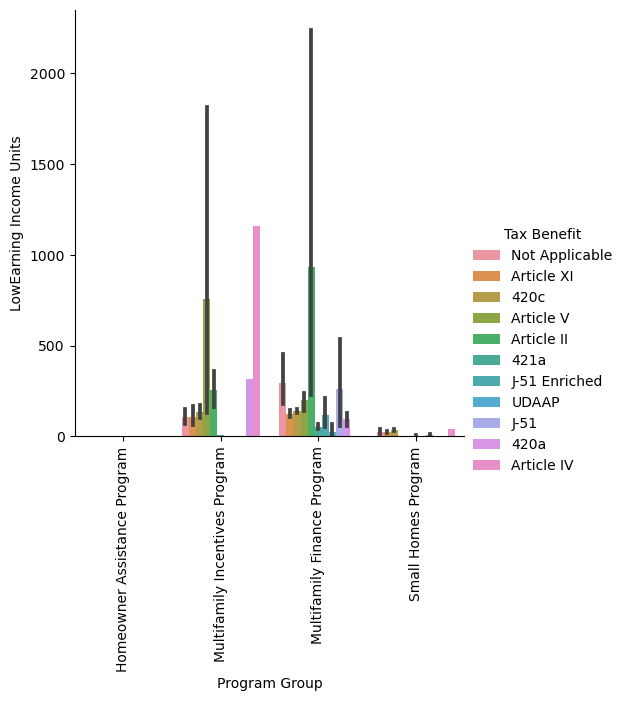

In [221]:
sns.catplot(x='Program Group', y='LowEarning Income Units', hue='Tax Benefit',
               kind='bar', data=merged_df);
plt.xticks(rotation=90)
plt.show()

* For the LowEarning Income Units the most widely used Program Group was Multifamily Finance Program with Tax Benefit of Artice II

###### Verifying the results using groupby clause:

In [223]:
Units_per_programGroup = merged_df.groupby("Program Group")["LowEarning Income Units"].sum().reset_index()

In [224]:
Units_per_programGroup

Program Group  LowEarning Income Units
0    Homeowner Assistance Program                     1347
1     Multifamily Finance Program                   160221
2  Multifamily Incentives Program                    39547
3             Small Homes Program                      821

#### Analyzing for the Program Group and TaX Benefits for Interaction feature ModerateEarning Income Units
ModerateEarning Income Units is the Sum of the features Moderate Income Units and Middle Income Units

In [225]:
merged_df["ModerateEarning Income Units"] = merged_df["Moderate Income Units"]+ merged_df["Middle Income Units"]

#### Analyzing ModerateEarning Income Units and their associated Program Groups

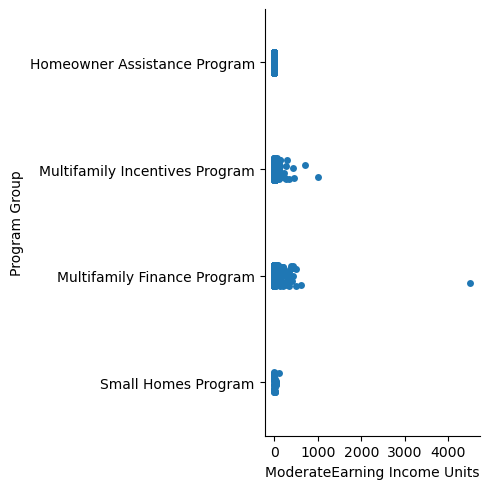

In [231]:
sns.catplot(data=merged_df, x="ModerateEarning Income Units", y="Program Group")

* The above plot indicates that among the available Program Groups, "Multifamily Finance Program" was slightly higher than Multifamily Incentives Program.

#### Verifying the Tax Benefit used for ModerateEarning Income Units

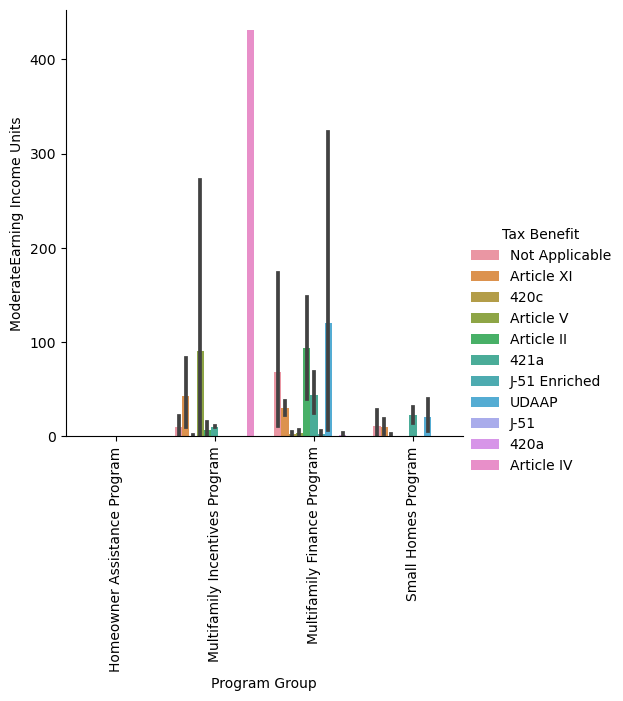

In [232]:
sns.catplot(x='Program Group', y='ModerateEarning Income Units', hue='Tax Benefit',
               kind='bar', data=merged_df);
plt.xticks(rotation=90)
plt.show()

* For the ModerateEarning Income Units the most widely used Program Group was Multifamily Finance Program with Tax Benefit of 421a.

In [229]:
Units_Medium_programGroup = merged_df.groupby("Program Group")["ModerateEarning Income Units"].sum().reset_index()

In [230]:
Units_Medium_programGroup

Program Group  ModerateEarning Income Units
0    Homeowner Assistance Program                           462
1     Multifamily Finance Program                         22743
2  Multifamily Incentives Program                         22052
3             Small Homes Program                           435

### Research Question 2:
#### Analyze trends in affordable housing production over time

We use Project Duration and Year of Completion features to analyze trends in affordable housing over time.

<Axes: xlabel='Project Duration', ylabel='LowEarning Income Units'>

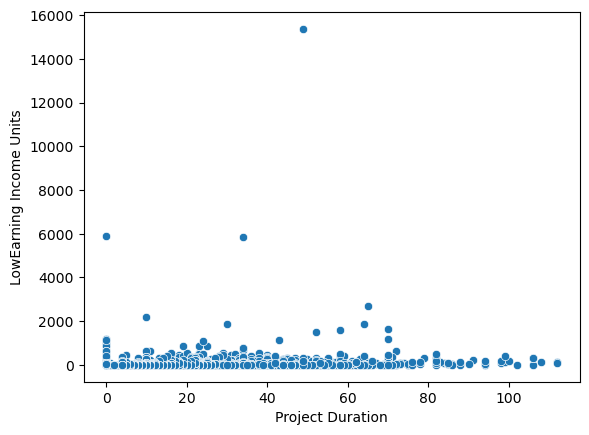

In [239]:
sns.scatterplot(x = merged_df["Project Duration"], y=merged_df["LowEarning Income Units"])

* We notice that despite longer project durations, there is no corresponding increase in the number of LowEarning Income Units. This has to be adressed by Housing Department as long running projects are not yielding any satisfactory results.

<Axes: xlabel='Project Duration', ylabel='ModerateEarning Income Units'>

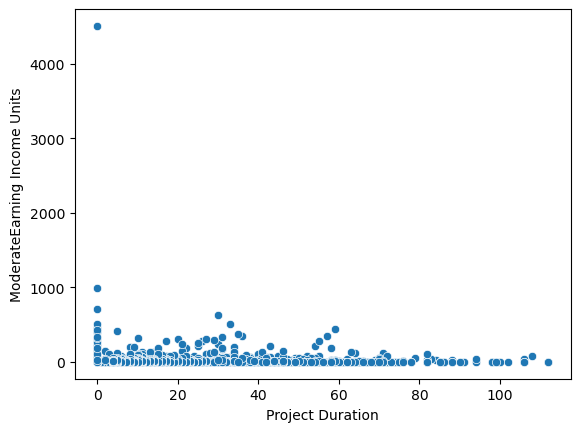

In [240]:
sns.scatterplot(y = merged_df["ModerateEarning Income Units"], x=merged_df["Project Duration"])

* We observe the similar trend for ModerateEarning Income Units the longer running projects are not yielding satisfactory results.

##### For Total Rental Units

<Axes: xlabel='Project Duration', ylabel='Total Rental Units'>

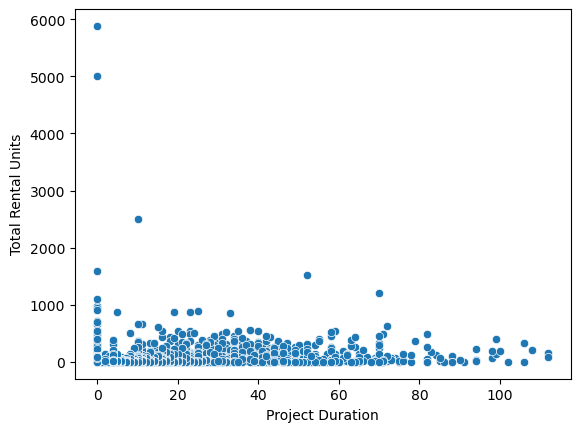

In [241]:
sns.scatterplot(y = merged_df["Total Rental Units"], x=merged_df["Project Duration"])

* We observe that for the longer running projects, the Total Rental Units saw slightly increasing trend till 65 months but post that the number of projects didn't observe any increasing trend. This has to be addressed by Housing Department.

##### For Total Units

<Axes: xlabel='Project Duration', ylabel='Total Units'>

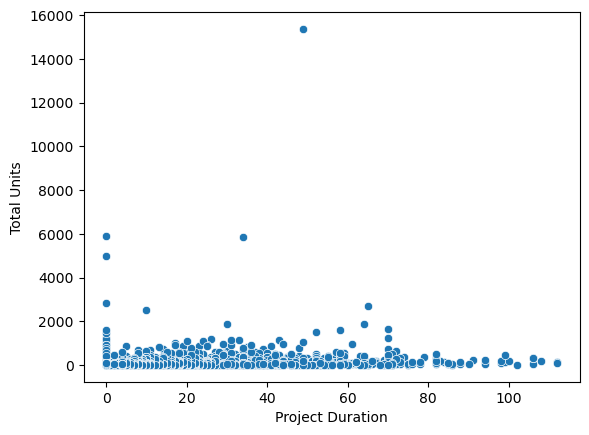

In [242]:
sns.scatterplot(y = merged_df["Total Units"], x=merged_df["Project Duration"])

* Total Units seems to follow the same patters as Total Rental Units.

<Axes: xlabel='Project Duration', ylabel='Senior Units'>

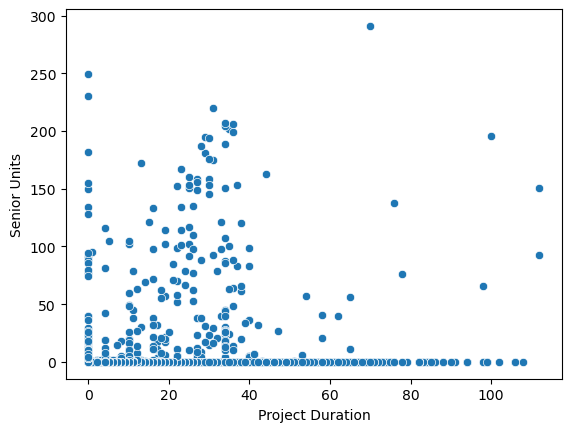

In [245]:
sns.scatterplot(y = merged_df["Senior Units"], x=merged_df["Project Duration"])

* The number of households allocated to Senior Units are very less when comapred with other Rental Units and they saw an increasing trend till 40th month but thereafter we saw a decreasing trend which has to be addressed immediately by Housing Department.

### Analysis based on Project Inception Year

#### Analyzing LowEarning Rental Units based on the Inception Year

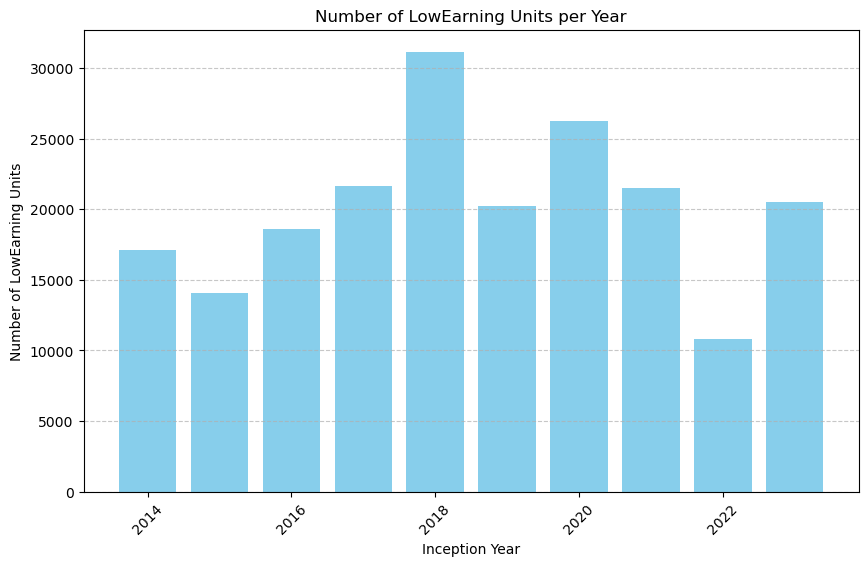

In [268]:
merged_df['Inception Year'] = merged_df['Start Date'].dt.year


# Group by Inception year and calculate the number of LowEarning units each year
lowEarning_units_by_year = merged_df.groupby('Inception Year')['LowEarning Income Units'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(lowEarning_units_by_year['Inception Year'], lowEarning_units_by_year['LowEarning Income Units'], color='skyblue')
plt.xlabel('Inception Year')
plt.ylabel('Number of LowEarning Units')
plt.title('Number of LowEarning Units per Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

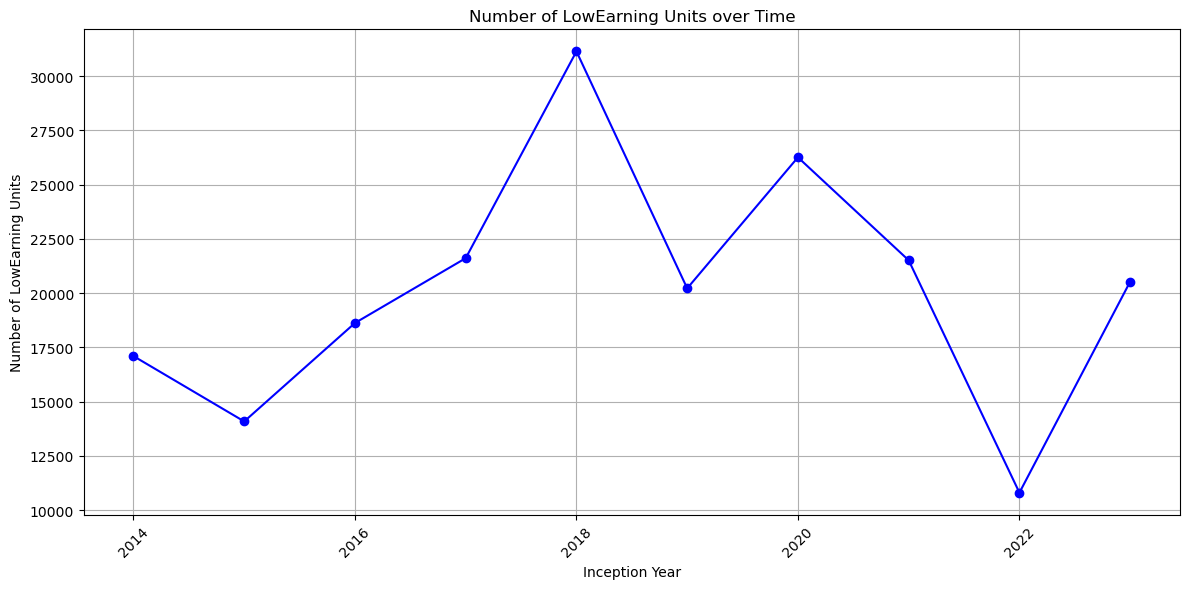

In [267]:
 plt.figure(figsize=(12, 6))
plt.plot(lowEarning_units_by_year['Inception Year'], lowEarning_units_by_year['LowEarning Income Units'], marker='o', linestyle='-', color='b')
plt.xlabel('Inception Year')
plt.ylabel('Number of LowEarning Units')
plt.title('Number of LowEarning Units over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Based on the above time series graph we can infer that the LowEarning Units Constructed followed an increasing trend till 2018 and then decreased till 2022 followed by a slight increase in 2023.

#### Analyzing ModerateEarning Rental Units based on the Inception Year

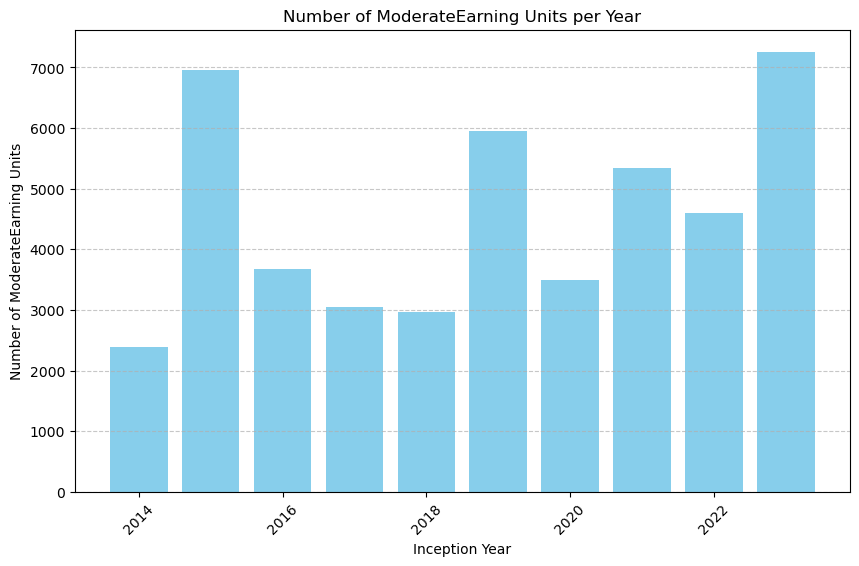

In [269]:
middleEarning_units_by_year = merged_df.groupby('Inception Year')['ModerateEarning Income Units'].sum().reset_index()

# Plotting the Number of ModerateEarning units per year
plt.figure(figsize=(10, 6))
plt.bar(middleEarning_units_by_year['Inception Year'], middleEarning_units_by_year['ModerateEarning Income Units'], color='skyblue')
plt.xlabel('Inception Year')
plt.ylabel('Number of ModerateEarning Units')
plt.title('Number of ModerateEarning Units per Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

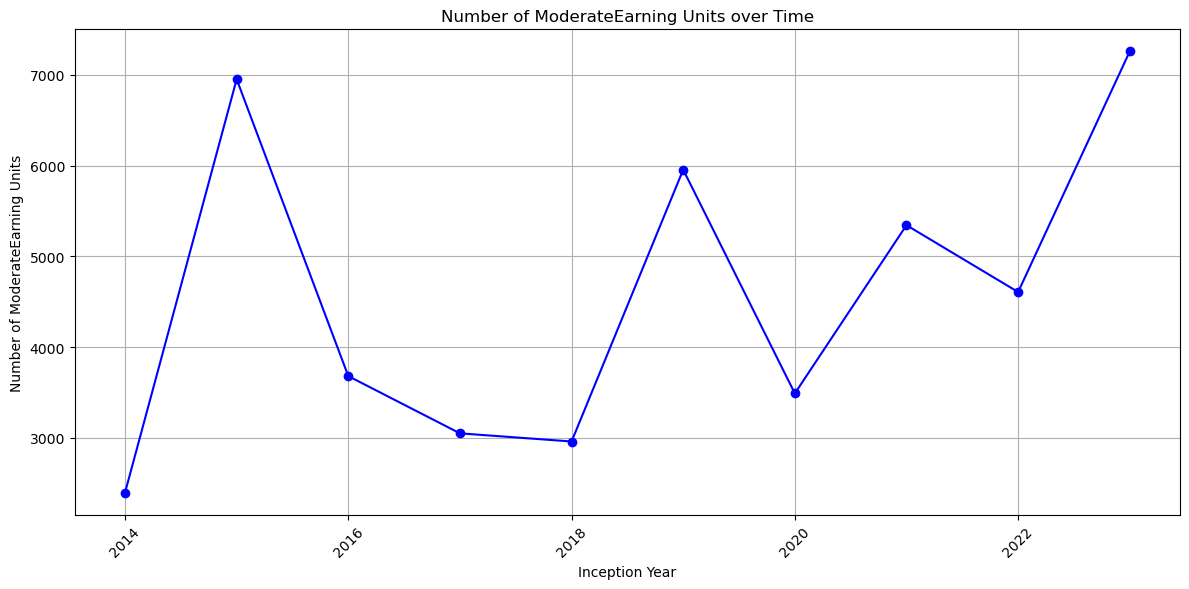

In [270]:
plt.figure(figsize=(12, 6))
plt.plot(middleEarning_units_by_year['Inception Year'], middleEarning_units_by_year['ModerateEarning Income Units'], marker='o', linestyle='-', color='b')
plt.xlabel('Inception Year')
plt.ylabel('Number of ModerateEarning Units')
plt.title('Number of ModerateEarning Units over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Based on the above time series graph we can infer that the ModerateEarning Units Constructed followed an increasing trend till 2015 and then decreased till 2018 and finally followed by an increasing trend from 2020.

##### For Total Rental Units column

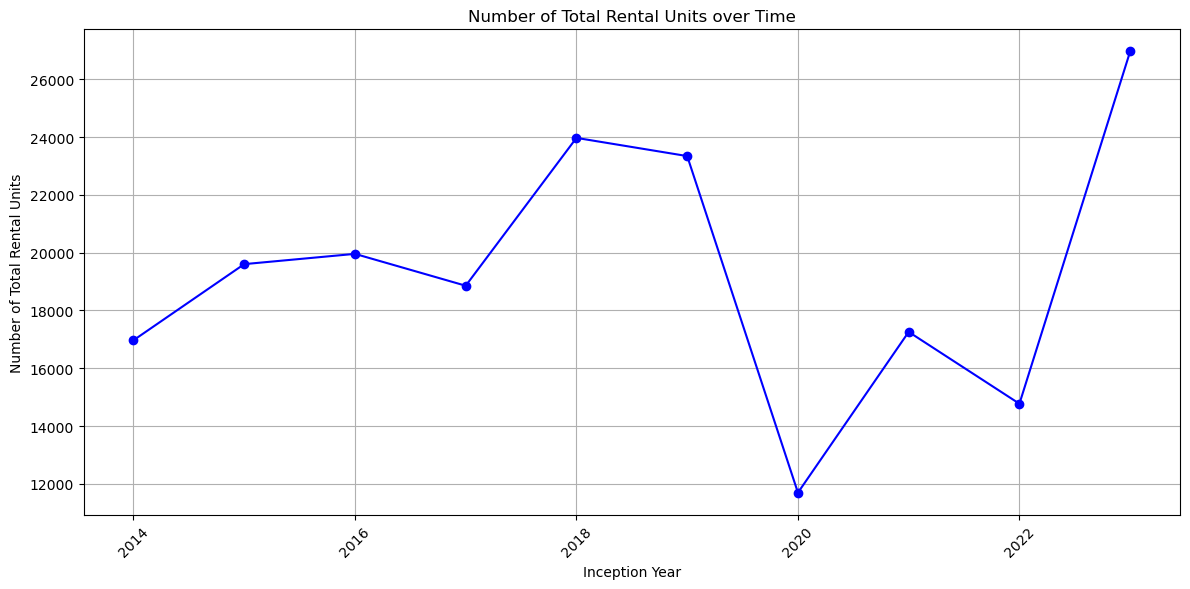

In [271]:
totalRental_units_by_year = merged_df.groupby('Inception Year')['Total Rental Units'].sum().reset_index()

# Plotting the total rental units per year
plt.figure(figsize=(12, 6))
plt.plot(totalRental_units_by_year['Inception Year'], totalRental_units_by_year['Total Rental Units'], marker='o', linestyle='-', color='b')
plt.xlabel('Inception Year')
plt.ylabel('Number of Total Rental Units')
plt.title('Number of Total Rental Units over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Total Rental Units followed increasing trend till 2018 followed by a sharp decrease till 2020 and then increasing trend from 2022.

#### For Total Units column

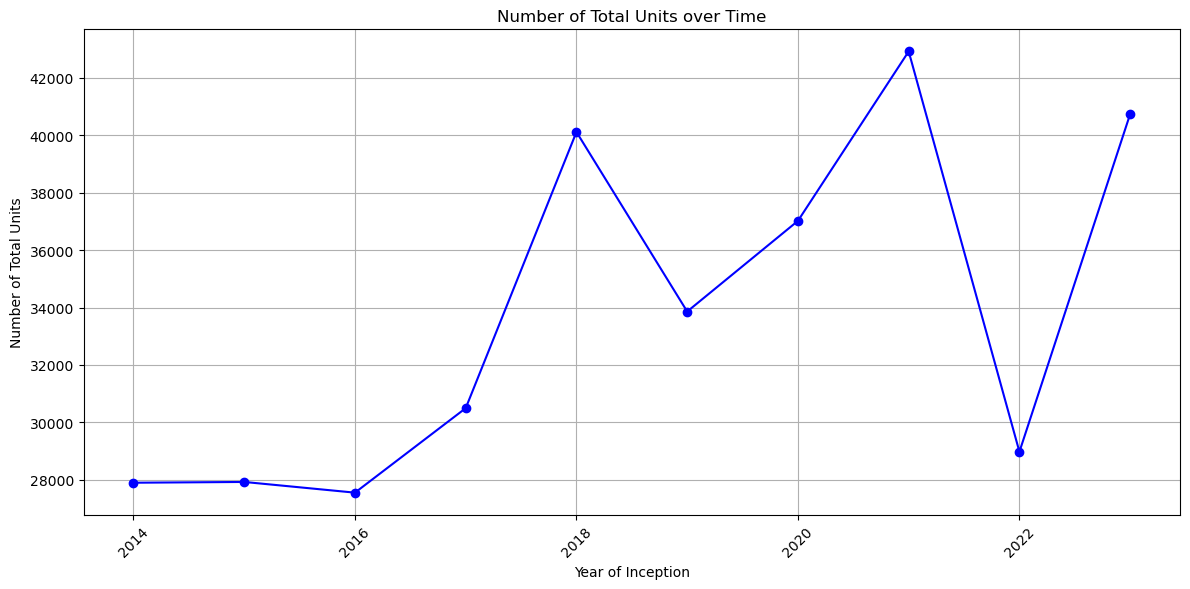

In [272]:
totalunits_by_year = merged_df.groupby('Inception Year')['Total Units'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(totalunits_by_year['Inception Year'], totalunits_by_year['Total Units'], marker='o', linestyle='-', color='b')
plt.xlabel('Year of Inception')
plt.ylabel('Number of Total Units')
plt.title('Number of Total Units over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Total Units followed an increasing trend till 2018 followed by slight decrease and increase, then a sharp decline from 2021 and again increasing trend from 2022.

#### For Senior Units Column

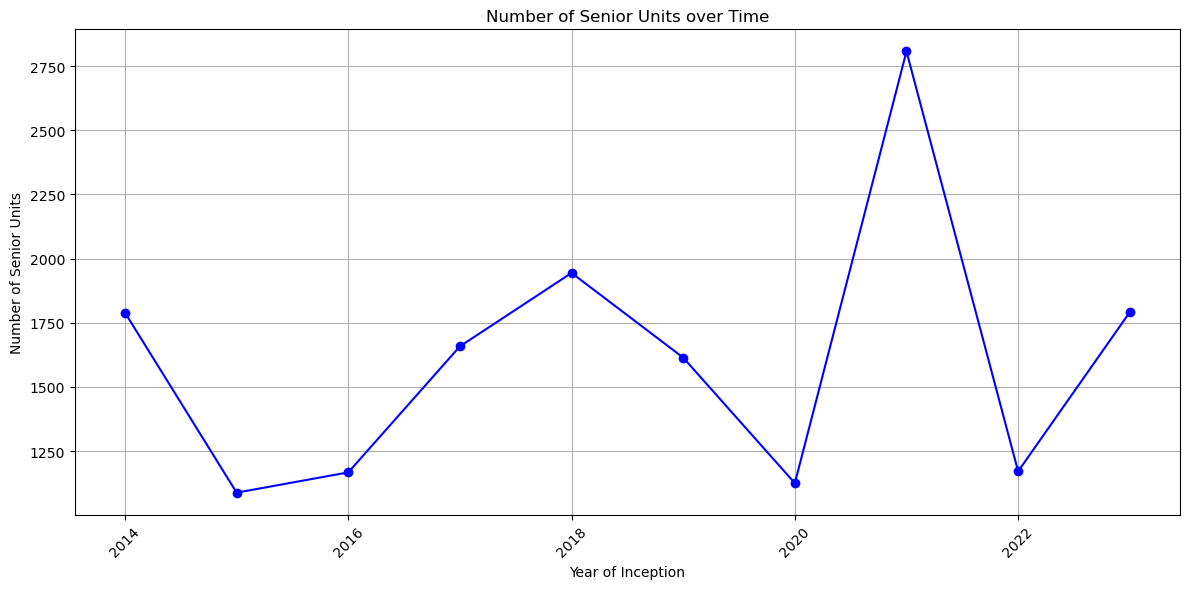

In [273]:
seniorunits_by_year = merged_df.groupby('Inception Year')['Senior Units'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(seniorunits_by_year['Inception Year'], seniorunits_by_year['Senior Units'], marker='o', linestyle='-', color='b')
plt.xlabel('Year of Inception')
plt.ylabel('Number of Senior Units')
plt.title('Number of Senior Units over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Procurement of Senior Units followed a decreasing trend starting from 2014, then it witnessed an increasing trend till 2018 and again a decreasing trend till 2020. 
* From 2020, we have sharp rise and fall of Senior Units.  
* From 2022 it witnessed a slightly increasing trend.  
* The maximum Senior Units acquired were close to 2750 in 2021.  

### Research Question 3

* Linear Regression model helps the Housing department to predict the demands of the units in the coming years so that they can plan their projects and formulate policies to meet the rental demands.

Building Linear  Regression model involves 
* Data Preparation 
* Creating Dummy Variables 
* Scaling the Numerical Columns
* Model Building
* Model Prediction
* Model Evaluation

#### Data Preparation

##### Converting Categorical columns to Numerical Values

In [310]:
dfModel = merged_df
dfModel["Extended Affordability"].replace(['No','Yes'],[0,1], inplace=True)

In [311]:
dfModel["Prevailing Wage Status"].replace(['Non Prevailing Wage','Prevailing Wage'],[0,1], inplace=True)

##### Creating Dummy Variables for Categorical columns with multiple categories

In [312]:
dfDummies = pd.get_dummies(dfModel[['Program Group', 'Tax Benefit']], drop_first = True).astype(int)

In [314]:
dfDummies.head()

Program Group_Multifamily Finance Program  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Program Group_Multifamily Incentives Program  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Program Group_Small Homes Program  Tax Benefit_420c  Tax Benefit_421a  \
0                                  0                 0                 0   
1                                  0                 0                 0   
2                                  0                 0                 0   
3                                  0                 0                 0   
4                                  0                 0                 0   

   Tax Benefit_Article II  Tax Benefit_Article IV  Tax Benefit_Article V  \
0                       0                       0                      0   
1                       0                       0                      0   
2                       0                       0                      0   
3                       0                       0                      0   
4                       0                       0                      0   

   Tax Benefit_Article XI  Tax Benefit_J-51  Tax Benefit_J-51 Enriched  \
0                       0                 0                          0   
1                       0                 0                          0   
2                       0                 0                          0   
3                       0                 0                          0   
4                       0                 0                          0   

   Tax Benefit_Not Applicable  Tax Benefit_UDAAP  
0                           1                  0  
1                           1                  0  
2                           1                  0  
3                           1                  0  
4                           1                  0

* Concatenating the dummy values with original dataframe and dropping the original Categorical Columns

In [315]:
dfModel = pd.concat([dfModel, dfDummies], axis = 1)

In [317]:
dfModel.head()

Project ID  Project Name                 Program Group Start Date  \
0       55759  CONFIDENTIAL  Homeowner Assistance Program 2014-01-03   
1       55647  CONFIDENTIAL  Homeowner Assistance Program 2014-01-07   
2       55773  CONFIDENTIAL  Homeowner Assistance Program 2014-01-10   
3       57341  CONFIDENTIAL  Homeowner Assistance Program 2014-01-10   
4       55697  CONFIDENTIAL  Homeowner Assistance Program 2014-01-14   

  Completion Date  Extended Affordability  Prevailing Wage Status  \
0      2014-01-03                       0                       0   
1      2014-01-07                       0                       0   
2      2014-01-10                       0                       0   
3      2014-01-10                       0                       0   
4      2014-01-14                       0                       0   

      Tax Benefit  Ext Low Income Units  Very Low Income Units  ...  \
0  Not Applicable                     0                      0  ...   
1  Not Applicable                     0                      0  ...   
2  Not Applicable                     0                      0  ...   
3  Not Applicable                     0                      0  ...   
4  Not Applicable                     0                      0  ...   

   Tax Benefit_420c  Tax Benefit_421a  Tax Benefit_Article II  \
0                 0                 0                       0   
1                 0                 0                       0   
2                 0                 0                       0   
3                 0                 0                       0   
4                 0                 0                       0   

   Tax Benefit_Article IV  Tax Benefit_Article V  Tax Benefit_Article XI  \
0                       0                      0                       0   
1                       0                      0                       0   
2                       0                      0                       0   
3                       0                      0                       0   
4                       0                      0                       0   

   Tax Benefit_J-51  Tax Benefit_J-51 Enriched  Tax Benefit_Not Applicable  \
0                 0                          0                           1   
1                 0                          0                           1   
2                 0                          0                           1   
3                 0                          0                           1   
4                 0                          0                           1   

   Tax Benefit_UDAAP  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 37 columns]

In [318]:
dfModel.drop(['Program Group','Tax Benefit'], axis = 1, inplace = True)

dfModel.head()

Project ID  Project Name Start Date Completion Date  \
0       55759  CONFIDENTIAL 2014-01-03      2014-01-03   
1       55647  CONFIDENTIAL 2014-01-07      2014-01-07   
2       55773  CONFIDENTIAL 2014-01-10      2014-01-10   
3       57341  CONFIDENTIAL 2014-01-10      2014-01-10   
4       55697  CONFIDENTIAL 2014-01-14      2014-01-14   

   Extended Affordability  Prevailing Wage Status  Ext Low Income Units  \
0                       0                       0                     0   
1                       0                       0                     0   
2                       0                       0                     0   
3                       0                       0                     0   
4                       0                       0                     0   

   Very Low Income Units  Low Income Units  Moderate Income Units  ...  \
0                      0                 0                      0  ...   
1                      0                 0                      0  ...   
2                      0                 0                      0  ...   
3                      0                 1                      0  ...   
4                      0                 0                      0  ...   

   Tax Benefit_420c  Tax Benefit_421a  Tax Benefit_Article II  \
0                 0                 0                       0   
1                 0                 0                       0   
2                 0                 0                       0   
3                 0                 0                       0   
4                 0                 0                       0   

   Tax Benefit_Article IV  Tax Benefit_Article V  Tax Benefit_Article XI  \
0                       0                      0                       0   
1                       0                      0                       0   
2                       0                      0                       0   
3                       0                      0                       0   
4                       0                      0                       0   

   Tax Benefit_J-51  Tax Benefit_J-51 Enriched  Tax Benefit_Not Applicable  \
0                 0                          0                           1   
1                 0                          0                           1   
2                 0                          0                           1   
3                 0                          0                           1   
4                 0                          0                           1   

   Tax Benefit_UDAAP  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 35 columns]

##### Checking for Correlations

<Axes: >

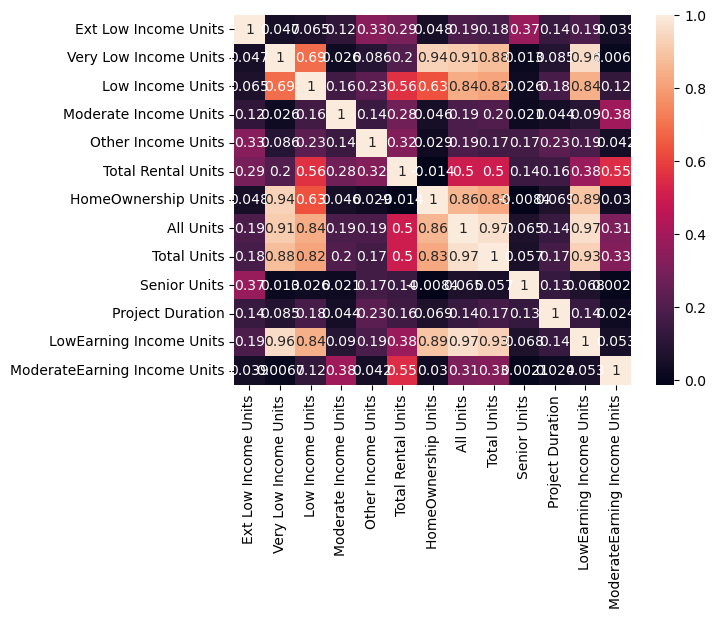

In [319]:
sns.heatmap(dfModel[['Ext Low Income Units',
              'Very Low Income Units','Low Income Units','Moderate Income Units','Other Income Units',
              'Total Rental Units','HomeOwnership Units','All Units','Total Units','Senior Units','Project Duration',
                    'LowEarning Income Units','ModerateEarning Income Units']].corr()
            , annot=True)

* Low Income Units and Very Low Income Units are highly correlated with LowEarning Income Units, hence these two features can be dropped for model building.
* As our target variable is All Units, it has high correlation with HomeOwnership Units and Total Rental Units, therefore these features will not be considered for model building

#### Handling Outliers

* As the data is highly skewed with the presence of several outliers, we restrict our data for minimum project Duration of 12 months and All Units to be atmost 1000 which helps us in predicting the Rental Units accurately without bias.

In [320]:
XProj = dfModel[(dfModel['Project Duration'] > 12) & (dfModel['All Units'] < 1000)]
XProj

Project ID                    Project Name Start Date Completion Date  \
370        50196                 Belmont Venezia 2014-01-22      2015-04-13   
428        50193                   Nelson Luquer 2014-06-13      2015-08-13   
433        65123                       THE STACK 2014-03-14      2015-08-31   
443        50258                      New Walton 2014-06-19      2015-10-26   
452        55500                   Carnegie Park 2014-05-14      2015-11-12   
...          ...                             ...        ...             ...   
3806       73666              32-18 UNION STREET 2023-03-29      2024-05-06   
3807       73667      1009 NELSON AVE APARTMENTS 2023-03-29      2024-05-06   
3808       71541         BG. 97-04 SUTPHIN BLVD. 2023-03-30      2024-05-06   
3811       72110  BK-2715 FULTON STREET_MIH72082 2023-04-03      2024-05-06   
3812       74173                 99-49 66 AVENUE 2023-04-04      2024-05-06   

      Extended Affordability  Prevailing Wage Status  Ext Low Income Units  \
370                        0                       0                     0   
428                        0                       0                     0   
433                        0                       0                     0   
443                        0                       0                     0   
452                        0                       0                     0   
...                      ...                     ...                   ...   
3806                       0                       0                     0   
3807                       0                       0                     0   
3808                       0                       1                   172   
3811                       0                       0                     0   
3812                       0                       0                     0   

      Very Low Income Units  Low Income Units  Moderate Income Units  ...  \
370                       0               177                      0  ...   
428                       0                44                      0  ...   
433                       0                 6                      0  ...   
443                       0                85                      0  ...   
452                       0                92                      0  ...   
...                     ...               ...                    ...  ...   
3806                      0                 0                      0  ...   
3807                      0                 0                      0  ...   
3808                      0                 0                      0  ...   
3811                      7                 5                      3  ...   
3812                      0                 0                      0  ...   

      Tax Benefit_420c  Tax Benefit_421a  Tax Benefit_Article II  \
370                  0                 0                       0   
428                  1                 0                       0   
433                  0                 1                       0   
443                  1                 0                       0   
452                  1                 0                       0   
...                ...               ...                     ...   
3806                 0                 1                       0   
3807                 0                 1                       0   
3808                 1                 0                       0   
3811                 0                 1                       0   
3812                 0                 1                       0   

      Tax Benefit_Article IV  Tax Benefit_Article V  Tax Benefit_Article XI  \
370                        0                      0                       1   
428                        0                      0                       0   
433                        0                      0                       0   
443                        0                      0           

* The main indicator varaible LowEarning Income Units shows linear relationship with the target variable __All Units__ we can proceed with Linear Regression model to predict the Rental Units for the future needs. 

<Axes: xlabel='LowEarning Income Units', ylabel='All Units'>

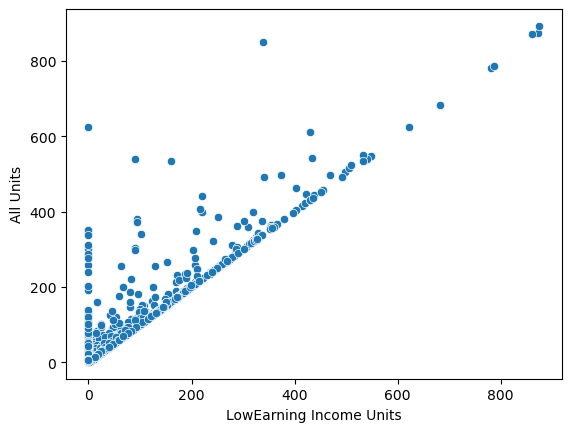

In [321]:
sns.scatterplot(x=XProj["LowEarning Income Units"], y=XProj["All Units"])

#### Model Building

* Dropping the correlated features and other features such as Project ID and Project Name containing unique values which are not required for model building.
* Therefore we only select all the relevant numerical features for prediction purpose.

In [327]:
X = XProj[['Extended Affordability',
           'Prevailing Wage Status','Project Duration','Program Group_Multifamily Finance Program',
          'Program Group_Multifamily Incentives Program','Program Group_Small Homes Program',                      
           'LowEarning Income Units',           
           'Senior Units','Other Income Units',
           'Ongoing Project',           
           'Tax Benefit_420c',
          'Tax Benefit_421a','Tax Benefit_Article II','Tax Benefit_Article IV','Tax Benefit_Article V',
           'Tax Benefit_Article XI','Tax Benefit_J-51',
           'Tax Benefit_Not Applicable','Tax Benefit_UDAAP','Tax Benefit_J-51 Enriched']]

##### Assigning target variable __All Units__ to __y__ dataframe

In [323]:
y = XProj[["All Units"]]

##### Using MinMaxScaler for Scaling the Numerical columns

In [328]:
scaler = MinMaxScaler()
num_vars = ['Project Duration', 
           'LowEarning Income Units',                        
            'Senior Units','Other Income Units']

XProj[num_vars] = scaler.fit_transform(XProj[num_vars])

XProj.head()

Project ID     Project Name Start Date Completion Date  \
370       50196  Belmont Venezia 2014-01-22      2015-04-13   
428       50193    Nelson Luquer 2014-06-13      2015-08-13   
433       65123        THE STACK 2014-03-14      2015-08-31   
443       50258       New Walton 2014-06-19      2015-10-26   
452       55500    Carnegie Park 2014-05-14      2015-11-12   

     Extended Affordability  Prevailing Wage Status  Ext Low Income Units  \
370                       0                       0                   0.0   
428                       0                       0                   0.0   
433                       0                       0                   0.0   
443                       0                       0                   0.0   
452                       0                       0                   0.0   

     Very Low Income Units  Low Income Units  Moderate Income Units  ...  \
370                      0               177                    0.0  ...   
428                      0                44                    0.0  ...   
433                      0                 6                    0.0  ...   
443                      0                85                    0.0  ...   
452                      0                92                    0.0  ...   

     Tax Benefit_420c  Tax Benefit_421a  Tax Benefit_Article II  \
370                 0                 0                       0   
428                 1                 0                       0   
433                 0                 1                       0   
443                 1                 0                       0   
452                 1                 0                       0   

     Tax Benefit_Article IV  Tax Benefit_Article V  Tax Benefit_Article XI  \
370                       0                      0                       1   
428                       0                      0                       0   
433                       0                      0                       0   
443                       0                      0                       0   
452                       0                      0                       0   

     Tax Benefit_J-51  Tax Benefit_J-51 Enriched  Tax Benefit_Not Applicable  \
370                 0                          0                           0   
428                 0                          0                           0   
433                 0                          0                           0   
443                 0                          0                           0   
452                 0                          0                           0   

     Tax Benefit_UDAAP  
370                  0  
428                  0  
433                  0  
443                  0  
452                  0  

[5 rows x 35 columns]

##### Using train_test_split to split the input dataframe to Training and Test Datasets

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Implementing Linear Regression Model

* We use __Recursive Feature Elimination__ technique and selected the top 10 features which helps us in predicting the Rental Units.

In [332]:
lmop = LinearRegression()
lmop.fit(X_train, y_train)

rfe = RFE(estimator=lmop, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

* List displaying the features that are selected by RFE for model prediction

In [333]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Extended Affordability', False, 9),
 ('Prevailing Wage Status', False, 4),
 ('Project Duration', False, 5),
 ('Program Group_Multifamily Finance Program', True, 1),
 ('Program Group_Multifamily Incentives Program', False, 2),
 ('Program Group_Small Homes Program', True, 1),
 ('LowEarning Income Units', True, 1),
 ('Senior Units', True, 1),
 ('Other Income Units', True, 1),
 ('Ongoing Project', False, 8),
 ('Tax Benefit_420c', False, 3),
 ('Tax Benefit_421a', True, 1),
 ('Tax Benefit_Article II', True, 1),
 ('Tax Benefit_Article IV', False, 11),
 ('Tax Benefit_Article V', False, 10),
 ('Tax Benefit_Article XI', True, 1),
 ('Tax Benefit_J-51', False, 6),
 ('Tax Benefit_Not Applicable', True, 1),
 ('Tax Benefit_UDAAP', True, 1),
 ('Tax Benefit_J-51 Enriched', False, 7)]

In [334]:
col = X_train.columns[rfe.support_]
col

Index(['Program Group_Multifamily Finance Program',
       'Program Group_Small Homes Program', 'LowEarning Income Units',
       'Senior Units', 'Other Income Units', 'Tax Benefit_421a',
       'Tax Benefit_Article II', 'Tax Benefit_Article XI',
       'Tax Benefit_Not Applicable', 'Tax Benefit_UDAAP'],
      dtype='object')

In [335]:
X_train.columns[~rfe.support_]

Index(['Extended Affordability', 'Prevailing Wage Status', 'Project Duration',
       'Program Group_Multifamily Incentives Program', 'Ongoing Project',
       'Tax Benefit_420c', 'Tax Benefit_Article IV', 'Tax Benefit_Article V',
       'Tax Benefit_J-51', 'Tax Benefit_J-51 Enriched'],
      dtype='object')

In [336]:
X_train_rfe = X_train[col]

In [337]:
X_train_rfe.head()

Program Group_Multifamily Finance Program  \
3053                                          0   
2527                                          1   
3618                                          0   
2098                                          1   
2862                                          1   

      Program Group_Small Homes Program  LowEarning Income Units  \
3053                                  0                 0.051429   
2527                                  0                 0.107429   
3618                                  0                 0.018286   
2098                                  0                 0.138286   
2862                                  0                 0.180571   

      Senior Units  Other Income Units  Tax Benefit_421a  \
3053      0.154639            0.000000                 1   
2527      0.000000            0.090909                 0   
3618      0.000000            0.000000                 1   
2098      0.415808            0.090909                 0   
2862      0.000000            0.090909                 0   

      Tax Benefit_Article II  Tax Benefit_Article XI  \
3053                       0                       0   
2527                       0                       0   
3618                       0                       0   
2098                       0                       0   
2862                       0                       0   

      Tax Benefit_Not Applicable  Tax Benefit_UDAAP  
3053                           0                  0  
2527                           0                  0  
3618                           0                  0  
2098                           0                  0  
2862                           0                  0

##### Fitting the model on training dataset

In [340]:
X_train_scaled = scaler.fit_transform(X_train_rfe)
X_train_lm = sm.add_constant(X_train_scaled)

In [341]:
lmop = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

##### Summarizing the model statistics
The summary results from the model shows the model can explain about 85% variance in the data and all the P-values for the features selected by RFE are significant.

In [342]:
print(lmop.summary())

                            OLS Regression Results                            
Dep. Variable:              All Units   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     944.6
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        04:01:28   Log-Likelihood:                -6450.1
No. Observations:                1270   AIC:                         1.292e+04
Df Residuals:                    1259   BIC:                         1.298e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.8929      4.748     -4.189      0.0

##### Predicting the values on Training Dataset

In [343]:
y_train_predict = lmop.predict(X_train_lm)

In [344]:
y_train_predict = y_train_predict.reshape(-1,1)

Text(0, 0.5, 'Predicted Values')

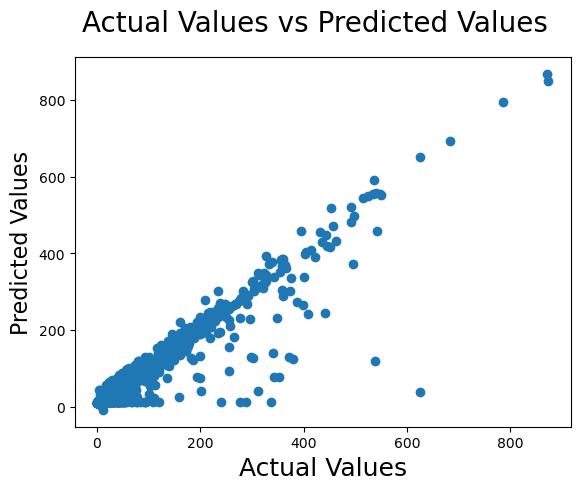

In [346]:
fig = plt.figure()
plt.scatter(y_train.values,y_train_predict)
fig.suptitle('Actual Values vs Predicted Values', fontsize=20)              # Plot heading 
plt.xlabel('Actual Values', fontsize=18)                          # X-label
plt.ylabel('Predicted Values', fontsize=16) 

##### Predicting the values on Test Dataset

In [347]:
X_test_new = X_test[X_train_rfe.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)
y_test_predict = lmop.predict(X_test_new)

Text(0, 0.5, 'Predicted Values')

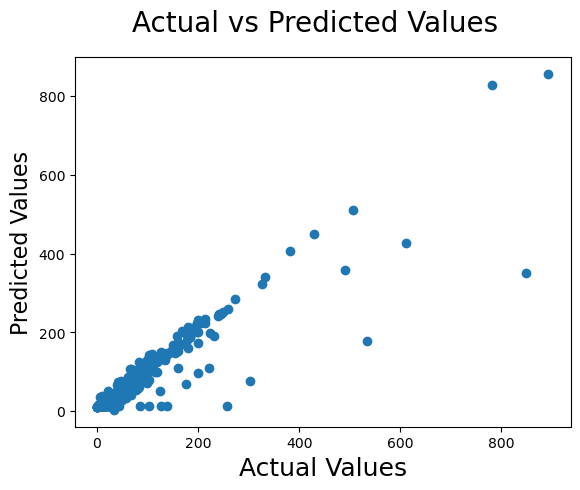

In [349]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_predict)
fig.suptitle('Actual vs Predicted Values', fontsize=20)              # Plot heading 
plt.xlabel('Actual Values', fontsize=18)                          # X-label
plt.ylabel('Predicted Values', fontsize=16)                          # Y-label

* The above linear regression model will help Housing Development Authority to make predictions about Rental Units given other dependent indicators.

### Research Question 4
#### Percentage of affordable housing units that are designated for LowIncome households and ModerateIncome households

We can consider calculating percentage of LowEarning Income Units which is a sum of all LowIncome Units and then also calculate the Percentage for each of Extremely Low Income Units, Very Low Income Units and Low Income Units to check for the distribution among Low Income Households.

In [277]:
percet_LowEarning_Units = merged_df["LowEarning Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of LowEarning Income Units are ", percet_LowEarning_Units)

Percentage of LowEarning Income Units are  59.83412989306445


The above percent shows that among all the Units acquired around 60% of the Units were for the LowEarning Households.  
Let us check for the categories under LowEarning Households.

##### Calculating Percentage for Extremely Low Income Units

In [278]:
percet_ExtLowIncome_Units = merged_df["Ext Low Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of Extremely Low Income Units are ", percet_ExtLowIncome_Units)

Percentage of Extremely Low Income Units are  12.556704879804915


Only 12% of the Units that were accrued by Housing Departmrent were for the Extremely Low Income Households.  
This has to be increased significantly by the Housing Departmrent team.

##### Calculating Percentage for Very Low Income Units

In [280]:
percet_VeryLowIncome_Units = merged_df["Very Low Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of Very Low Income Units are ", percet_VeryLowIncome_Units)

Percentage of Very Low Income Units are  20.899100129484165


* 20% of the Units that were accrued by Housing Departmrent were for the Very Low Income Households.

##### Calculating Percentage for Low Income Units

In [281]:
percet_LowIncome_Units = merged_df["Low Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of Low Income Units are ", percet_LowIncome_Units)

Percentage of Low Income Units are  26.378324883775367


* Percentage Units allocated to of Low Income Units are highger among all the categories of Lowearning Income households.

#### Calculating Percentage for ModerateEarning Income Units

We calculate percentage of ModerateEarning Income Units which is a sum of Moderate Income Units and Middle Income Units.  
We also calculate the Percentage for Moderate Income Units and Middle Income Units to check for the distribution among Moderate Earning Income Households.

In [286]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Project ID                    4341 non-null   int64         
 1   Project Name                  4341 non-null   object        
 2   Program Group                 4341 non-null   object        
 3   Start Date                    4341 non-null   datetime64[ns]
 4   Completion Date               4341 non-null   datetime64[ns]
 5   Extended Affordability        4341 non-null   object        
 6   Prevailing Wage Status        4341 non-null   object        
 7   Tax Benefit                   4341 non-null   object        
 8   Ext Low Income Units          4341 non-null   int64         
 9   Very Low Income Units         4341 non-null   int64         
 10  Low Income Units              4341 non-null   int64         
 11  Moderate Income Units         

In [287]:
percet_ModerateEarning_Units = merged_df["ModerateEarning Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of ModerateEarning Income Units are ", percet_ModerateEarning_Units)

Percentage of ModerateEarning Income Units are  13.538651172024307


* Only 13% of the Accrued units were for the ModerateEarning Income households.  
Let us check for the Moderate Income Units and Middle Income Units.

##### Percentage of Moderate Income Units

In [288]:
percet_Moderate_Income_Units = merged_df["Moderate Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of Moderate Income Units are ", percet_Moderate_Income_Units)

Percentage of Moderate Income Units are  4.65817068798464


* The percentage allocated for Moderate Income Units is very less and it has to be addressed by the Housing Department.

##### Percentage of Middle Income Units

In [289]:
percet_Middle_Income_Units = merged_df["Middle Income Units"].sum()/merged_df["Total Units"].sum() * 100
print("Percentage of Middle Income Units are ", percet_Middle_Income_Units)

Percentage of Middle Income Units are  8.88048048403967


* Percentage allocated for Middle Income Units is higher when compared to Moderate Income Units but this percentage has to be increased by the Housing Department.

* Overall, the higher percentage units were allocated for LowEarning Income Units when compared with ModerateEarning Income Units but these percentages has to be increased for the coming years in order to address the House rental crisis.

### Reserach Question 5:
#### Analyzing the distribution of Rental Units, HomeOwnership Units, and Total Counted Units

We plot histogram and box plots to analyze the distribution of Total Rental Units, HomeOwnership Units, and Total Counted Units.  
We also find the projects were highest units were assigned to these units.

<Axes: xlabel='Total Rental Units', ylabel='Density'>

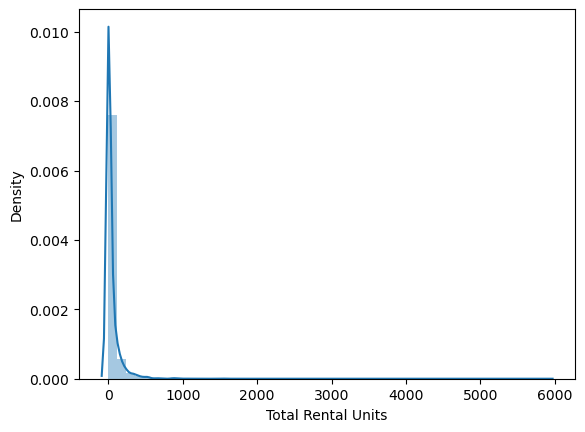

In [290]:
sns.distplot(merged_df['Total Rental Units'], kde=True)

* Histogram Plot for Total Rental Units shows the distribution is highly skewed with mean at 0 and the highest number of Total Rental Units allocated were close to 6000.

<Axes: xlabel='HomeOwnership Units', ylabel='Density'>

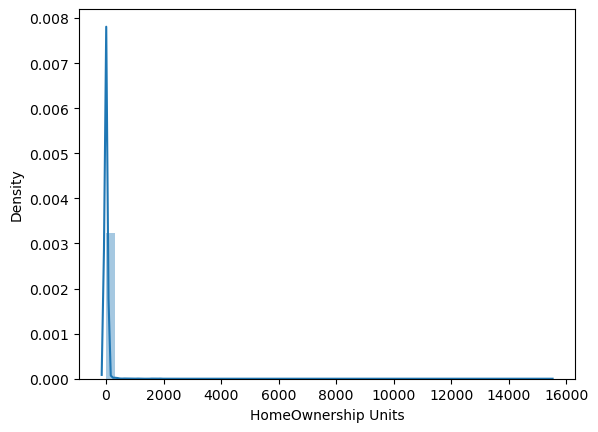

In [292]:
sns.distplot(merged_df['HomeOwnership Units'], kde=True)

* Similar to the Total Rental Units, frequency distribution plot for HomeOwnership Units shows the distribution is highly skewed with mean at 0, and the highest number of HomeOwnership Units allocated were close to 16000 considerably higher than Total Rental Units.

<Axes: xlabel='Total Units', ylabel='Density'>

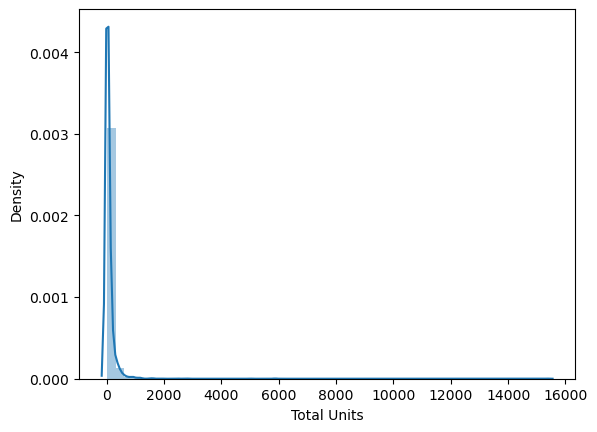

In [293]:
sns.distplot(merged_df['Total Units'], kde=True)

* Frequency Distribution plot for Total Units is similar to  HomeOwnership Units.
* Distribution is highly skewed and the maximum number of units are close to 16000 similar to  HomeOwnership Units. 
* This shows a strong correlation between HomeOwnership Units and Total Units.

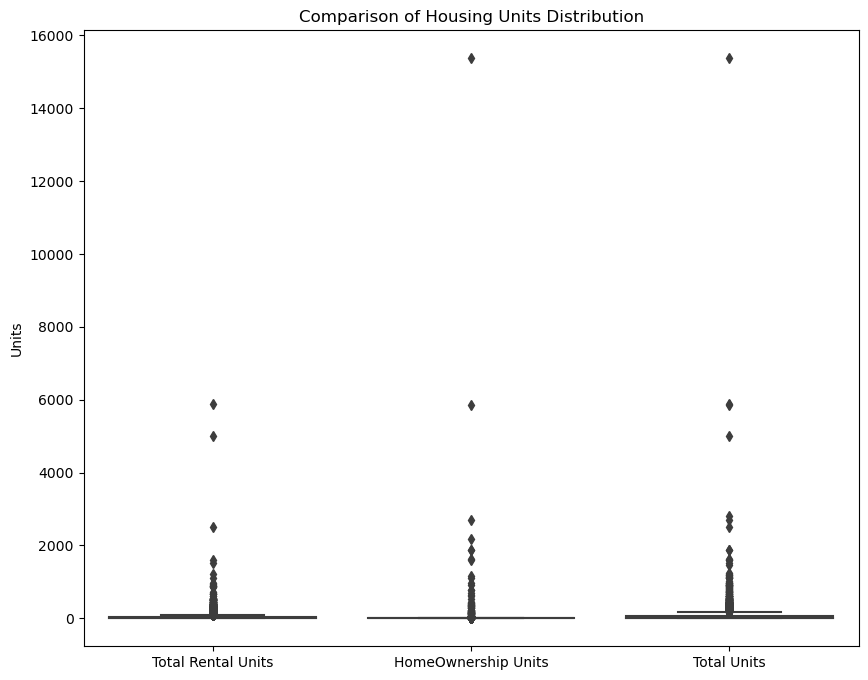

In [295]:
plt.figure(figsize=(10, 8))

# Create a box plot to compare the distribution of units
sns.boxplot(data=merged_df[['Total Rental Units', 'HomeOwnership Units', 'Total Units']])
plt.title('Comparison of Housing Units Distribution')
plt.ylabel('Units')

# Show the plot
plt.show()

* All the three Total Rental Units, HomeOwnership Units and Total Units clearly shows the presence of outliers.  
Let us find the Projects which were suited for these Units:

In [297]:
merged_df[(merged_df['Total Rental Units']> 10) & (merged_df['HomeOwnership Units']>10) & (merged_df['Total Units'] > 10)]

Project ID                                       Project Name  \
1140       49562                                 1711 Davidson HDFC   
1485       53017  Nehemiah Spring Creek Homes at Gateway Estates 4A   
2289       44340                                      BLAKE/HENDRIX   
2823       52461                        92 St. Nicholas Avenue HDFC   
2830       58555                             MOTHER GASTON-HINSDALE   
2875       64390              COOPER SQUARE MHA - PHASE 1.GHPP.FY20   
2899       65315                 BED STUY CENTRAL AND NORTH PHASE I   

                    Program Group Start Date Completion Date  \
1140  Multifamily Finance Program 2015-02-06      2018-06-21   
1485          Small Homes Program 2016-06-27      2019-05-28   
2289          Small Homes Program 2018-05-30      2021-10-28   
2823  Multifamily Finance Program 2016-07-01      2024-05-06   
2830          Small Homes Program 2018-06-19      2024-05-06   
2875  Multifamily Finance Program 2020-03-31      2024-05-06   
2899  Multifamily Finance Program 2021-06-30      2024-05-06   

     Extended Affordability Prevailing Wage Status     Tax Benefit  \
1140                     No    Non Prevailing Wage   J-51 Enriched   
1485                     No    Non Prevailing Wage           UDAAP   
2289                     No    Non Prevailing Wage           UDAAP   
2823                     No    Non Prevailing Wage   J-51 Enriched   
2830                     No    Non Prevailing Wage  Not Applicable   
2875                     No    Non Prevailing Wage      Article XI   
2899                     No    Non Prevailing Wage           UDAAP   

      Ext Low Income Units  Very Low Income Units  ...  Total Rental Units  \
1140                     0                     48  ...                  39   
1485                     0                      0  ...                  27   
2289                     0                      0  ...                  17   
2823                     7                     36  ...                  13   
2830                     0                      0  ...                  33   
2875                   203                    124  ...                  35   
2899                     0                      0  ...                  20   

      HomeOwnership Units  All Units  Total Units  Senior Units  \
1140                   47         86           86             0   
1485                   83        110          110             0   
2289                   13         30           30             0   
2823                   43         56           56             0   
2830                   17         50           50             0   
2875                  292        327          327             0   
2899                   11         31           31             0   

      Project Duration  Ongoing Project  LowEarning Income Units  \
1140                40                0                       86   
1485                34                0                        0   
2289                40                0                        0   
2823                94                1                       55   
2830                70                1                        0   
2875                49                1                      327   
2899                34                1                        0   

      ModerateEarning Income Units  Inception Year  
1140                             0            2015  
1485                           110            2016  
2289                            30            2018  
2823                             0            2016  
2830                            50            2018  
2875                             0            2020  
2899                            31            2021  

[7 rows x 24 columns]

* The above result shows there were only 7 projects which had minimum of 10 Units allocated for each of Total Rental Units, HomeOwnership Units and Total Units.
* This shows that Projects were catered to serve specific Income Units.
* There is a need to cretae Projects which serve all the types of Income Units especially Low and Middle Earning Households.
* Housing Department can consider the policies implemented under the projects __COOPER SQUARE MHA - PHASE 1.GHPP.FY20__ and __Nehemiah Spring Creek Homes at Gateway Estates 4A__ when designing future projects.

##### Analyzing Projects for Total Rental Units

In [298]:
merged_df[merged_df['Total Rental Units']> 1000]

Project ID                                 Project Name  \
472        59857               Stuy Town Peter Cooper Village   
689        63373  Arverne View Apartments (AKA Ocean Village)   
1117       67403                                STARRETT CITY   
1671       69118                        KNICKERBOCKER VILLAGE   
2894       65227                  DIEGO BEEKMAN MHA.GHPP.FY18   
2967       68432       LINDEN PLAZA PRESERVATION LP.YR15.FY20   
3984       73500               FLATBUSH GARDENS HDFC.HPO.FY23   

                       Program Group Start Date Completion Date  \
472      Multifamily Finance Program 2015-12-18      2015-12-18   
689      Multifamily Finance Program 2016-12-21      2016-12-21   
1117  Multifamily Incentives Program 2018-05-25      2018-05-25   
1671  Multifamily Incentives Program 2019-10-30      2019-10-30   
2894     Multifamily Finance Program 2018-06-26      2024-05-06   
2967     Multifamily Finance Program 2019-12-27      2024-05-06   
3984     Multifamily Finance Program 2023-06-29      2024-05-06   

     Extended Affordability Prevailing Wage Status     Tax Benefit  \
472                     Yes    Non Prevailing Wage  Not Applicable   
689                     Yes        Prevailing Wage      Article II   
1117                    Yes    Non Prevailing Wage       Article V   
1671                    Yes    Non Prevailing Wage      Article IV   
2894                     No    Non Prevailing Wage  Not Applicable   
2967                     No    Non Prevailing Wage            J-51   
3984                     No    Non Prevailing Wage      Article XI   

      Ext Low Income Units  Very Low Income Units  ...  Total Rental Units  \
472                      0                      0  ...                5000   
689                      0                      0  ...                1093   
1117                     0                   3569  ...                5881   
1671                     0                      0  ...                1590   
2894                   572                    180  ...                1210   
2967                     6                    228  ...                1527   
3984                     9                    748  ...                2494   

      HomeOwnership Units  All Units  Total Units  Senior Units  \
472                     0       5000         5000             0   
689                     0       1093         1093             0   
1117                    0       5881         5881             0   
1671                    0       1590         1590             0   
2894                    0       1210         1210             0   
2967                    0       1527         1527             0   
3984                    0       2494         2494           102   

      Project Duration  Ongoing Project  LowEarning Income Units  \
472                  0                0                      495   
689                  0                0                     1093   
1117                 0                0                     5881   
1671                 0                0                     1159   
2894                70                1                     1181   
2967                52                1                     1525   
3984                10                1                     2176   

      ModerateEarning Income Units  Inception Year  
472                           4505            2015  
689                              0            2016  
1117                             0            2018  
1671                           431            2019  
2894                            29            2018  
2967                             0            2019  
3984                           318            2023  

[7 rows x 24 columns]

* There were 7 projects which had minimum of 1000 Total Rental Units.
* Projects such as __STARRETT CITY__, __Stuy Town Peter Cooper Village__ and __FLATBUSH GARDENS HDFC.HPO.FY23__ proved to be highly successful in procuring Rental Units.

##### Analyzing Projects for HomeOwnership Units

In [300]:
merged_df[merged_df['HomeOwnership Units']> 1000]

Project ID                             Project Name  \
765        63839                               PENN SOUTH   
1917       67427                           MASARYK TOWERS   
2162       66588                        DAYTON BEACH PARK   
2749       69877          CONCOURSE VILLAGE, INC.HRP.FY21   
2815       48885   FRANKLIN PLAZA APARTMENTS INC.HRP.FY18   
2817       49533                    LINDSAY PARK.HRP.FY18   
2853       61875               1199 HOUSING CORP.PLP.FY19   
2940       67577  ESPLANADE GARDENS INCORPORATED.PLP.FY19   
2969       68530                       COOP CITY.HRP.FY20   
3070       70652                ROCHDALE VILLAGE.HRP.FY21   

                       Program Group Start Date Completion Date  \
765   Multifamily Incentives Program 2017-04-27      2017-04-27   
1917     Multifamily Finance Program 2018-06-29      2020-06-29   
2162     Multifamily Finance Program 2017-11-28      2021-06-30   
2749     Multifamily Finance Program 2020-12-01      2023-06-13   
2815     Multifamily Finance Program 2018-06-20      2024-05-06   
2817     Multifamily Finance Program 2018-11-26      2024-05-06   
2853     Multifamily Finance Program 2019-06-28      2024-05-06   
2940     Multifamily Finance Program 2018-12-27      2024-05-06   
2969     Multifamily Finance Program 2020-03-30      2024-05-06   
3070     Multifamily Finance Program 2021-06-28      2024-05-06   

     Extended Affordability Prevailing Wage Status     Tax Benefit  \
765                     Yes    Non Prevailing Wage       Article V   
1917                     No    Non Prevailing Wage      Article II   
2162                     No    Non Prevailing Wage      Article II   
2749                     No    Non Prevailing Wage  Not Applicable   
2815                     No    Non Prevailing Wage  Not Applicable   
2817                     No    Non Prevailing Wage  Not Applicable   
2853                     No    Non Prevailing Wage   J-51 Enriched   
2940                     No    Non Prevailing Wage            J-51   
2969                     No    Non Prevailing Wage      Article II   
3070                     No    Non Prevailing Wage  Not Applicable   

      Ext Low Income Units  Very Low Income Units  ...  Total Rental Units  \
765                    424                    380  ...                   0   
1917                     0                   1107  ...                   0   
2162                     0                   1029  ...                   0   
2749                     0                    506  ...                   0   
2815                     2                   1620  ...                   0   
2817                     0                   1088  ...                   0   
2853                   277                   1315  ...                   0   
2940                   124                   1746  ...                   0   
2969                     0                  11413  ...                   0   
3070                    13                   5213  ...                   0   

      HomeOwnership Units  All Units  Total Units  Senior Units  \
765                  2189       2189         2820             0   
1917                 1109       1109         1109             0   
2162                 1149       1149         1149             0   
2749                 1874       1874         1874             0   
2815                 1634       1634         1634             0   
2817                 2709       2709         2709             0   
2853                 1594       1594         1594             0   
2940                 1872       1872         1872             0   
2969                15372      15372        15372             0   
3070                 5860       5860         5860             0   

      Project Duration  Ongoing Project  LowEarning Income Units  \
765                  0                0                     1192   
1917                24                0                     1107   
2162                43  

* __COOP CITY.HRP.FY20__ project was highly successful by accruing close to 16000 units followed by other successful projects such as __ROCHDALE VILLAGE.HRP.FY21__ and __LINDSAY PARK.HRP.FY18__

##### Analyzing projects for Total Units

In [302]:
merged_df[merged_df['Total Units']> 2000]

Project ID                    Project Name  \
472        59857  Stuy Town Peter Cooper Village   
765        63839                      PENN SOUTH   
1117       67403                   STARRETT CITY   
2817       49533           LINDSAY PARK.HRP.FY18   
2969       68530              COOP CITY.HRP.FY20   
3070       70652       ROCHDALE VILLAGE.HRP.FY21   
3984       73500  FLATBUSH GARDENS HDFC.HPO.FY23   

                       Program Group Start Date Completion Date  \
472      Multifamily Finance Program 2015-12-18      2015-12-18   
765   Multifamily Incentives Program 2017-04-27      2017-04-27   
1117  Multifamily Incentives Program 2018-05-25      2018-05-25   
2817     Multifamily Finance Program 2018-11-26      2024-05-06   
2969     Multifamily Finance Program 2020-03-30      2024-05-06   
3070     Multifamily Finance Program 2021-06-28      2024-05-06   
3984     Multifamily Finance Program 2023-06-29      2024-05-06   

     Extended Affordability Prevailing Wage Status     Tax Benefit  \
472                     Yes    Non Prevailing Wage  Not Applicable   
765                     Yes    Non Prevailing Wage       Article V   
1117                    Yes    Non Prevailing Wage       Article V   
2817                     No    Non Prevailing Wage  Not Applicable   
2969                     No    Non Prevailing Wage      Article II   
3070                     No    Non Prevailing Wage  Not Applicable   
3984                     No    Non Prevailing Wage      Article XI   

      Ext Low Income Units  Very Low Income Units  ...  Total Rental Units  \
472                      0                      0  ...                5000   
765                    424                    380  ...                   0   
1117                     0                   3569  ...                5881   
2817                     0                   1088  ...                   0   
2969                     0                  11413  ...                   0   
3070                    13                   5213  ...                   0   
3984                     9                    748  ...                2494   

      HomeOwnership Units  All Units  Total Units  Senior Units  \
472                     0       5000         5000             0   
765                  2189       2189         2820             0   
1117                    0       5881         5881             0   
2817                 2709       2709         2709             0   
2969                15372      15372        15372             0   
3070                 5860       5860         5860             0   
3984                    0       2494         2494           102   

      Project Duration  Ongoing Project  LowEarning Income Units  \
472                  0                0                      495   
765                  0                0                     1192   
1117                 0                0                     5881   
2817                65                1                     2702   
2969                49                1                    15372   
3070                34                1                     5860   
3984                10                1                     2176   

      ModerateEarning Income Units  Inception Year  
472                           4505            2015  
765                            997            2017  
1117                             0            2018  
2817                             0            2018  
2969                             0            2020  
3070                             0            2021  
3984                           318            2023  

[7 rows x 24 columns]

* As Total Units is the sum of HomeOwnership Units and Total Rental Units we find the similar projects with highest number of accruals as mentioned above.
* But these successful had lot of Units that were allocated to Low Income Units which the Housing Department can consider before designing new projects for the future needs.

### Question 6:
#### Analyze the proportion of senior units in all projects to evaluate the focus on elderly housing needs

<Axes: xlabel='Senior Units', ylabel='Total Units'>

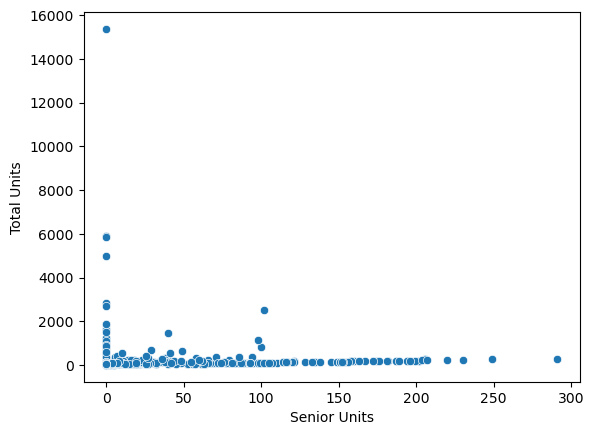

In [304]:
sns.scatterplot(x=merged_df["Senior Units"], y=merged_df["Total Units"])

* The above plot signifies very low amount of Units were allocated to Elderly people.
* The Maximum amount of Units allocated were close to 300.
* This number is very minimal when compared to the Total Number of Units procured by Housing Department.

In [307]:
(merged_df["Senior Units"].sum()/merged_df["Total Units"].sum()) * 100

4.786469645296347

* Only 5% of Units were allocated to Senior people. This percentage has to be significantly increased by the Housing Department considering the growing elderly population.

In [308]:
merged_df[merged_df['Senior Units']> 200]

Project ID                                       Project Name  \
985        48646             SKA MARIN. 1918 FIRST AVE. DRAPER HALL   
1542       68177                      CAPITOL APARTMENTS HDFC.HUDMF   
2359       65341                     FRIENDSET APTS HDFC.HUDMF.FY18   
2769       68160  O+O. 1611 & 1701 PURDY STREET. PARKCHESTER GAR...   
2886       64796                         127 WEST 43 ST | WOODSTOCK   
2951       67898             XENOLITH. 1810 WATSON AVENUE.SOTOMAYOR   
3010       69428                                 88-20 153RD STREET   
4276       73843                                 RED OAK.HUDMF.FY24   

                       Program Group Start Date Completion Date  \
985      Multifamily Finance Program 2014-12-24      2017-11-28   
1542     Multifamily Finance Program 2019-06-28      2019-06-28   
2359     Multifamily Finance Program 2018-12-20      2021-12-30   
2769     Multifamily Finance Program 2020-12-17      2023-08-03   
2886  Multifamily Incentives Program 2018-06-20      2024-05-06   
2951     Multifamily Finance Program 2021-06-24      2024-05-06   
3010  Multifamily Incentives Program 2021-06-30      2024-05-06   
4276     Multifamily Finance Program 2023-12-08      2023-12-08   

     Extended Affordability Prevailing Wage Status     Tax Benefit  \
985                      No        Prevailing Wage            420c   
1542                    Yes    Non Prevailing Wage      Article XI   
2359                    Yes    Non Prevailing Wage      Article XI   
2769                     No        Prevailing Wage            420c   
2886                     No    Non Prevailing Wage  Not Applicable   
2951                     No        Prevailing Wage  Not Applicable   
3010                     No    Non Prevailing Wage            421a   
4276                    Yes    Non Prevailing Wage       Article V   

      Ext Low Income Units  Very Low Income Units  ...  Total Rental Units  \
985                    202                      0  ...                 203   
1542                   239                      6  ...                 278   
2359                   250                      4  ...                 259   
2769                   220                      0  ...                 221   
2886                     0                    281  ...                 291   
2951                   204                      0  ...                 205   
3010                     0                      0  ...                 207   
4276                   210                     12  ...                 230   

      HomeOwnership Units  All Units  Total Units  Senior Units  \
985                     0        203          203           202   
1542                    0        278          278           249   
2359                    0        259          259           206   
2769                    0        221          221           220   
2886                    0        291          291           291   
2951                    0        205          205           204   
3010                    0        207          207           207   
4276                    0        230          230           230   

      Project Duration  Ongoing Project  LowEarning Income Units  \
985                 35                0                      202   
1542                 0                0                      247   
2359                36                0                      255   
2769                31                0                      220   
2886                70                1                      291   
2951                34                1                      204   
3010                34                1                      207   
4276                 0                0                      225   

      ModerateEarning Income Units  Inception Year  
985                              0            2014  
1542                            30            2019  
2359                             4            2018  

* The above data signifies that only in 2021, 2023 there were significantly higher number of Projects focussed on procuring/constructing Senior Units.
* This was due to Housing & Homelessness plan started by Housing Department in 2022 to focus on Senior households and Homeless people.
* Projects such as __XENOLITH. 1810 WATSON AVENUE.SOTOMAYOR__, __88-20 153RD STREET__, __RED OAK.HUDMF.FY24__ started by Housing Department were highly successful in meeting demands of elderly people and the policies followed in these projects should be taken as guidelines when creating new projects to meet the housing needs.

### Conclusion:

* In conclusion, New York City's affordable housing initiatives face challenges in allocation balance, housing diversification, and support for vulnerable populations like senior households. 
* Rebalancing allocation percentages, diversifying the housing stock, and implementing targeted senior housing initiatives are crucial.
* Enhanced funding and efficiency measures are needed to address disparities in construction trends.
* By prioritizing these strategies, policymakers can work towards a more equitable and sustainable housing landscape, ensuring all residents have access to affordable housing options.
